In [235]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")

#BiocManager::install("clusterProfiler", force = TRUE)
#BiocManager::install("DO.db", force=TRUE)

#install.packages("ontologyIndex")
#install.packages("ggnewscale")
#install.packages("ggupset")
#install.packages("europepmc")
#install.packages("ggridges")
#install.packages("forcats")


In [1]:
library(dplyr)
library(stringr)
library(tidyr)
library(clusterProfiler)
library(ontologyIndex)
library(ggnewscale)
library(enrichplot)
library(ggupset)
library(europepmc)
library(ggridges)
library(ggplot2)
library(cowplot)
library(forcats)

load("../tea/A2TEA_finished.RData")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




clusterProfiler v4.0.5  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141. doi: 10.1016/j.xinn.2021.100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter




In [2]:
#we use get_ontology from ontologIndex to read the GeneOntology .obo file
#we extract all tags (everything), so that we retain the namespace/aspect info: BP, MF, CC
ont <- get_ontology("../go.obo", extract_tags = "everything")

#filtering of obsolete terms; shortening & renaming (clusterProfiler functions are picky)
ont_short <- as.data.frame(ont) %>%
  dplyr::filter(obsolete == FALSE) %>%
  dplyr::select(id, name, namespace) %>%
  dplyr::rename(GO = id) %>%
  dplyr::rename(Description = name)
row.names(ont_short) <- NULL

#split into aspect specific sets
ont_BP <- ont_short %>%
  filter(namespace == "biological_process")

ont_MF <- ont_short %>%
  filter(namespace == "molecular_function")

ont_CC <- ont_short %>%
  filter(namespace == "cellular_component")

Enrichment analysis can be performed on HOG level
- this entails that we have non-redundant GO terms for all genes in the orthologous group
- however, on HOG level we don't possess log2FC values 
- thus we compute sets for pure HOG analysis (1) as well as diff. exp. genes in the HOGs (2)

In [102]:
#HOG level

#input for buildGomap needs to be long format - one GO term per row
SFA_OG_clusterProfiler <- SFA_OG_level$hypothesis_2 %>%
  dplyr::select(HOG, `Gene-Ontology-Term`) %>%
  dplyr::mutate(
      `Gene-Ontology-Term` = str_remove_all(`Gene-Ontology-Term`, "NA, |, NA") 
    ) %>% 
    #remove lines with only NA in Gene-Ontology-Term column
  dplyr::filter(!str_detect(`Gene-Ontology-Term`, 'NA')) %>%
  relocate(`Gene-Ontology-Term`, .before = HOG) %>%
  dplyr::rename(ID = `Gene-Ontology-Term`) %>%
  dplyr::rename(geneID = HOG) %>%
  separate_rows(ID, sep = ",") %>%
  #removing whitespace
  dplyr::mutate(
    ID = str_trim(ID, side = c("both"))
  ) %>%
  dplyr::mutate(
    geneID = str_trim(geneID, side = c("both"))
  ) 
  
#create subsets for the 3 ontology aspects
SFA_OG_clusterProfiler_BP <- SFA_OG_clusterProfiler %>%
  filter(ID %in% ont_BP$GO)

SFA_OG_clusterProfiler_MF <- SFA_OG_clusterProfiler %>%
  filter(ID %in% ont_MF$GO)

SFA_OG_clusterProfiler_CC <- SFA_OG_clusterProfiler %>%
  filter(ID %in% ont_CC$GO)

#important: buildGOmap only functions with data.frame input NOT with tibbles..
SFA_OG_clusterProfiler_BP <- as.data.frame(SFA_OG_clusterProfiler_BP)
SFA_OG_clusterProfiler_MF <- as.data.frame(SFA_OG_clusterProfiler_MF)
SFA_OG_clusterProfiler_CC <- as.data.frame(SFA_OG_clusterProfiler_CC)

OG_GOmap_BP <- buildGOmap(gomap = SFA_OG_clusterProfiler_BP[1:1000,])
OG_GOmap_MF <- buildGOmap(gomap = SFA_OG_clusterProfiler_MF[1:1000,])
OG_GOmap_CC <- buildGOmap(gomap = SFA_OG_clusterProfiler_CC[1:1000,])

#head(OG_GOmap_BP)
#head(OG_GOmap_MF)
#head(OG_GOmap_CC)

GO         Gene         
1     GO:0000723 N0.HOG0000000
2     GO:0006281 N0.HOG0000000
3     GO:0006310 N0.HOG0000000
4     GO:0006508 N0.HOG0000000
5     GO:0006974 N0.HOG0000000
6     GO:0032508 N0.HOG0000000
7     GO:0016926 N0.HOG0000000
8     GO:0009909 N0.HOG0000000
9     GO:0009911 N0.HOG0000000
10    GO:0015031 N0.HOG0000000
11    GO:0006412 N0.HOG0000000
12    GO:0042545 N0.HOG0000000
13    GO:0043086 N0.HOG0000000
14    GO:0045490 N0.HOG0000000
15    GO:0000244 N0.HOG0000000
16    GO:0000398 N0.HOG0000000
17    GO:0006397 N0.HOG0000000
18    GO:0008380 N0.HOG0000000
19    GO:0006139 N0.HOG0000000
20    GO:0006259 N0.HOG0000000
21    GO:0006725 N0.HOG0000000
22    GO:0006807 N0.HOG0000000
23    GO:0006996 N0.HOG0000000
24    GO:0008150 N0.HOG0000000
25    GO:0008152 N0.HOG0000000
26    GO:0009987 N0.HOG0000000
27    GO:0016043 N0.HOG0000000
28    GO:0032200 N0.HOG0000000
29    GO:0034641 N0.HOG0000000
30    GO:0042592 N0.HOG0000000
⋮     ⋮          ⋮            
78543 GO:0034641 N0.HOG0002377
78544 GO:0034645 N0.HOG0002377
78545 GO:0043043 N0.HOG0002377
78546 GO:0043170 N0.HOG0002377
78547 GO:0043603 N0.HOG0002377
78548 GO:0043604 N0.HOG0002377
78549 GO:0044237 N0.HOG0002377
78550 GO:0044238 N0.HOG0002377
78551 GO:0044249 N0.HOG0002377
78552 GO:0044260 N0.HOG0002377
78553 GO:0044267 N0.HOG0002377
78554 GO:0044271 N0.HOG0002377
78555 GO:0045727 N0.HOG0002377
78556 GO:0048518 N0.HOG0002377
78557 GO:0048522 N0.HOG0002377
78558 GO:0050789 N0.HOG0002377
78559 GO:0050794 N0.HOG0002377
78560 GO:0051171 N0.HOG0002377
78561 GO:0051173 N0.HOG0002377
78562 GO:0051246 N0.HOG0002377
78563 GO:0051247 N0.HOG0002377
78564 GO:0060255 N0.HOG0002377
78565 GO:0065007 N0.HOG0002377
78566 GO:0065008 N0.HOG0002377
78567 GO:0071704 N0.HOG0002377
78568 GO:0080090 N0.HOG0002377
78569 GO:1901564 N0.HOG0002377
78570 GO:1901566 N0.HOG0002377
78571 GO:1901576 N0.HOG0002377
78572 GO:2000112 N0.HOG0002377

GO         Gene         
1     GO:0000166 N0.HOG0000000
2     GO:0003678 N0.HOG0000000
3     GO:0004386 N0.HOG0000000
4     GO:0005524 N0.HOG0000000
5     GO:0008234 N0.HOG0000000
6     GO:0016787 N0.HOG0000000
7     GO:0008233 N0.HOG0000000
8     GO:0019900 N0.HOG0000000
9     GO:0070139 N0.HOG0000000
10    GO:0070140 N0.HOG0000000
11    GO:0003735 N0.HOG0000000
12    GO:0051287 N0.HOG0000000
13    GO:0004857 N0.HOG0000000
14    GO:0030599 N0.HOG0000000
15    GO:0045330 N0.HOG0000000
16    GO:0046910 N0.HOG0000000
17    GO:0043531 N0.HOG0000000
18    GO:0003723 N0.HOG0000000
19    GO:0008237 N0.HOG0000000
20    GO:0017070 N0.HOG0000000
21    GO:0030619 N0.HOG0000000
22    GO:0030620 N0.HOG0000000
23    GO:0030623 N0.HOG0000000
24    GO:0070122 N0.HOG0000000
25    GO:0097157 N0.HOG0000000
26    GO:0004843 N0.HOG0000000
27    GO:0003674 N0.HOG0000000
28    GO:0005488 N0.HOG0000000
29    GO:0036094 N0.HOG0000000
30    GO:0097159 N0.HOG0000000
⋮     ⋮          ⋮            
23291 GO:0036094 N0.HOG0001697
23292 GO:0043167 N0.HOG0001697
23293 GO:0043168 N0.HOG0001697
23294 GO:0050660 N0.HOG0001697
23295 GO:0097159 N0.HOG0001697
23296 GO:1901265 N0.HOG0001697
23297 GO:1901363 N0.HOG0001697
23298 GO:0008137 N0.HOG0001699
23299 GO:0016651 N0.HOG0001699
23300 GO:0016655 N0.HOG0001699
23301 GO:0048038 N0.HOG0001699
23302 GO:0003674 N0.HOG0001699
23303 GO:0003824 N0.HOG0001699
23304 GO:0003954 N0.HOG0001699
23305 GO:0003955 N0.HOG0001699
23306 GO:0009055 N0.HOG0001699
23307 GO:0016491 N0.HOG0001699
23308 GO:0050136 N0.HOG0001699
23309 GO:0005488 N0.HOG0001699
23310 GO:0003677 N0.HOG0001700
23311 GO:0003700 N0.HOG0001700
23312 GO:0003674 N0.HOG0001700
23313 GO:0003676 N0.HOG0001700
23314 GO:0005488 N0.HOG0001700
23315 GO:0097159 N0.HOG0001700
23316 GO:1901363 N0.HOG0001700
23317 GO:0140110 N0.HOG0001700
23318 GO:0016491 N0.HOG0001701
23319 GO:0003674 N0.HOG0001701
23320 GO:0003824 N0.HOG0001701

GO         Gene         
1     GO:0005634 N0.HOG0000000
2     GO:0016020 N0.HOG0000000
3     GO:0031965 N0.HOG0000000
4     GO:0005737 N0.HOG0000000
5     GO:0009506 N0.HOG0000000
6     GO:0016021 N0.HOG0000000
7     GO:0005840 N0.HOG0000000
8     GO:0005681 N0.HOG0000000
9     GO:0005682 N0.HOG0000000
10    GO:0071013 N0.HOG0000000
11    GO:0005575 N0.HOG0000000
12    GO:0005622 N0.HOG0000000
13    GO:0043226 N0.HOG0000000
14    GO:0043227 N0.HOG0000000
15    GO:0043229 N0.HOG0000000
16    GO:0043231 N0.HOG0000000
17    GO:0110165 N0.HOG0000000
18    GO:0005635 N0.HOG0000000
19    GO:0012505 N0.HOG0000000
20    GO:0031090 N0.HOG0000000
21    GO:0031967 N0.HOG0000000
22    GO:0031975 N0.HOG0000000
23    GO:0005911 N0.HOG0000000
24    GO:0030054 N0.HOG0000000
25    GO:0055044 N0.HOG0000000
26    GO:0070161 N0.HOG0000000
27    GO:0031224 N0.HOG0000000
28    GO:0043228 N0.HOG0000000
29    GO:0043232 N0.HOG0000000
30    GO:0032991 N0.HOG0000000
⋮     ⋮          ⋮            
29087 GO:0043226 N0.HOG0002752
29088 GO:0043227 N0.HOG0002752
29089 GO:0043229 N0.HOG0002752
29090 GO:0043231 N0.HOG0002752
29091 GO:0110165 N0.HOG0002752
29092 GO:0031090 N0.HOG0002752
29093 GO:0031984 N0.HOG0002752
29094 GO:0042175 N0.HOG0002752
29095 GO:0098827 N0.HOG0002752
29096 GO:0031224 N0.HOG0002752
29097 GO:0005576 N0.HOG0002753
29098 GO:0005773 N0.HOG0002753
29099 GO:0005774 N0.HOG0002753
29100 GO:0005829 N0.HOG0002753
29101 GO:0048046 N0.HOG0002753
29102 GO:0099503 N0.HOG0002753
29103 GO:0016020 N0.HOG0002753
29104 GO:0005575 N0.HOG0002753
29105 GO:0110165 N0.HOG0002753
29106 GO:0005622 N0.HOG0002753
29107 GO:0005737 N0.HOG0002753
29108 GO:0043226 N0.HOG0002753
29109 GO:0043227 N0.HOG0002753
29110 GO:0043229 N0.HOG0002753
29111 GO:0043231 N0.HOG0002753
29112 GO:0031090 N0.HOG0002753
29113 GO:0098588 N0.HOG0002753
29114 GO:0031410 N0.HOG0002753
29115 GO:0031982 N0.HOG0002753
29116 GO:0097708 N0.HOG0002753

In [3]:
#interesting genes level (those inside the interesting HOGs)

#input for buildGomap needs to be long format - one GO term per row
SFA_genes_clusterProfiler <- SFA[[2]] %>%
  dplyr::select(`Protein-Accession`, `Gene-Ontology-Term`) %>%
  dplyr::mutate(
      `Gene-Ontology-Term` = str_remove_all(`Gene-Ontology-Term`, "NA, |, NA") 
    ) %>% 
    #remove lines with only NA in Gene-Ontology-Term column
  dplyr::filter(!str_detect(`Gene-Ontology-Term`, 'NA')) %>%
  relocate(`Gene-Ontology-Term`, .before = `Protein-Accession`) %>%
  dplyr::rename(ID = `Gene-Ontology-Term`) %>%
  dplyr::rename(geneID = `Protein-Accession`) %>%
  separate_rows(ID, sep = ",") %>%
  #removing whitespace
  dplyr::mutate(
    ID = str_trim(ID, side = c("both"))
  ) %>%
  dplyr::mutate(
    geneID = str_trim(geneID, side = c("both"))
  ) 
  
#create subsets for the 3 ontology aspects
SFA_genes_clusterProfiler_BP <- SFA_genes_clusterProfiler %>%
  filter(ID %in% ont_BP$GO)

SFA_genes_clusterProfiler_MF <- SFA_genes_clusterProfiler %>%
  filter(ID %in% ont_MF$GO)

SFA_genes_clusterProfiler_CC <- SFA_genes_clusterProfiler %>%
  filter(ID %in% ont_CC$GO)

#important: buildGOmap only functions with data.frame input NOT with tibbles..
SFA_genes_clusterProfiler_BP <- as.data.frame(SFA_genes_clusterProfiler_BP)
SFA_genes_clusterProfiler_MF <- as.data.frame(SFA_genes_clusterProfiler_MF)
SFA_genes_clusterProfiler_CC <- as.data.frame(SFA_genes_clusterProfiler_CC)

Genes_GOmap_BP <- buildGOmap(gomap = SFA_genes_clusterProfiler_BP[1:10000,])
Genes_GOmap_MF <- buildGOmap(gomap = SFA_genes_clusterProfiler_MF[1:10000,])
Genes_GOmap_CC <- buildGOmap(gomap = SFA_genes_clusterProfiler_CC[1:10000,])

head(Genes_GOmap_BP)
head(Genes_GOmap_MF)
head(Genes_GOmap_CC)

GO         Gene            
1 GO:0006811 HORVU0Hr1G001040
2 GO:0006816 HORVU0Hr1G001040
3 GO:0070588 HORVU0Hr1G001040
4 GO:0006810 HORVU0Hr1G001040
5 GO:0008150 HORVU0Hr1G001040
6 GO:0051179 HORVU0Hr1G001040

GO         Gene            
1 GO:0000166 HORVU0Hr1G001040
2 GO:0005388 HORVU0Hr1G001040
3 GO:0005516 HORVU0Hr1G001040
4 GO:0005524 HORVU0Hr1G001040
5 GO:0019829 HORVU0Hr1G001040
6 GO:0046872 HORVU0Hr1G001040

GO         Gene            
1 GO:0005887 HORVU0Hr1G001040
2 GO:0016020 HORVU0Hr1G001040
3 GO:0016021 HORVU0Hr1G001040
4 GO:0043231 HORVU0Hr1G001040
5 GO:0005575 HORVU0Hr1G001040
6 GO:0005886 HORVU0Hr1G001040

In [43]:
#we have to define an interesting set (expansion+diff.exp.) we could for instance filter based on tea_value
int_HOGs <- HOG_level_list[[2]] %>%
  filter(tea_value < 0.05) %>%
  pull(HOG)


#significantly expressed genes based on the interesting HOG definition prior can be extracted

h_expanded_in <- unlist(str_split(hypotheses$expanded_in[2], ";"))
h_compared_to <- unlist(str_split(hypotheses$compared_to[2], ";"))
h_species <- unique(c(h_expanded_in, h_compared_to))


int_genes <- HOG_DE.a2tea %>%
  filter(HOG %in% int_HOGs) %>%
  filter(species %in% h_species) %>%
#for GSEA we could use all genes not only the significant ones
#  filter(significant == "yes") %>%
  pull(gene)

In [300]:
resGO <- enricher(
  int_genes,
  TERM2GENE=Genes_GOmap_BP,
  TERM2NAME=ont_BP
)
ttt <- resGO

In [51]:
?GSEA

Warning message in seq_len(head.end.idx):
“first element used of 'length.out' argument”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): argument must be coercible to non-negative integer

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_conte

In [271]:
resGO <- GSEA(
  qlfc_vec,
  TERM2GENE=Genes_GOmap_BP,
  TERM2NAME=ont_BP 
)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (7.67% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
leading edge analysis...

done...



In [71]:
resGO
resGO@result

#
# over-representation test
#
#...@organism 	 UNKNOWN 
#...@ontology 	 BP 
#...@gene 	 chr [1:2706] "HORVU0Hr1G000020" "HORVU0Hr1G000730" "HORVU0Hr1G000760" ...
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...27 enriched terms found
'data.frame':	27 obs. of  9 variables:
 $ ID         : chr  "GO:0006468" "GO:0016310" "GO:0000184" "GO:0006952" ...
 $ Description: chr  "protein phosphorylation" "phosphorylation" "nuclear-transcribed mRNA catabolic process, nonsense-mediated decay" "defense response" ...
 $ GeneRatio  : chr  "79/242" "86/242" "25/242" "61/242" ...
 $ BgRatio    : chr  "371/3478" "464/3478" "60/3478" "326/3478" ...
 $ pvalue     : num  2.56e-22 4.00e-20 2.03e-14 4.20e-14 1.95e-12 ...
 $ p.adjust   : num  9.76e-20 7.64e-18 2.58e-12 4.01e-12 1.49e-10 ...
 $ qvalue     : num  8.93e-20 6.99e-18 2.36e-12 3.67e-12 1.36e-10 ...
 $ geneID     : chr  "HORVU0Hr1G039890/HORVU0Hr1G040370/HORVU0Hr1G040500/HORVU0Hr1G040550/HORVU1Hr1G005700/HORVU1Hr1G005720/HORVU1Hr1"| __truncated__

ID        
GO:0006468 GO:0006468
GO:0016310 GO:0016310
GO:0000184 GO:0000184
GO:0006952 GO:0006952
GO:0000956 GO:0000956
GO:0006402 GO:0006402
GO:0006401 GO:0006401
GO:0034655 GO:0034655
GO:0044270 GO:0044270
GO:0046700 GO:0046700
GO:0019439 GO:0019439
GO:1901361 GO:1901361
GO:0010629 GO:0010629
GO:0007166 GO:0007166
GO:0008037 GO:0008037
GO:0048544 GO:0048544
GO:0016071 GO:0016071
GO:0009875 GO:0009875
GO:0010605 GO:0010605
GO:0009892 GO:0009892
GO:0090305 GO:0090305
GO:0051704 GO:0051704
GO:0009856 GO:0009856
GO:0044706 GO:0044706
GO:0044265 GO:0044265
GO:0007154 GO:0007154
GO:0009057 GO:0009057
GO:0048519 GO:0048519
GO:0007165 GO:0007165
GO:0023052 GO:0023052
⋮          ⋮         
GO:0050793 GO:0050793
GO:0006518 GO:0006518
GO:0006412 GO:0006412
GO:0043043 GO:0043043
GO:0051603 GO:0051603
GO:0044257 GO:0044257
GO:0030163 GO:0030163
GO:0043604 GO:0043604
GO:0015031 GO:0015031
GO:0045184 GO:0045184
GO:0048523 GO:0048523
GO:0015833 GO:0015833
GO:0042886 GO:0042886
GO:0008104 GO:0008104
GO:0009628 GO:0009628
GO:0044281 GO:0044281
GO:0006629 GO:0006629
GO:0006396 GO:0006396
GO:0016043 GO:0016043
GO:0071705 GO:0071705
GO:0033036 GO:0033036
GO:0006508 GO:0006508
GO:0055085 GO:0055085
GO:0071702 GO:0071702
GO:0006820 GO:0006820
GO:1901566 GO:1901566
GO:0006810 GO:0006810
GO:0051234 GO:0051234
GO:0051179 GO:0051179
GO:0006811 GO:0006811
           Description                                                        
GO:0006468 protein phosphorylation                                            
GO:0016310 phosphorylation                                                    
GO:0000184 nuclear-transcribed mRNA catabolic process, nonsense-mediated decay
GO:0006952 defense response                                                   
GO:0000956 nuclear-transcribed mRNA catabolic process                         
GO:0006402 mRNA catabolic process                                             
GO:0006401 RNA catabolic process                                              
GO:0034655 nucleobase-containing compound catabolic process                   
GO:0044270 cellular nitrogen compound catabolic process                       
GO:0046700 heterocycle catabolic process                                      
GO:0019439 aromatic compound catabolic process                                
GO:1901361 organic cyclic compound catabolic process                          
GO:0010629 negative regulation of gene expression                             
GO:0007166 cell surface receptor signaling pathway                            
GO:0008037 cell recognition                                                   
GO:0048544 recognition of pollen                                              
GO:0016071 mRNA metabolic process                                             
GO:0009875 pollen-pistil interaction                                          
GO:0010605 negative regulation of macromolecule metabolic process             
GO:0009892 negative regulation of metabolic process                           
GO:0090305 nucleic acid phosphodiester bond hydrolysis                        
GO:0051704 multi-organism process                                             
GO:0009856 pollination                                                        
GO:0044706 multi-multicellular organism process                               
GO:0044265 cellular macromolecule catabolic process                           
GO:0007154 cell communication                                                 
GO:0009057 macromolecule catabolic process                                    
GO:0048519 negative regulation of biological process                          
GO:0007165 signal transduction                                                
GO:0023052 signaling                                                          
⋮          ⋮                                                                  
GO:0050793 regulation of developmental process                                
GO:0006518 peptide metabolic process    

In [84]:
str(resGO)
resGO
resGO@result

Formal class 'gseaResult' [package "DOSE"] with 12 slots
  ..@ result     :'data.frame':	9 obs. of  11 variables:
  .. ..$ ID             : chr [1:9] "GO:0006952" "GO:0006139" "GO:0046483" "GO:0042221" ...
  .. ..$ Description    : chr [1:9] "defense response" "nucleobase-containing compound metabolic process" "heterocycle metabolic process" "response to chemical" ...
  .. ..$ setSize        : int [1:9] 50 49 49 21 48 90 52 66 23
  .. ..$ enrichmentScore: num [1:9] -0.569 0.562 0.562 -0.704 0.551 ...
  .. ..$ NES            : num [1:9] -1.84 1.88 1.88 -1.89 1.84 ...
  .. ..$ pvalue         : num [1:9] 0.000138 0.000259 0.000259 0.000323 0.000462 ...
  .. ..$ p.adjust       : num [1:9] 0.00888 0.00888 0.00888 0.00888 0.01017 ...
  .. ..$ qvalues        : num [1:9] 0.00612 0.00612 0.00612 0.00612 0.007 ...
  .. ..$ rank           : num [1:9] 291 389 389 239 389 291 389 291 361
  .. ..$ leading_edge   : chr [1:9] "tags=38%, list=15%, signal=33%" "tags=49%, list=20%, signal=40%" "tags=49%,

#
# Gene Set Enrichment Analysis
#
#...@organism 	 UNKNOWN 
#...@setType 	 UNKNOWN 
#...@geneList 	 Named num [1:1956] 10.56 10.48 10.38 9.97 9.66 ...
 - attr(*, "names")= chr [1:1956] "HORVU3Hr1G089300" "HORVU5Hr1G103460" "HORVU6Hr1G084070" "HORVU3Hr1G004300" ...
#...nPerm 	 
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...9 enriched terms found
'data.frame':	9 obs. of  11 variables:
 $ ID             : chr  "GO:0006952" "GO:0006139" "GO:0046483" "GO:0042221" ...
 $ Description    : chr  "defense response" "nucleobase-containing compound metabolic process" "heterocycle metabolic process" "response to chemical" ...
 $ setSize        : int  50 49 49 21 48 90 52 66 23
 $ enrichmentScore: num  -0.569 0.562 0.562 -0.704 0.551 ...
 $ NES            : num  -1.84 1.88 1.88 -1.89 1.84 ...
 $ pvalue         : num  0.000138 0.000259 0.000259 0.000323 0.000462 ...
 $ p.adjust       : num  0.00888 0.00888 0.00888 0.00888 0.01017 ...
 $ qvalues        : num  0.00612 0.00612 0.00612 0.00612 0.00

ID         Description                                      setSize
GO:0006952 GO:0006952 defense response                                 50     
GO:0006139 GO:0006139 nucleobase-containing compound metabolic process 49     
GO:0046483 GO:0046483 heterocycle metabolic process                    49     
GO:0042221 GO:0042221 response to chemical                             21     
GO:0090304 GO:0090304 nucleic acid metabolic process                   48     
GO:0050896 GO:0050896 response to stimulus                             90     
GO:0034641 GO:0034641 cellular nitrogen compound metabolic process     52     
GO:0006950 GO:0006950 response to stress                               66     
GO:0048519 GO:0048519 negative regulation of biological process        23     
           enrichmentScore NES       pvalue       p.adjust    qvalues     rank
GO:0006952 -0.5687500      -1.836395 0.0001377771 0.008876163 0.006115634 291 
GO:0006139  0.5623169       1.878168 0.0002586035 0.008876163 0.006115634 389 
GO:0046483  0.5623169       1.878168 0.0002586035 0.008876163 0.006115634 389 
GO:0042221 -0.7042010      -1.894271 0.0003227696 0.008876163 0.006115634 239 
GO:0090304  0.5510766       1.835089 0.0004621102 0.010166424 0.007004617 389 
GO:0050896 -0.4654457      -1.662971 0.0006414587 0.011760076 0.008102636 291 
GO:0034641  0.5026004       1.699899 0.0018752766 0.029468632 0.020303747 389 
GO:0006950 -0.4969117      -1.690857 0.0021507908 0.029573373 0.020375913 291 
GO:0048519  0.6114555       1.708014 0.0038461133 0.047008052 0.032388323 361 
           leading_edge                  
GO:0006952 tags=38%, list=15%, signal=33%
GO:0006139 tags=49%, list=20%, signal=40%
GO:0046483 tags=49%, list=20%, signal=40%
GO:0042221 tags=57%, list=12%, signal=51%
GO:0090304 tags=48%, list=20%, signal=39%
GO:0050896 tags=33%, list=15%, signal=30%
GO:0034641 tags=48%, list=20%, signal=40%
GO:0006950 tags=36%, list=15%, signal=32%
GO:0048519 tags=57%, list=18%, signal=47%
           core_enrichment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
GO:0006952 HORVU6Hr1G021800/HORVU2Hr1G007800/HORVU6Hr1G092510/HORVU6Hr1G021780/HORVU2Hr1G005330/HORVU2Hr1G044650/HORVU7Hr1G021740/HORVU2Hr1G044640/HORVU2Hr1G044520/HORVU1Hr1G005470/HORVU7Hr1G116000/HORVU6Hr1G092250/HORVU6Hr1G092370/HORVU4Hr1G000310/HORVU2Hr1G044680/HORVU2Hr1G005350/HORVU6Hr1G021850/HORVU6Hr1G092090/HORVU2Hr1G005310                                                                                                                                                                                           
GO:0006139 HORVU2Hr1G030090/HORVU1Hr1G040260/HORVU0Hr1G013110/HORVU0Hr1G003880/HORVU3Hr1G024720/HORVU5Hr1G124820/HORVU2Hr1G019750/HORVU6Hr1G031270/HORVU3Hr1G058140/HORVU5Hr1G028780/HORVU2Hr1G027100/HORVU4Hr1G051940/HORVU7Hr1G031000/HORVU3Hr1G058490/HORVU7Hr1G043170/HORVU2Hr1G017400/HORVU3Hr1G036750/HORVU6Hr1G045930/HORVU4Hr1G058060/HORVU1Hr1G029760/HORVU4Hr1G024640/HORVU2Hr1G017530/HORVU5Hr1G038560/HORVU5Hr1G075590                                                                                                      
GO:0046483 HORVU2Hr1G030090/HORVU1Hr1G040260/HORVU0Hr1G013110/HORVU0Hr1G003880/HORVU3Hr1G024720/HORVU5Hr1G124820/HORVU2Hr1G019750/HORVU6Hr1G031270/HORVU3Hr1G058140/HORVU5Hr1G028780/HORVU2Hr1G027100/HORVU4Hr1G051940/HORVU7Hr1G031000/HORVU3Hr1G058490/HORVU7Hr1G043170/HORVU2Hr1G017400/HORVU3Hr1G036750/HORVU6Hr1G045930/HORVU4Hr1G058060/HORVU1Hr1G029760/HORVU4Hr1G024640/HORVU2Hr1G017530/HORVU5Hr1G038560/HORVU5Hr1G075590                              

### Visualizations

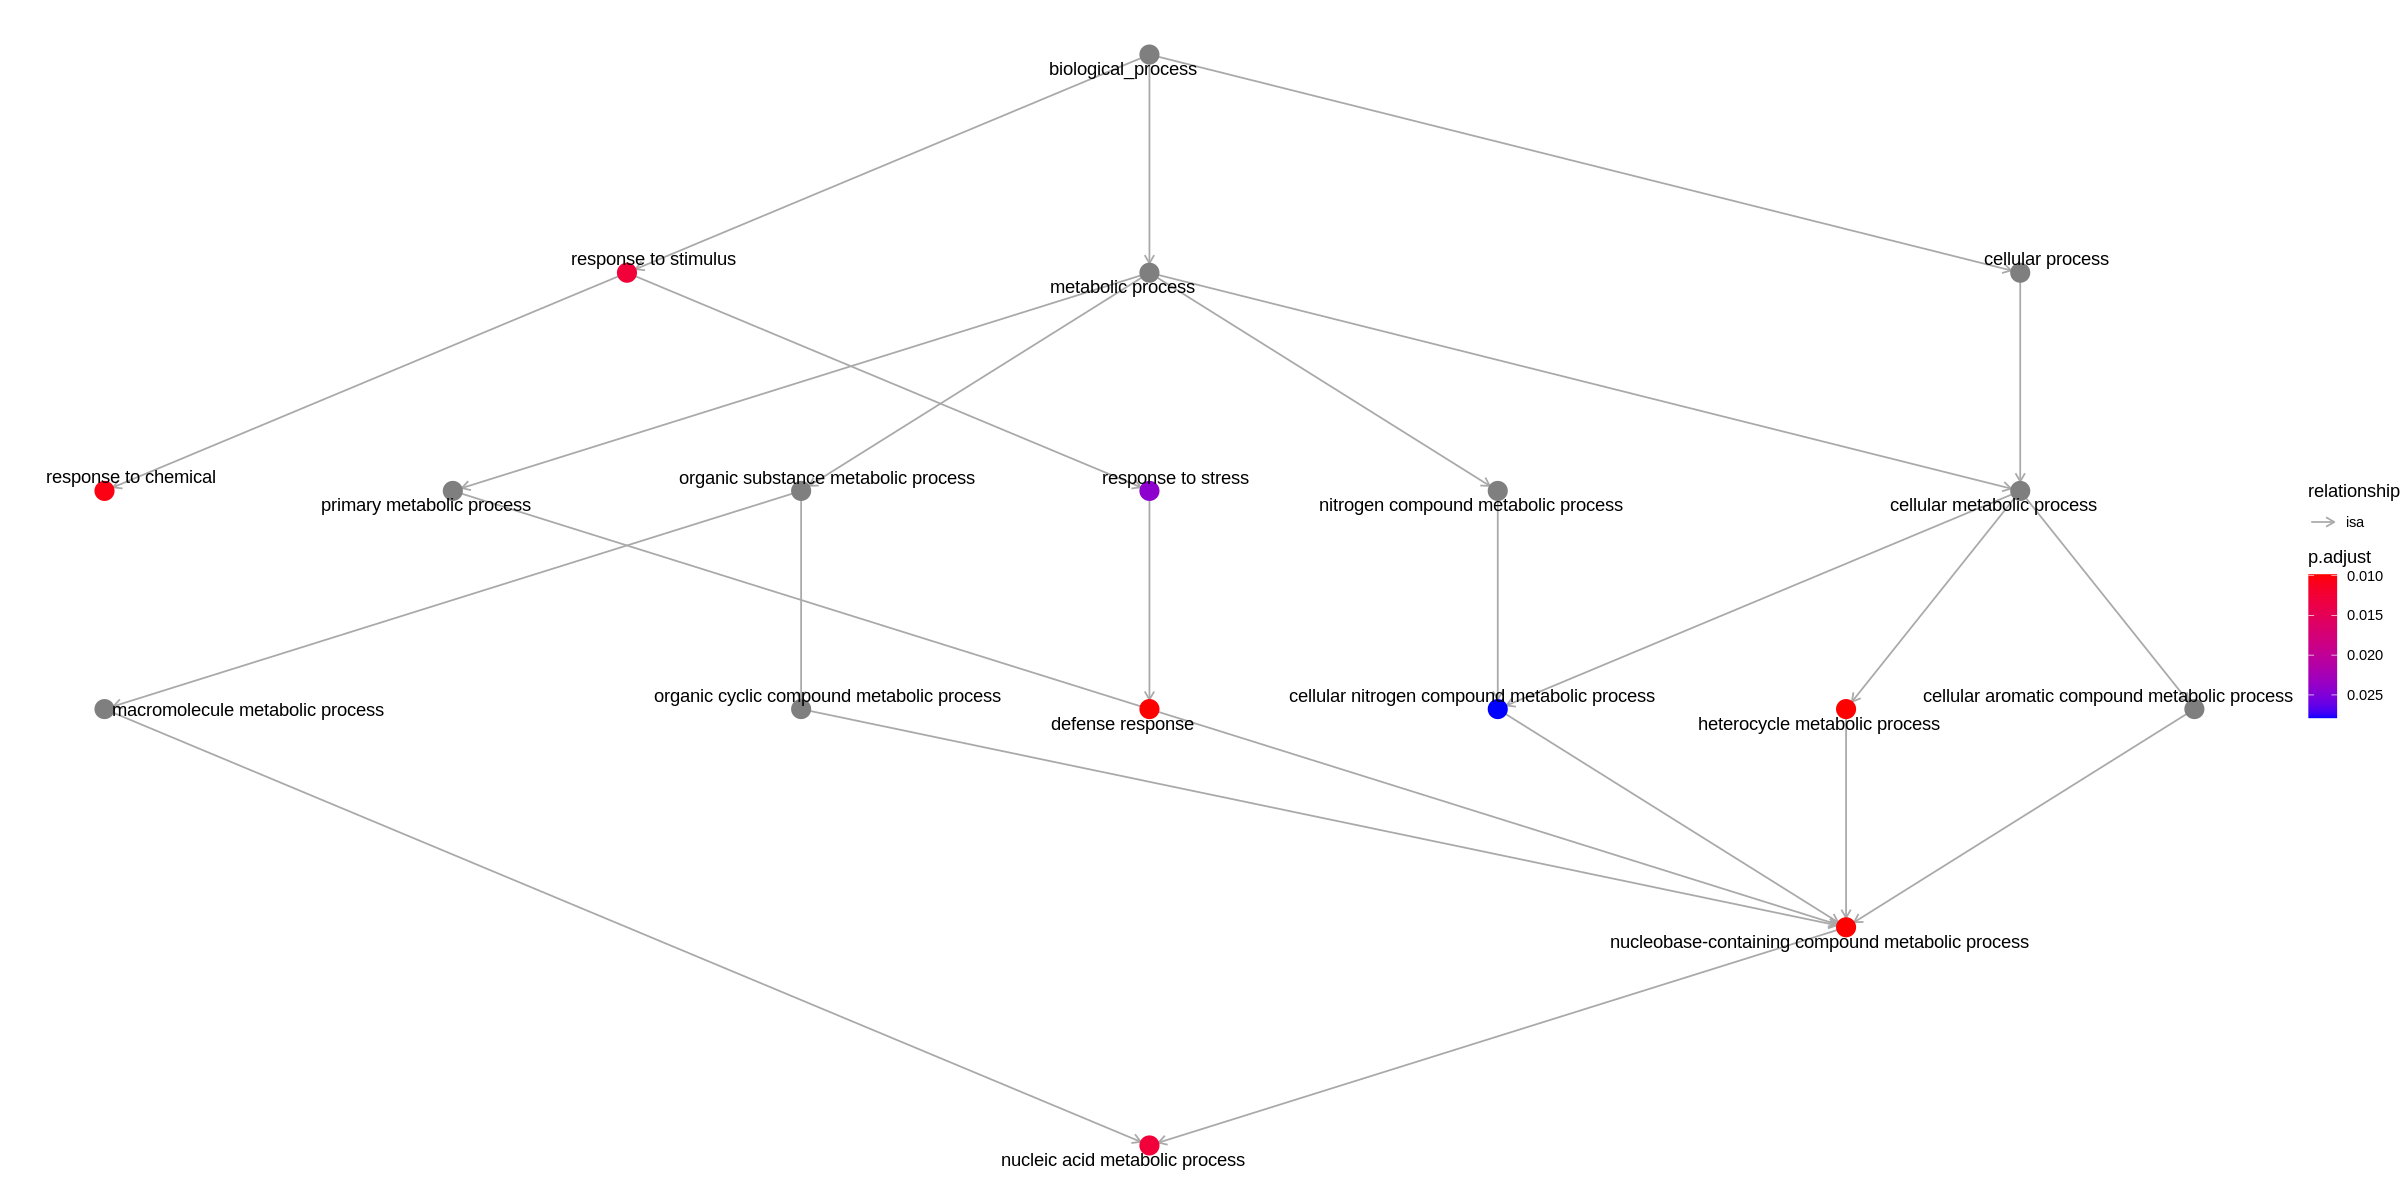

In [164]:
#need to assign an ontology - otherwise goplot() doesn't work..
#surprisingly, this is the only one of the plots that is picky..

#enrichment
#resGO@ontology <- "BP"
#goplot(resGO)

#GSEA - need to add an ontology slot
attributes(resGO)$ontology <- "BP"
goplot(resGO)

In [173]:
#library(DOSE)
#data(geneList)
#de <- names(geneList)[abs(geneList) > 2]
#de

#edo <- enrichDGN(de)
#edo

#edo2 <- gseDO(geneList)

#barplot(edo)
barplot(edo2)

ERROR: Error in barplot.default(edo2): 'height' must be a vector or a matrix


In [168]:
options(repr.plot.width=20, repr.plot.height=10)

#enrichment
#barplot(resGO, showCategory=20)

#mutate(resGO, qscore = -log(p.adjust, base=10)) %>% 
#    barplot(x="qscore")


#GSEA 
#getting error messages... - nOT intended for GSEA I guess

ERROR: Error in barplot.default(resGO, showCategory = 10): 'height' must be a vector or a matrix


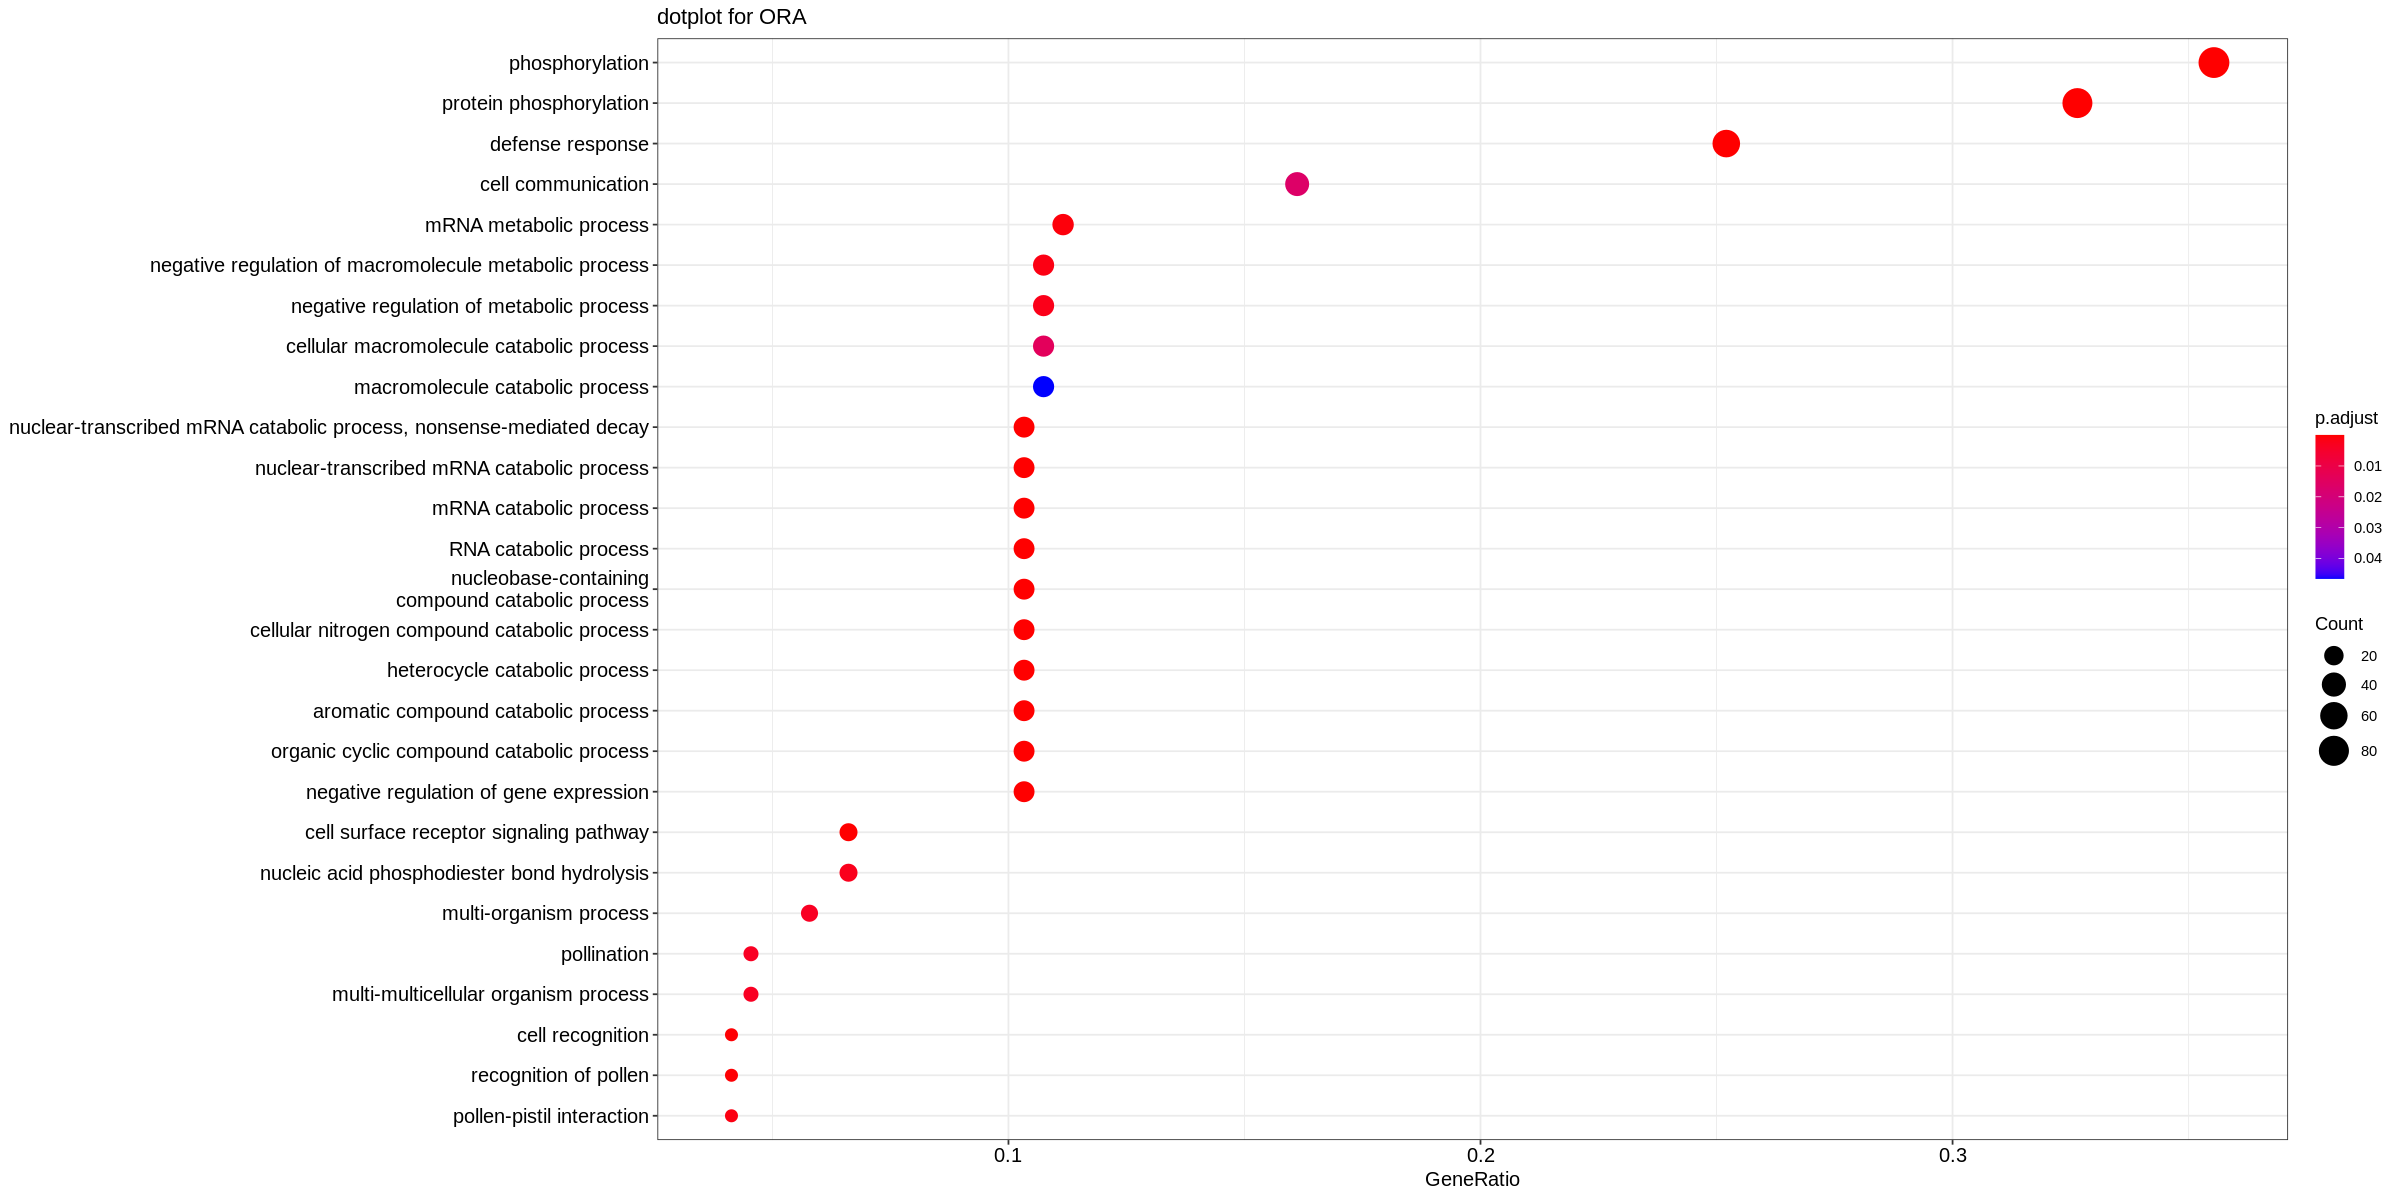

In [121]:
dotplot(resGO, showCategory=30) + ggtitle("dotplot for ORA")

In [45]:
#clusterProfiler wants named integer for passing the log2FoldChange values for plots
qlfc <- HOG_DE.a2tea %>%
  select(gene, log2FoldChange) %>%
  rename(foldChange = log2FoldChange) %>%
  filter(gene %in% int_genes)

qlfc_vec <- qlfc$foldChange
names(qlfc_vec) <- qlfc$gene

#sorting in decreasing order
qlfc_vec <- sort(qlfc_vec, decreasing = TRUE)

length(qlfc_vec)

[1] 1956

In [202]:
?cnetplot

Warning message in seq_len(head.end.idx):
“first element used of 'length.out' argument”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): argument must be coercible to non-negative integer

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_conte

Warning message:
“ggrepel: 43 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


ERROR: Error in fc_readable(x, foldChange): object 'geneList' not found


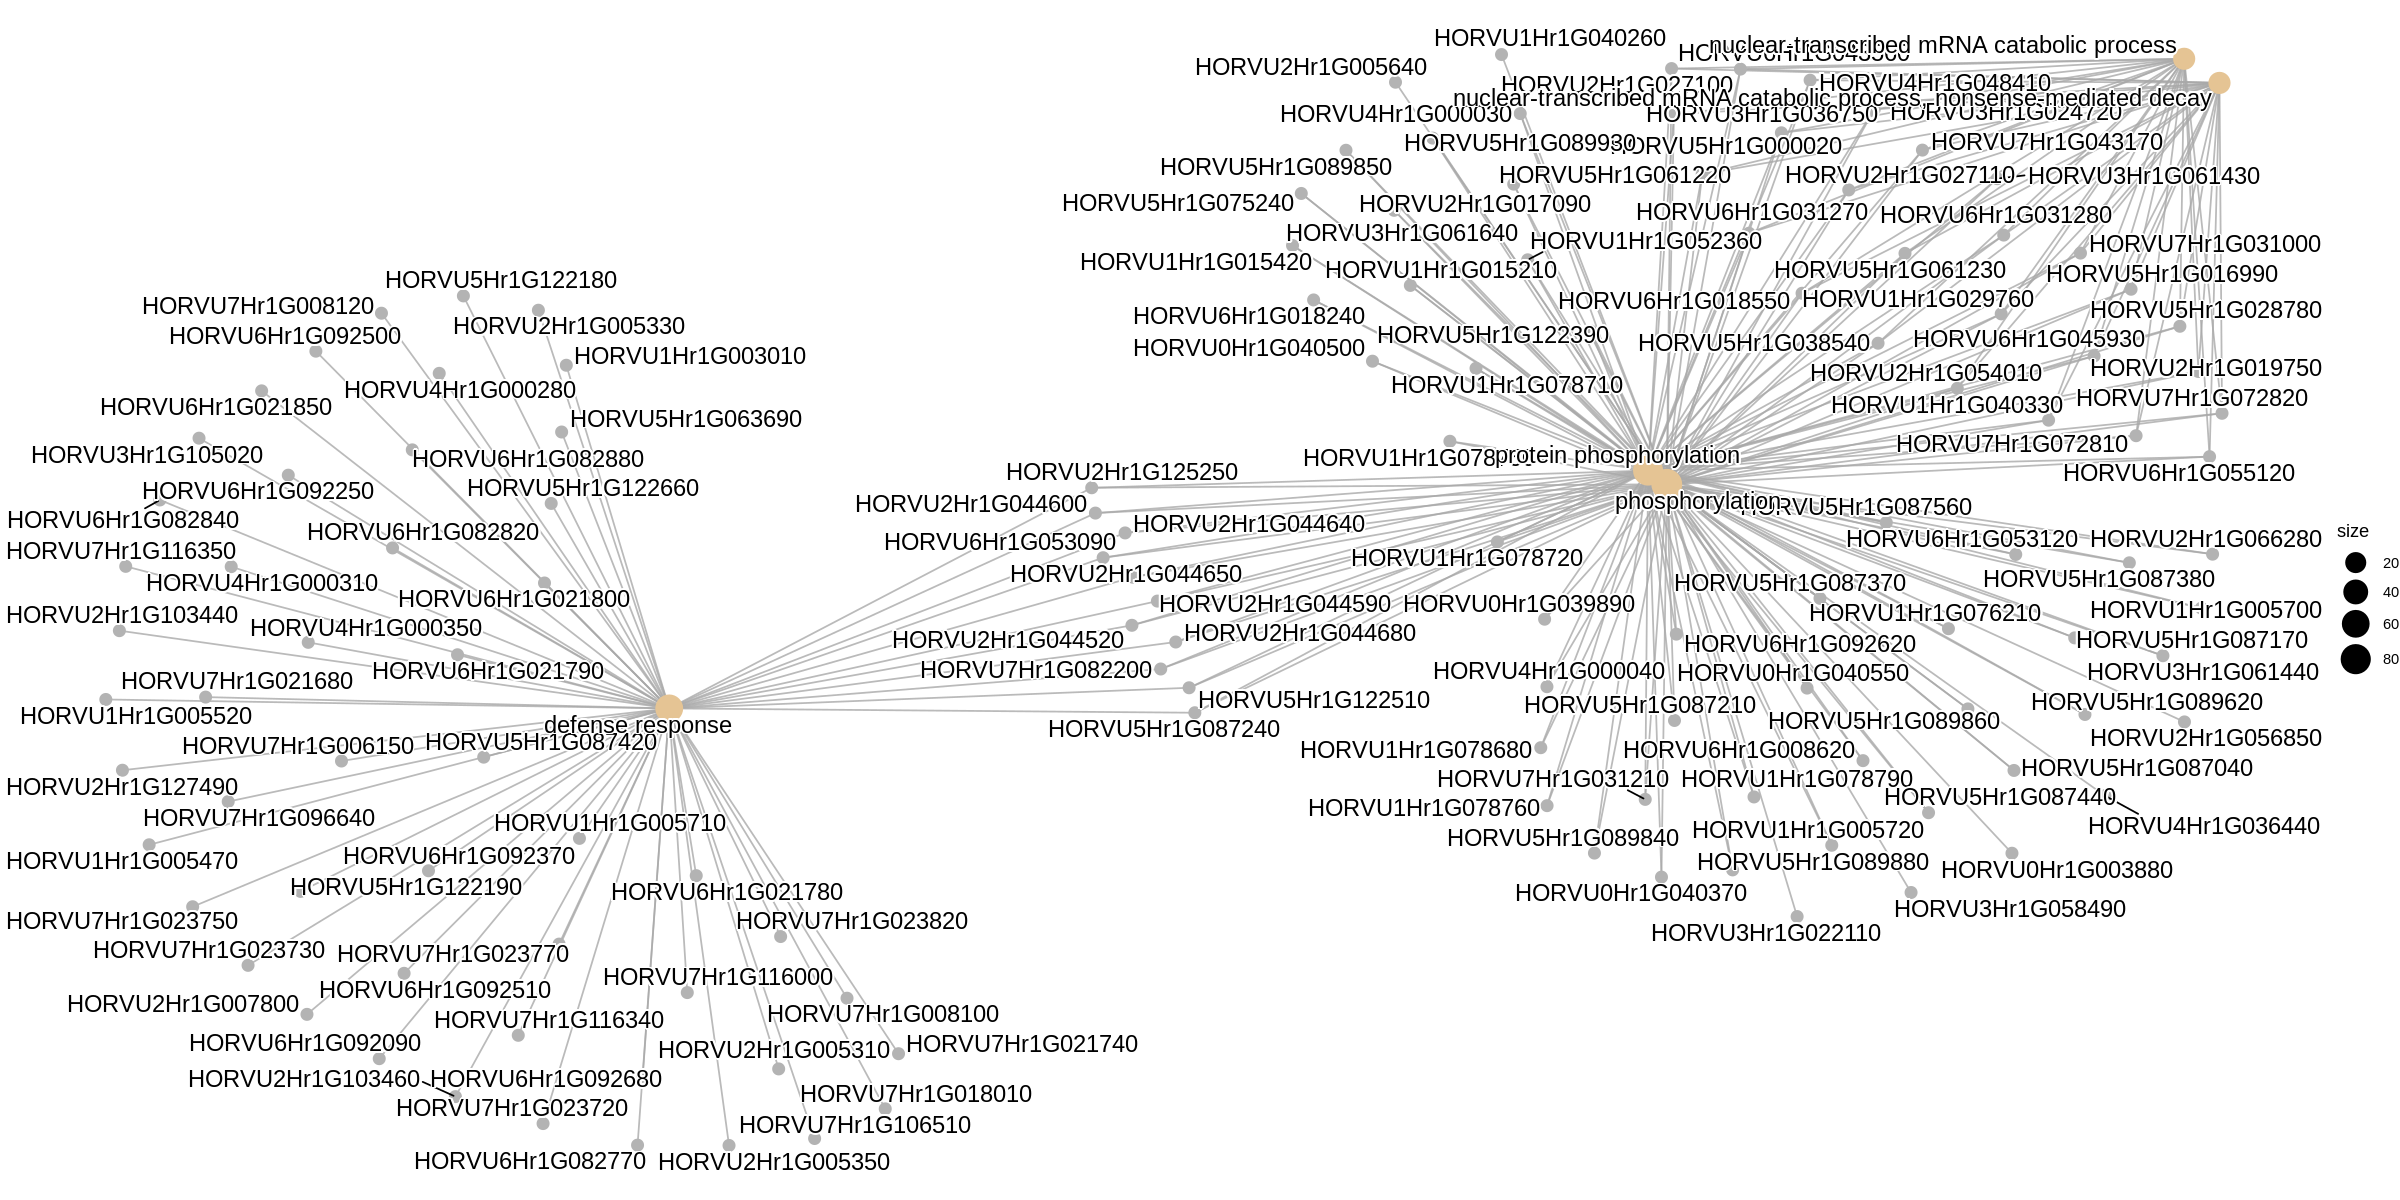

In [122]:
# Gene Concept Network
## convert gene ID to Symbol


##using gene level data - allows for log2FC

p1 <- cnetplot(resGO, categorySize="pvalue", layout = "kk")
p1

p2 <- cnetplot(resGO, categorySize="pvalue", foldChange=geneList, layout = "star")

p3 <- cnetplot(resGO, 
               showCategory = 5, 
               categorySize="pvalue", 
               foldChange=qlfc_vec,
               circular = TRUE, 
               colorEdge = TRUE)

## categorySize can be scaled by 'pvalue' or 'geneNum'
cowplot::plot_grid(p2, p3, ncol=2, labels=LETTERS[1:2], rel_widths=c(.8, .8, 1.2))

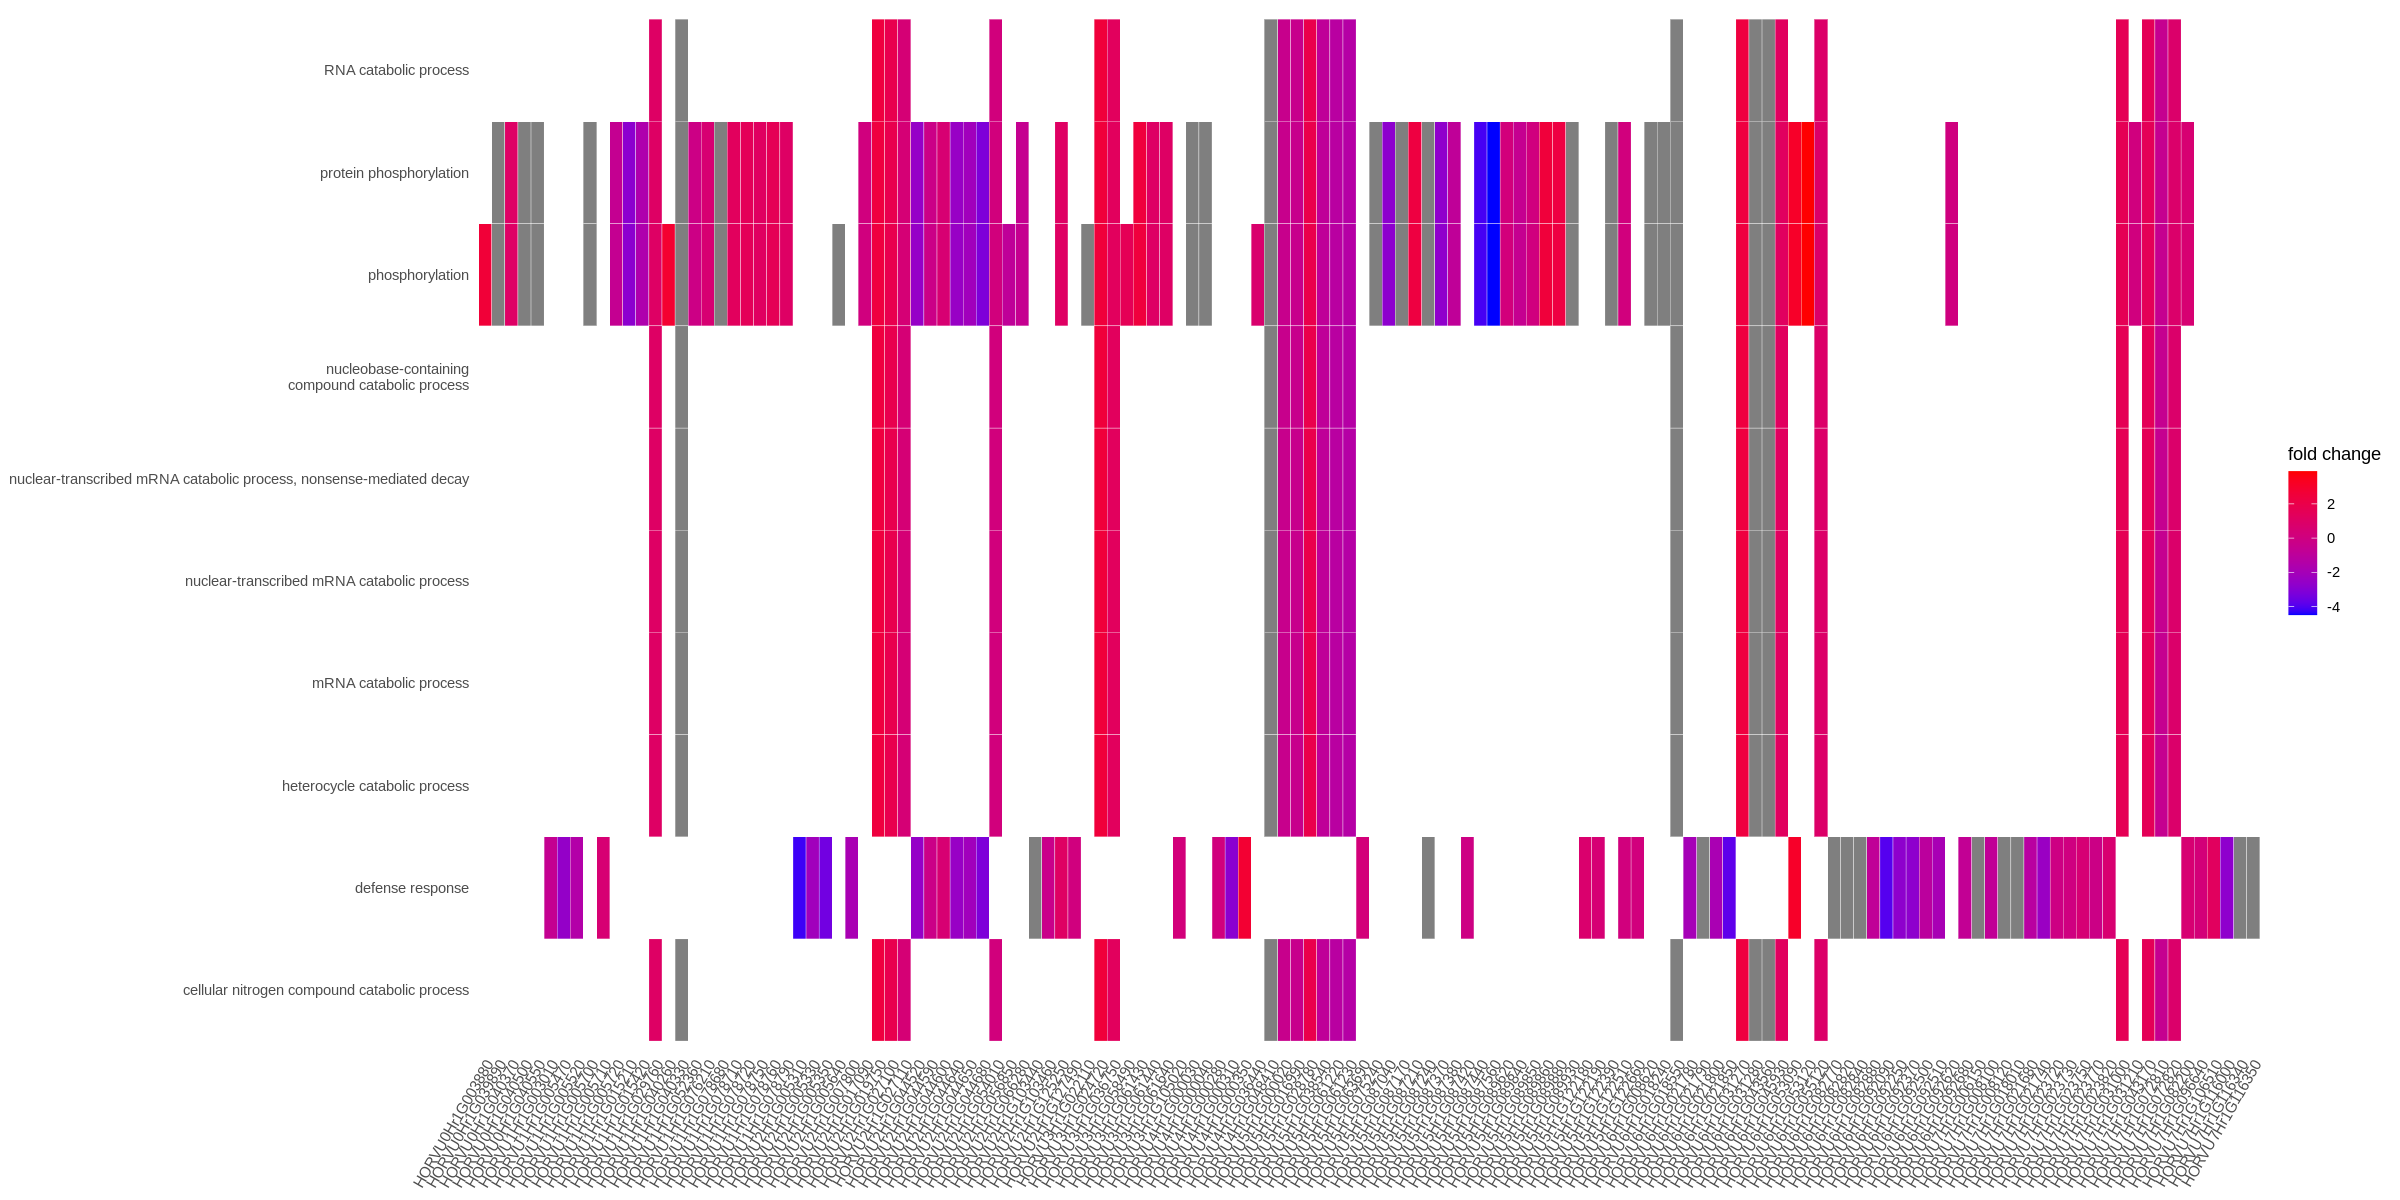

In [123]:
# Heatmap
p1 <- heatplot(resGO, showCategory=10, foldChange = qlfc_vec)
p1

In [163]:
# Tree plot - clustering
resGO_termsim <- pairwise_termsim(resGO, method="JC")
#resGO_termsim@termsim

p1 <- treeplot(resGO_termsim, nCluster = 5)
p1

#p2 <- treeplot(resGO_termsim, hclust_method = "average")
#p2
#aplot::plot_list(list(p1, p2)) + plot_annotation(tag_levels='A')


#GSEA 
#getting error messages... - nOT intended for GSEA I guess

ERROR: Error in data.frame(node = as.numeric(roots), label = cluster_label, cluster = cluster_color, : arguments imply differing number of rows: 5, 0


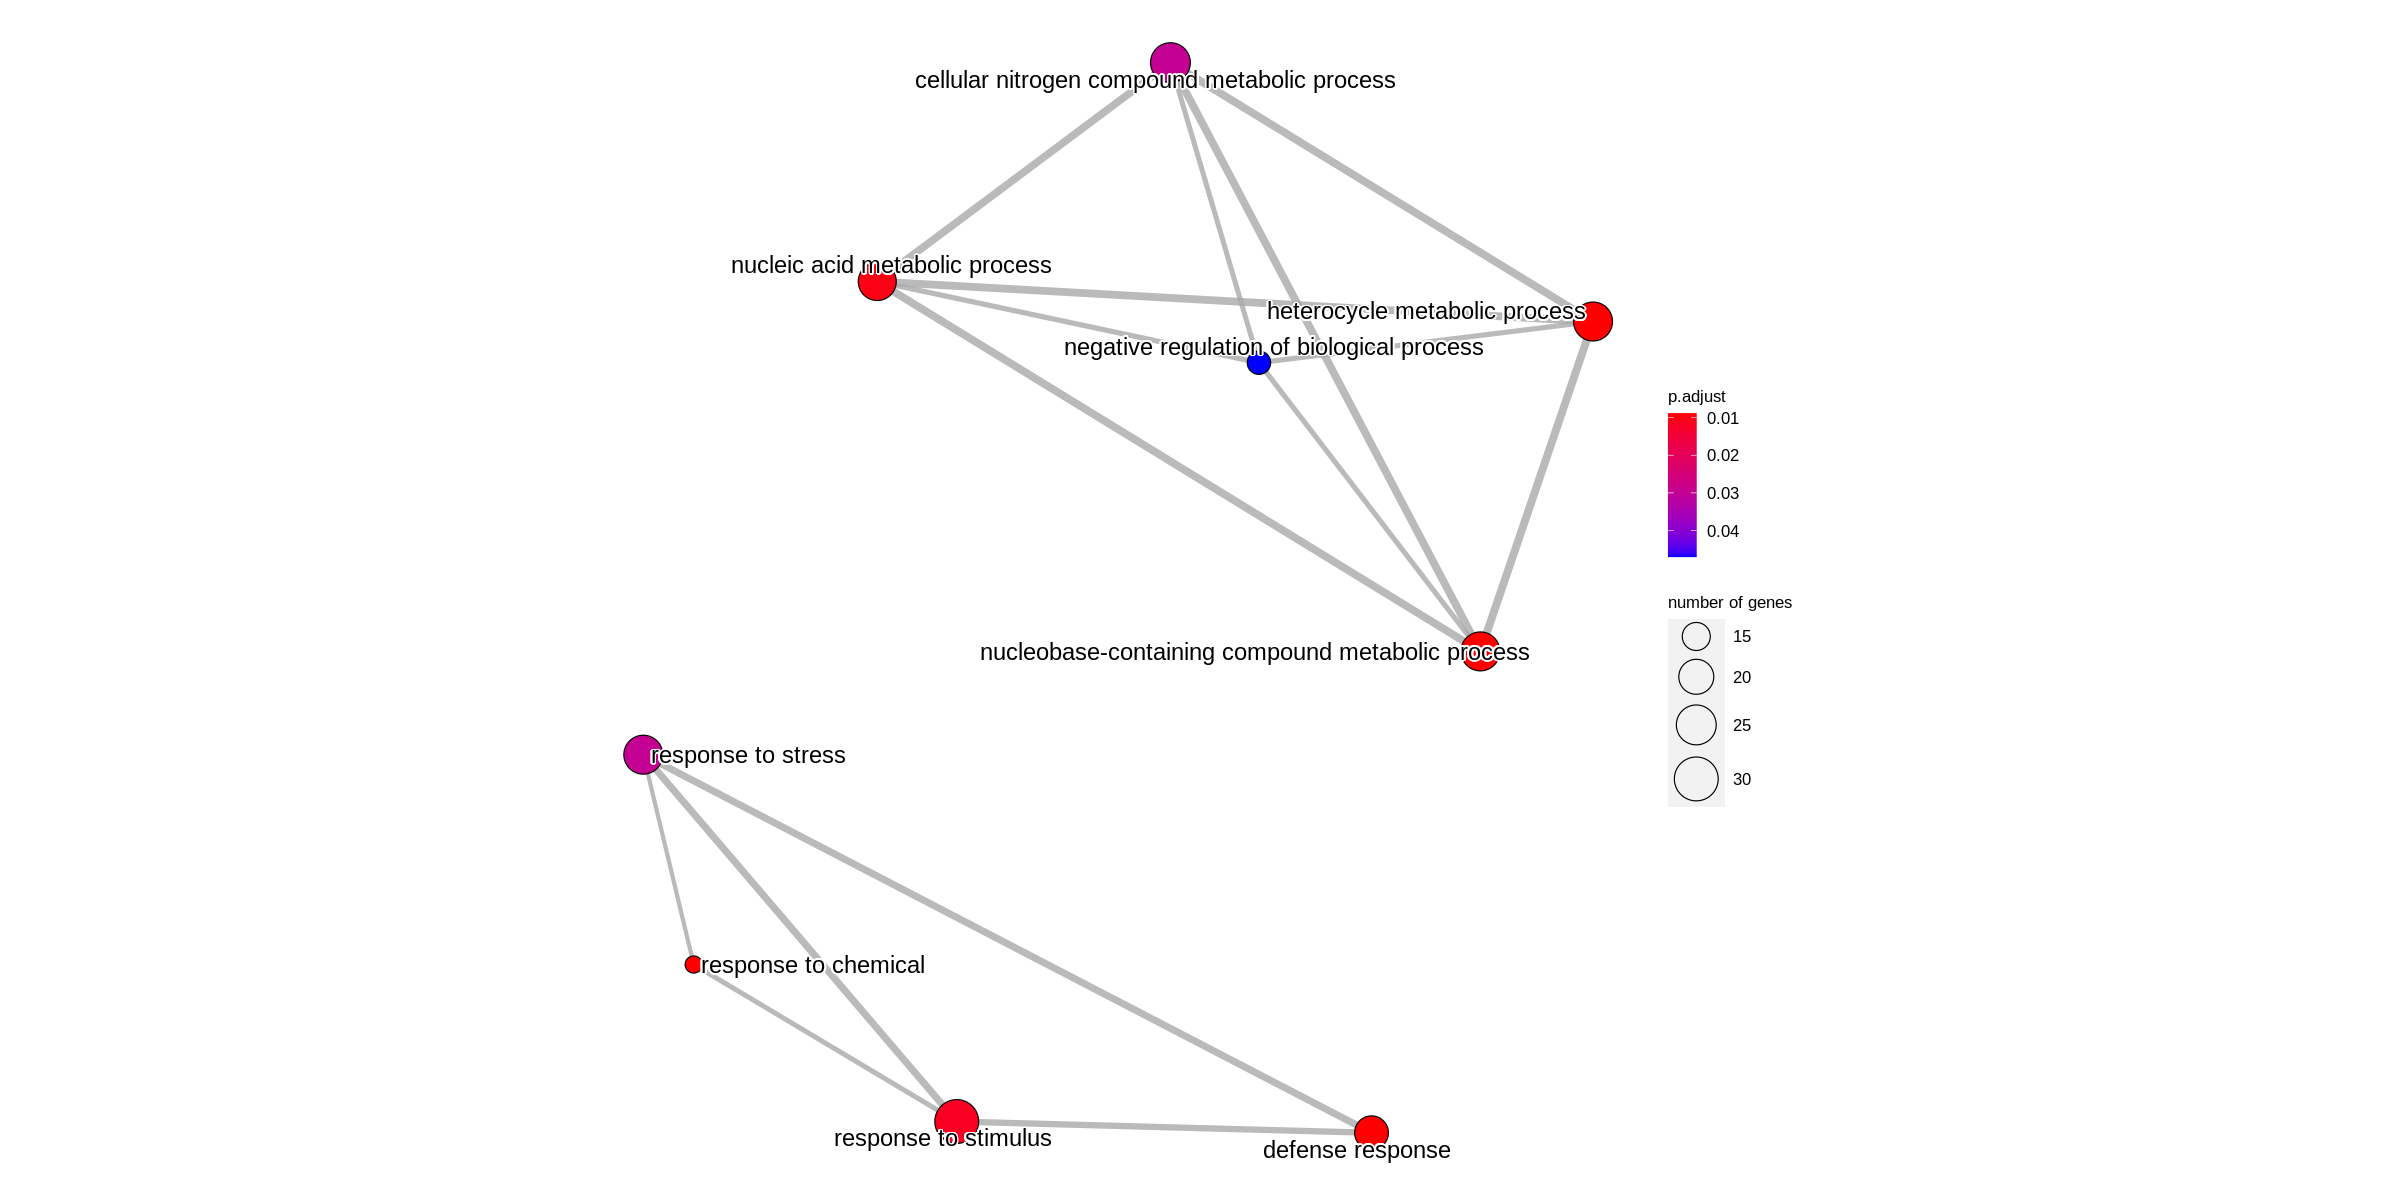

In [89]:
#Enrichment map
resGO_termsim <- pairwise_termsim(resGO)

p1 <- emapplot(resGO_termsim)
p2 <- emapplot(resGO_termsim, cex_category=1.5)
p3 <- emapplot(resGO_termsim, layout="kk")
p4 <- emapplot(resGO_termsim, cex_category=1.5,layout="kk") 

p4
#cowplot::plot_grid(p1, p2, p3, p4, ncol=2, labels=LETTERS[1:4])

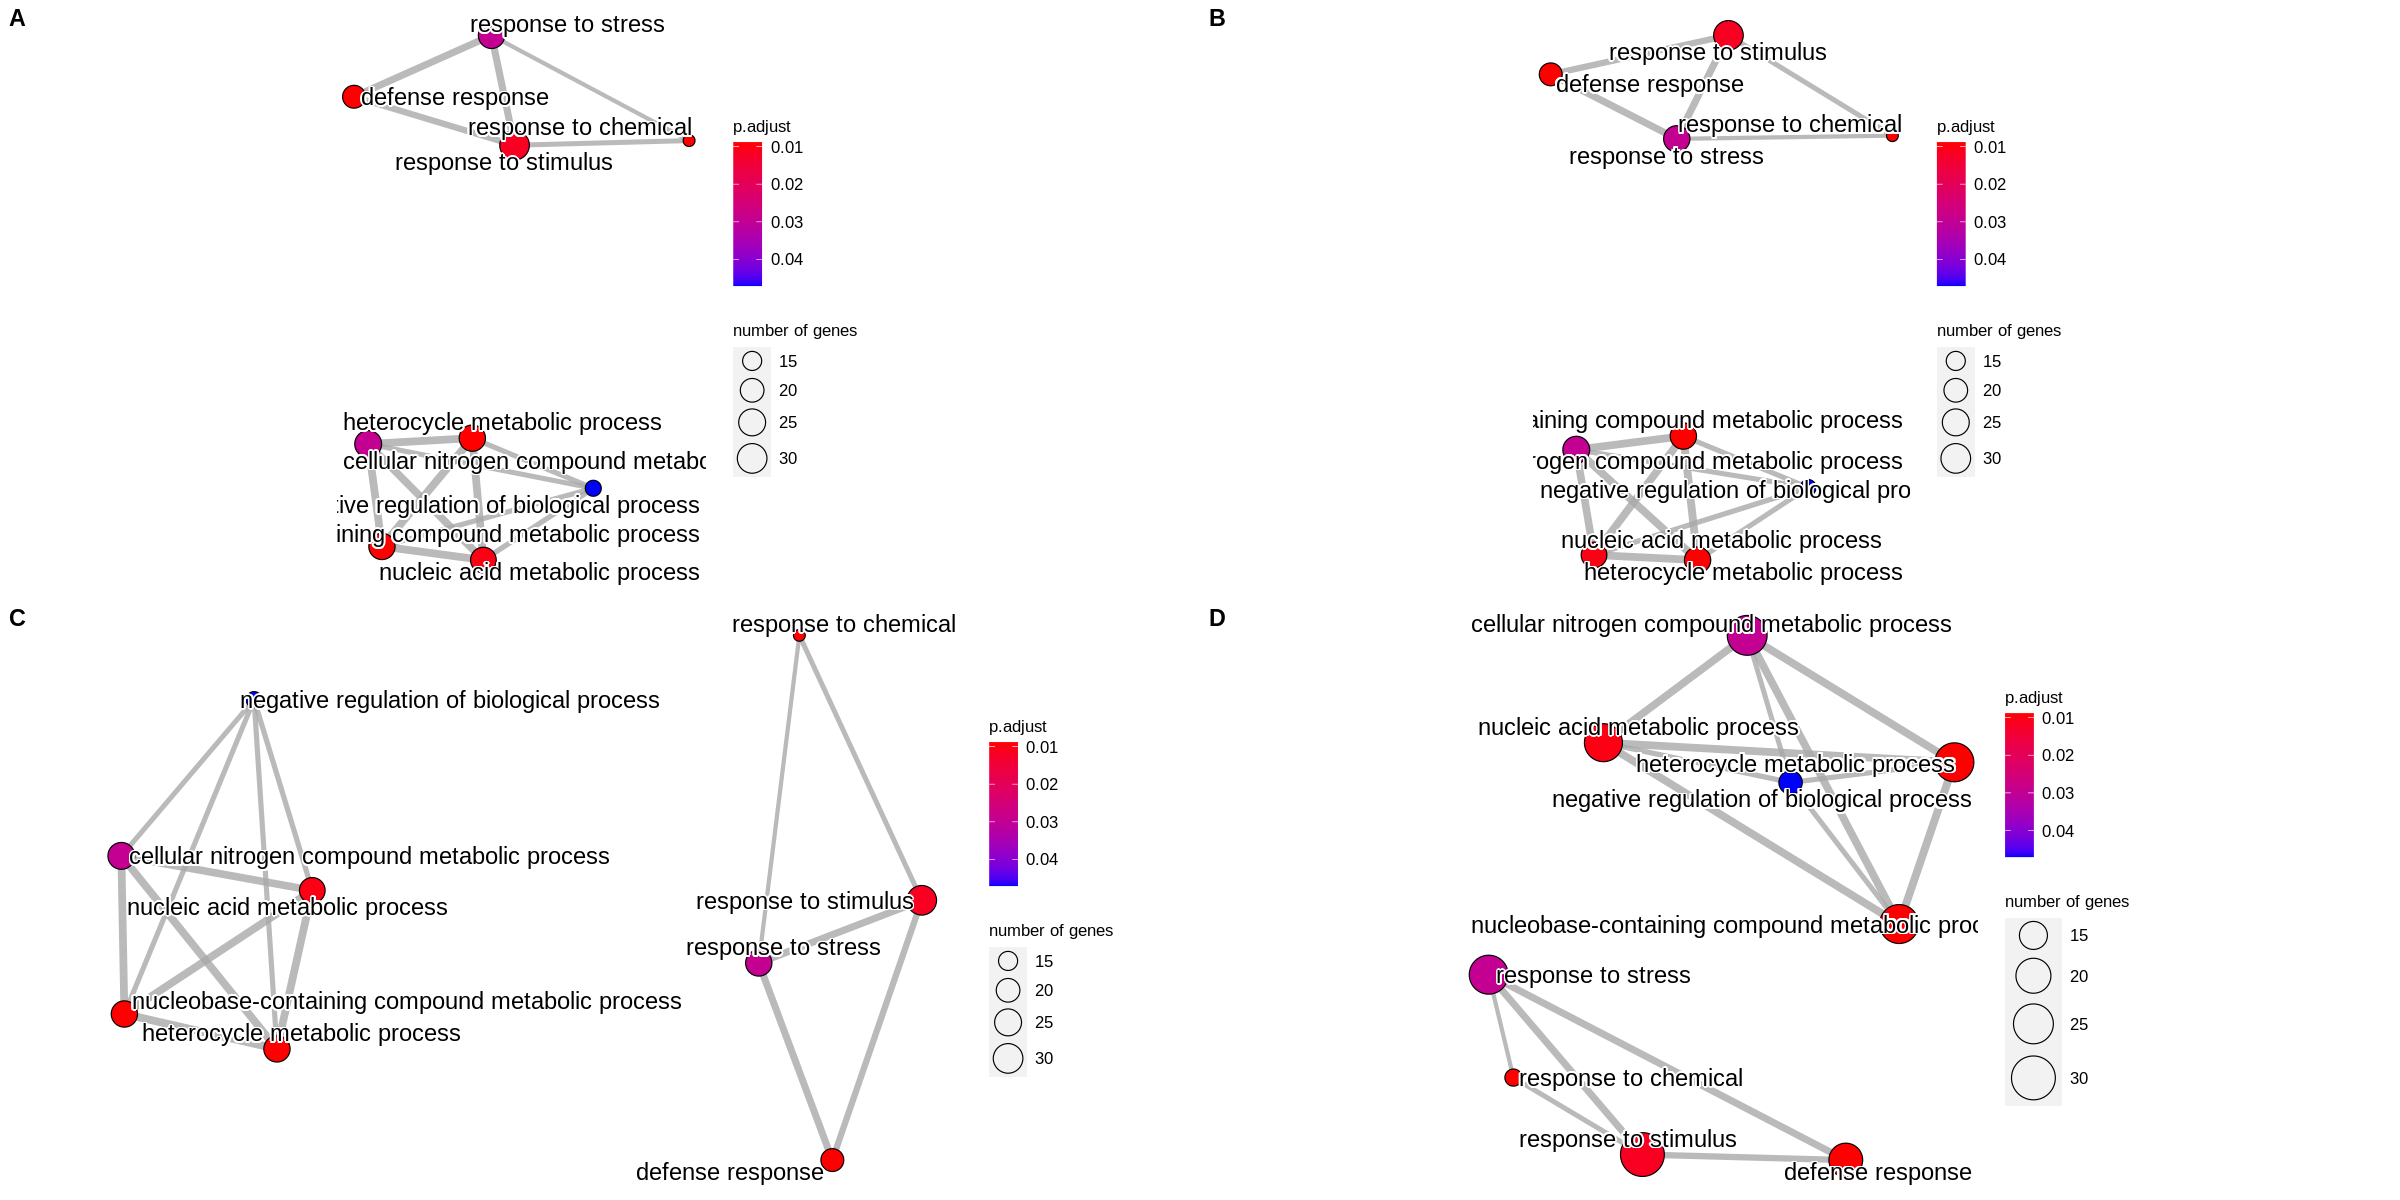

In [90]:
#Biological theme comparison

#-> could use this to display differences between
#-> up down; expanded vs compared species; all species...



#data(gcSample)
#xx <- compareCluster(gcSample, fun="enrichKEGG",
#                     organism="hsa", pvalueCutoff=0.05)
#xx <- pairwise_termsim(xx)                     
p1 <- emapplot(resGO_termsim)
p2 <- emapplot(resGO_termsim, legend_n=2) 
p3 <- emapplot(resGO_termsim, pie="count")
p4 <- emapplot(resGO_termsim, pie="count", cex_category=1.5, layout="kk")
cowplot::plot_grid(p1, p2, p3, p4, ncol=2, labels=LETTERS[1:4])

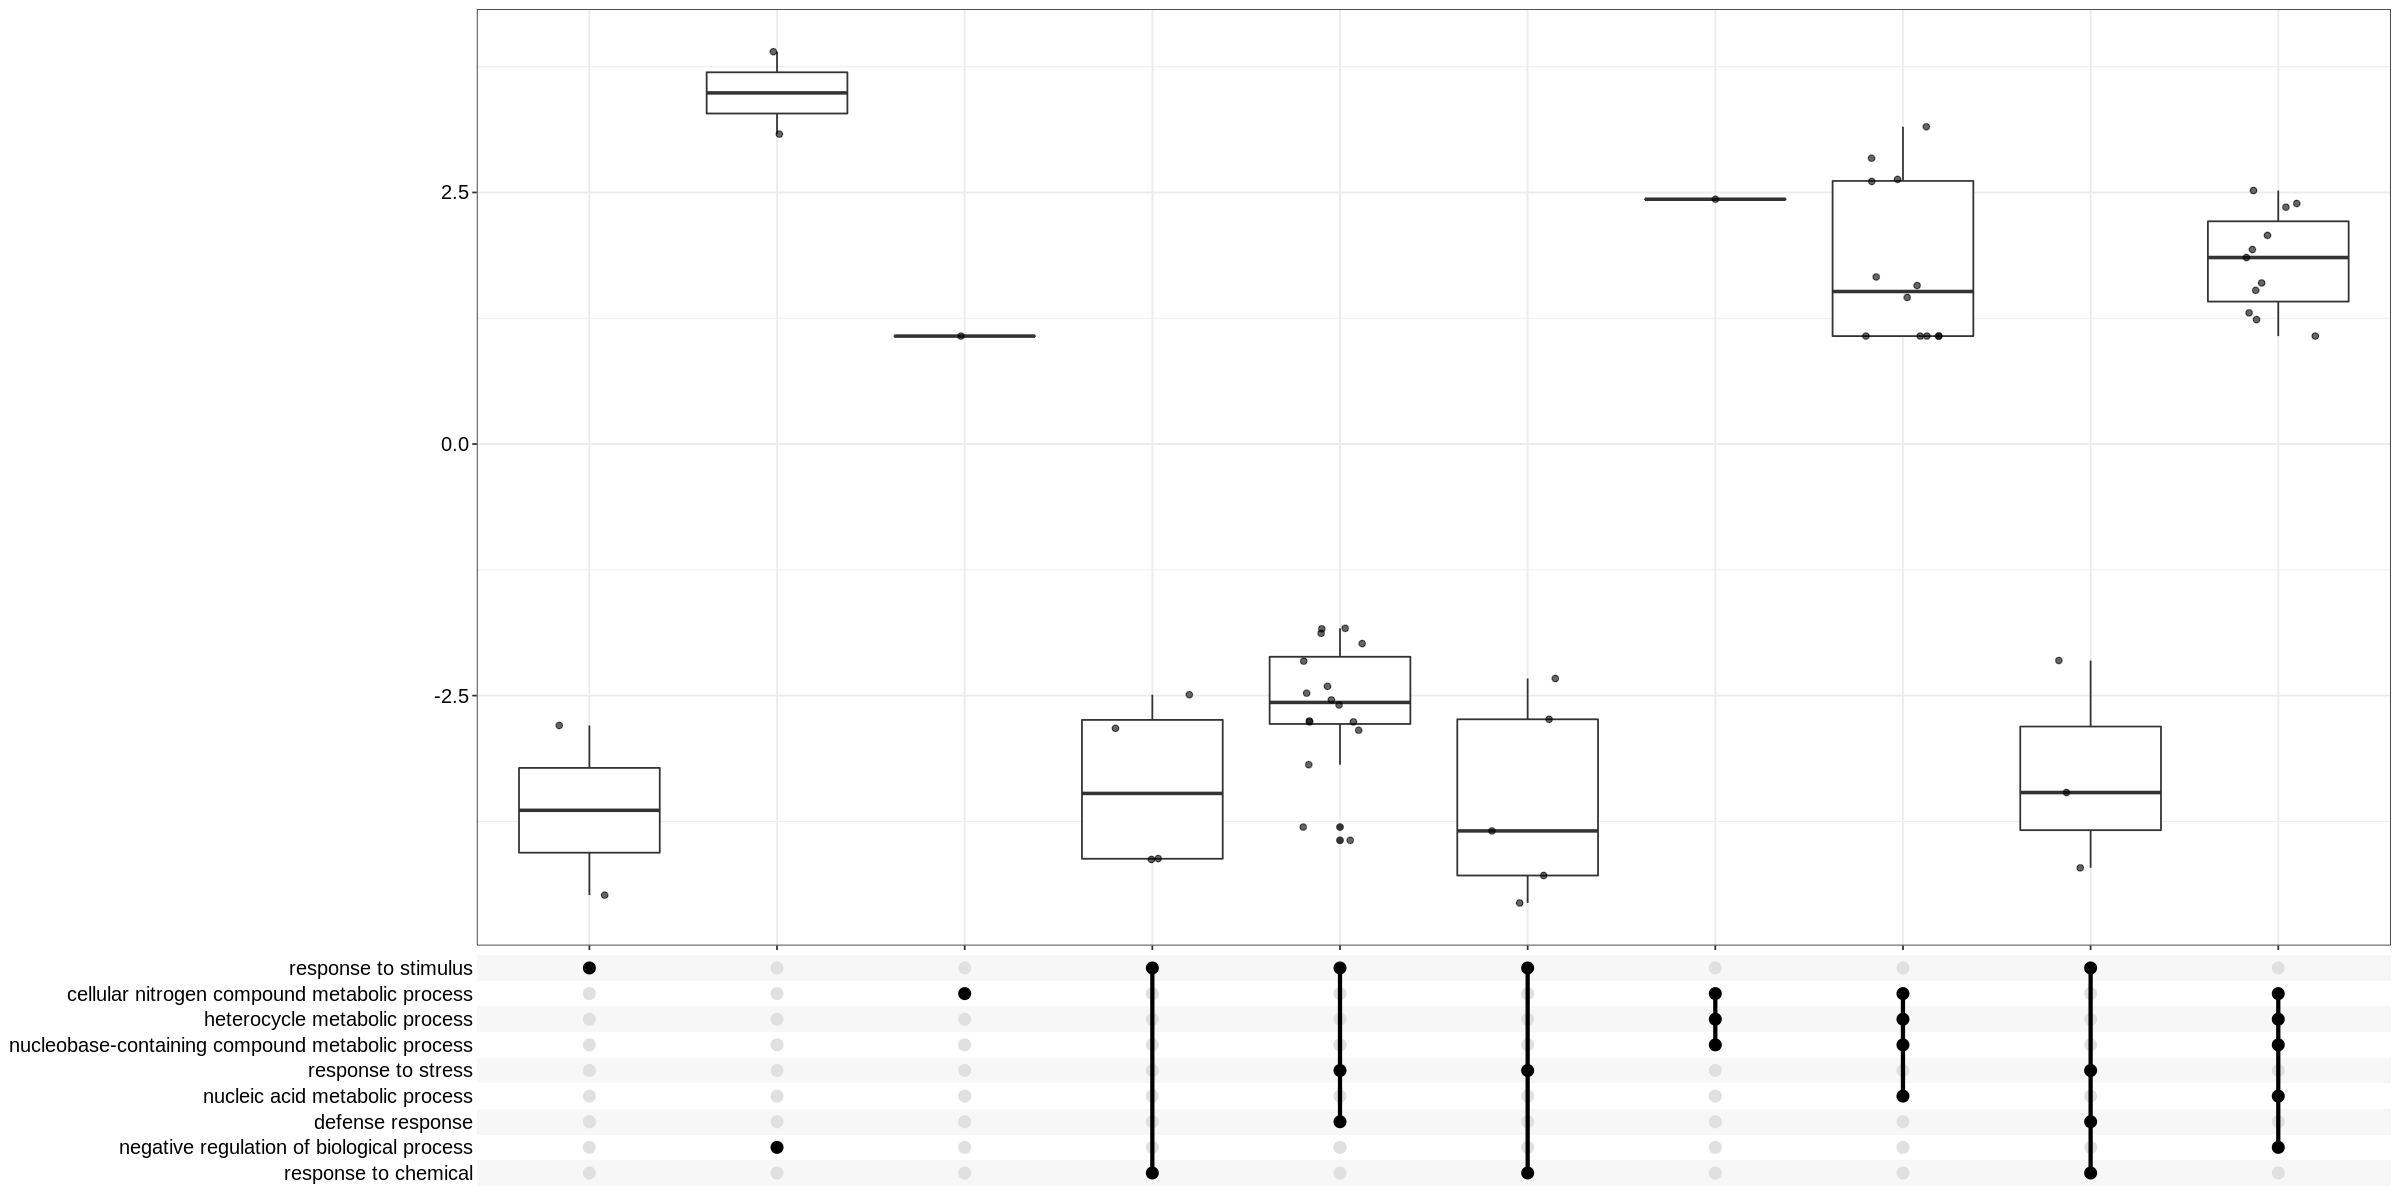

In [91]:
#The upsetplot is an alternative to cnetplot for visualizing the complex association between genes and gene sets. 
#It emphasizes the gene overlapping among different gene sets.
#For over-representation analysis, upsetplot will calculate the overlaps among different gene sets

# UpSetR plot
upsetplot(resGO)

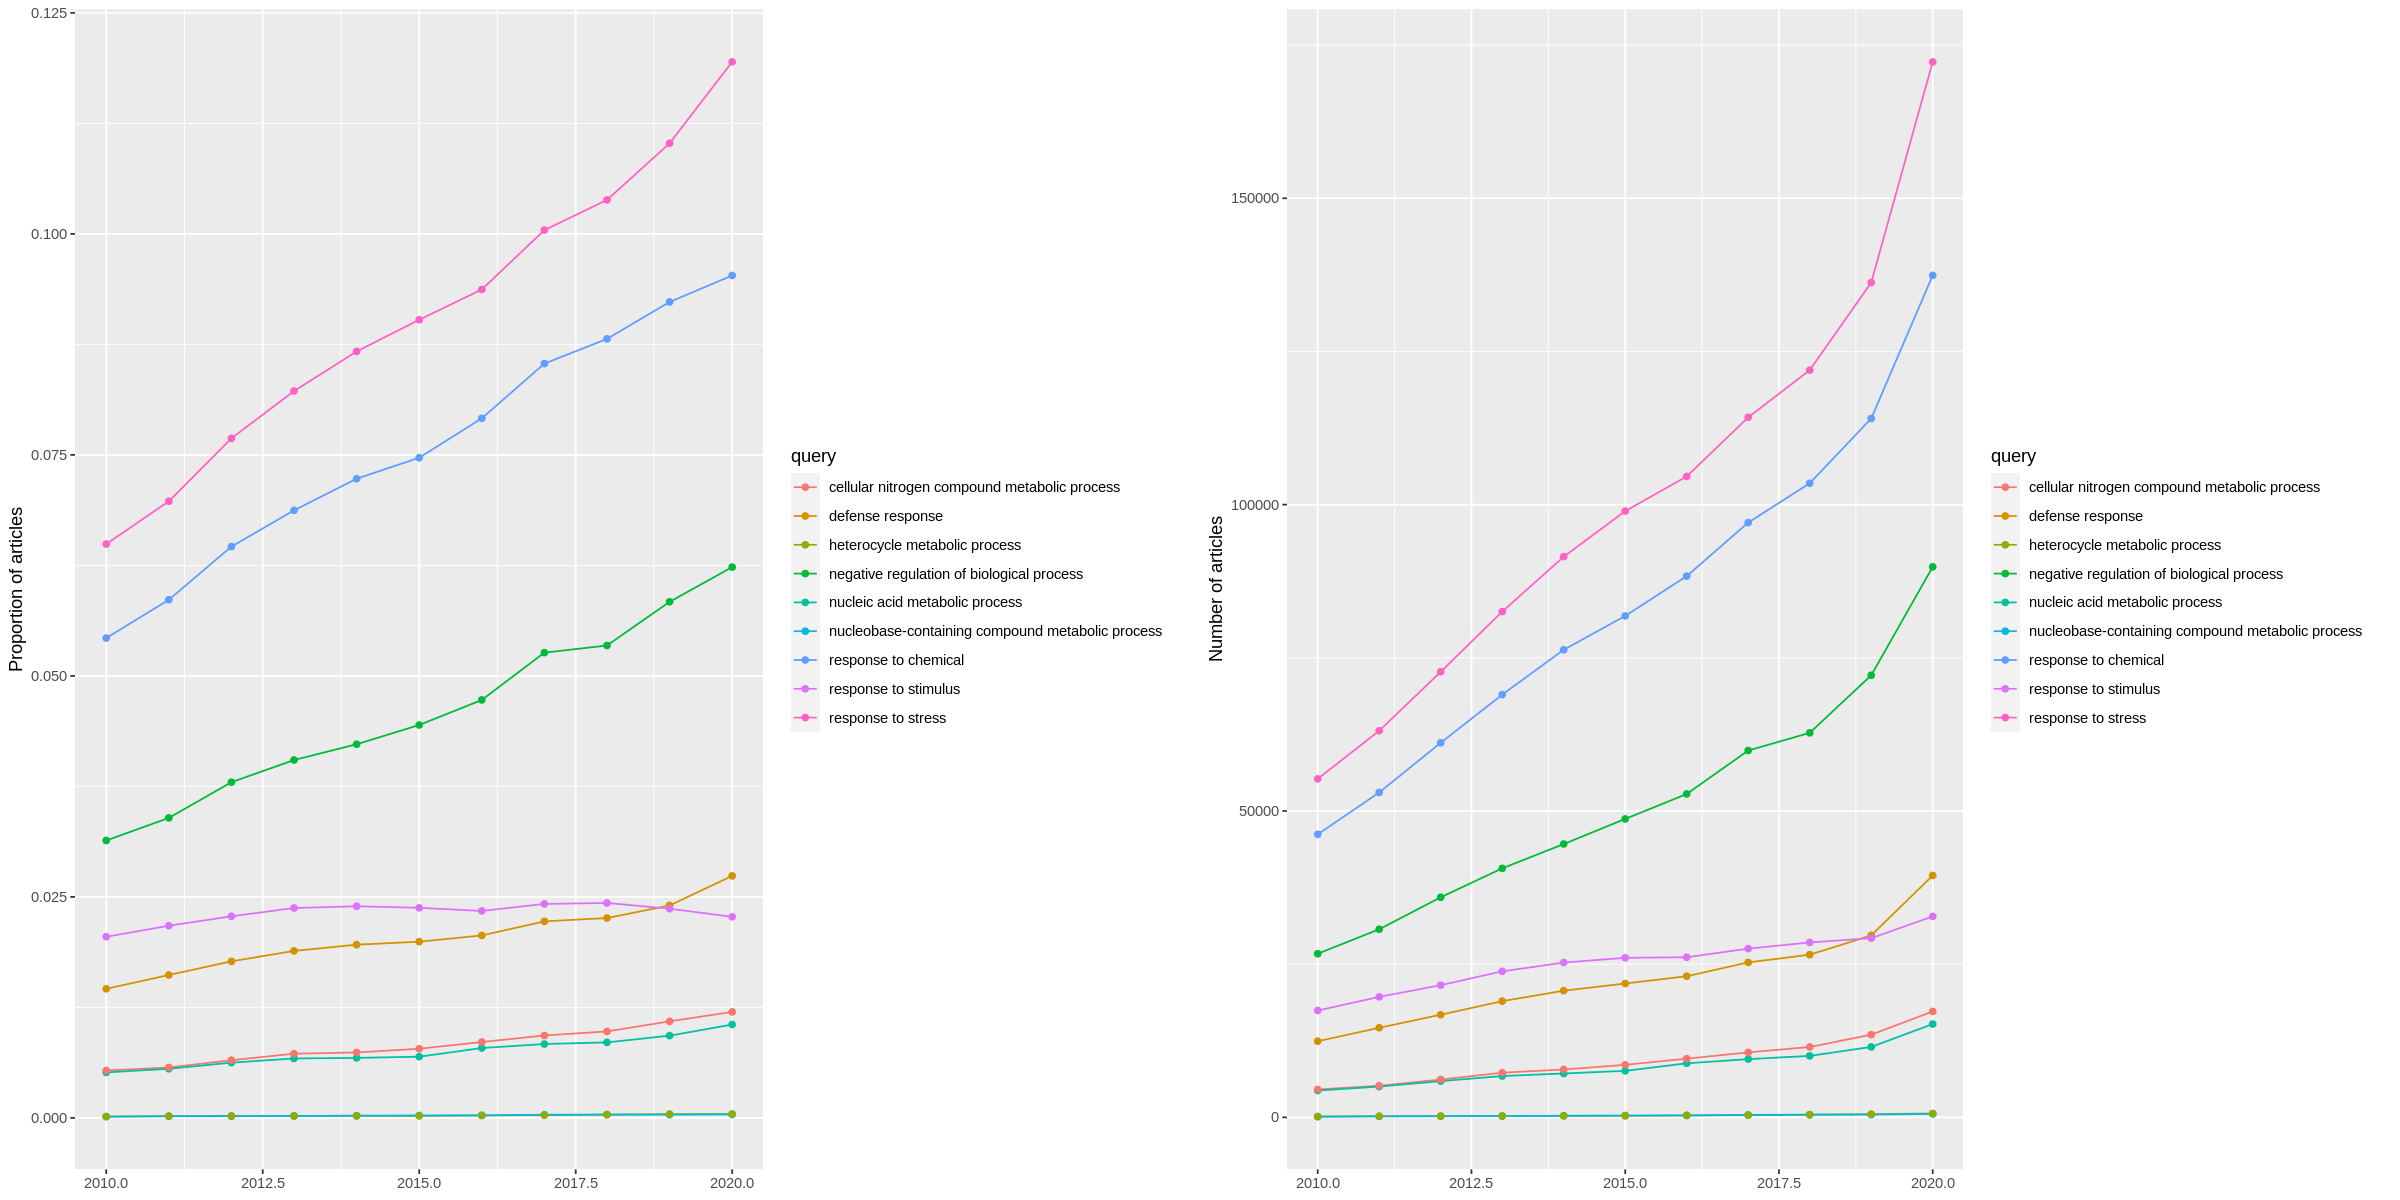

In [95]:
# pubmed trend of enriched terms
#One of the problem of enrichment analysis is to find pathways for further investigation. 
#Here, we provide pmcplot function to plot the number/proportion of publications trend based on the query result from PubMed Central. 
#Of course, users can use pmcplot in other scenarios. 
#All text that can be queried on PMC is valid as input of pmcplot.

terms <- resGO$Description[1:9]
p <- pmcplot(terms, 2010:2020)
p2 <- pmcplot(terms, 2010:2020, proportion=FALSE)
plot_grid(p, p2, ncol=2)

## GSEA with clusterProfiler

#### ridgeline plot for expression distribution of GSEA result
The ridgeplot will visualize expression distributions of core enriched genes for GSEA enriched categories. It helps users to interpret up/down-regulated pathways.

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Picking joint bandwidth of 0.355



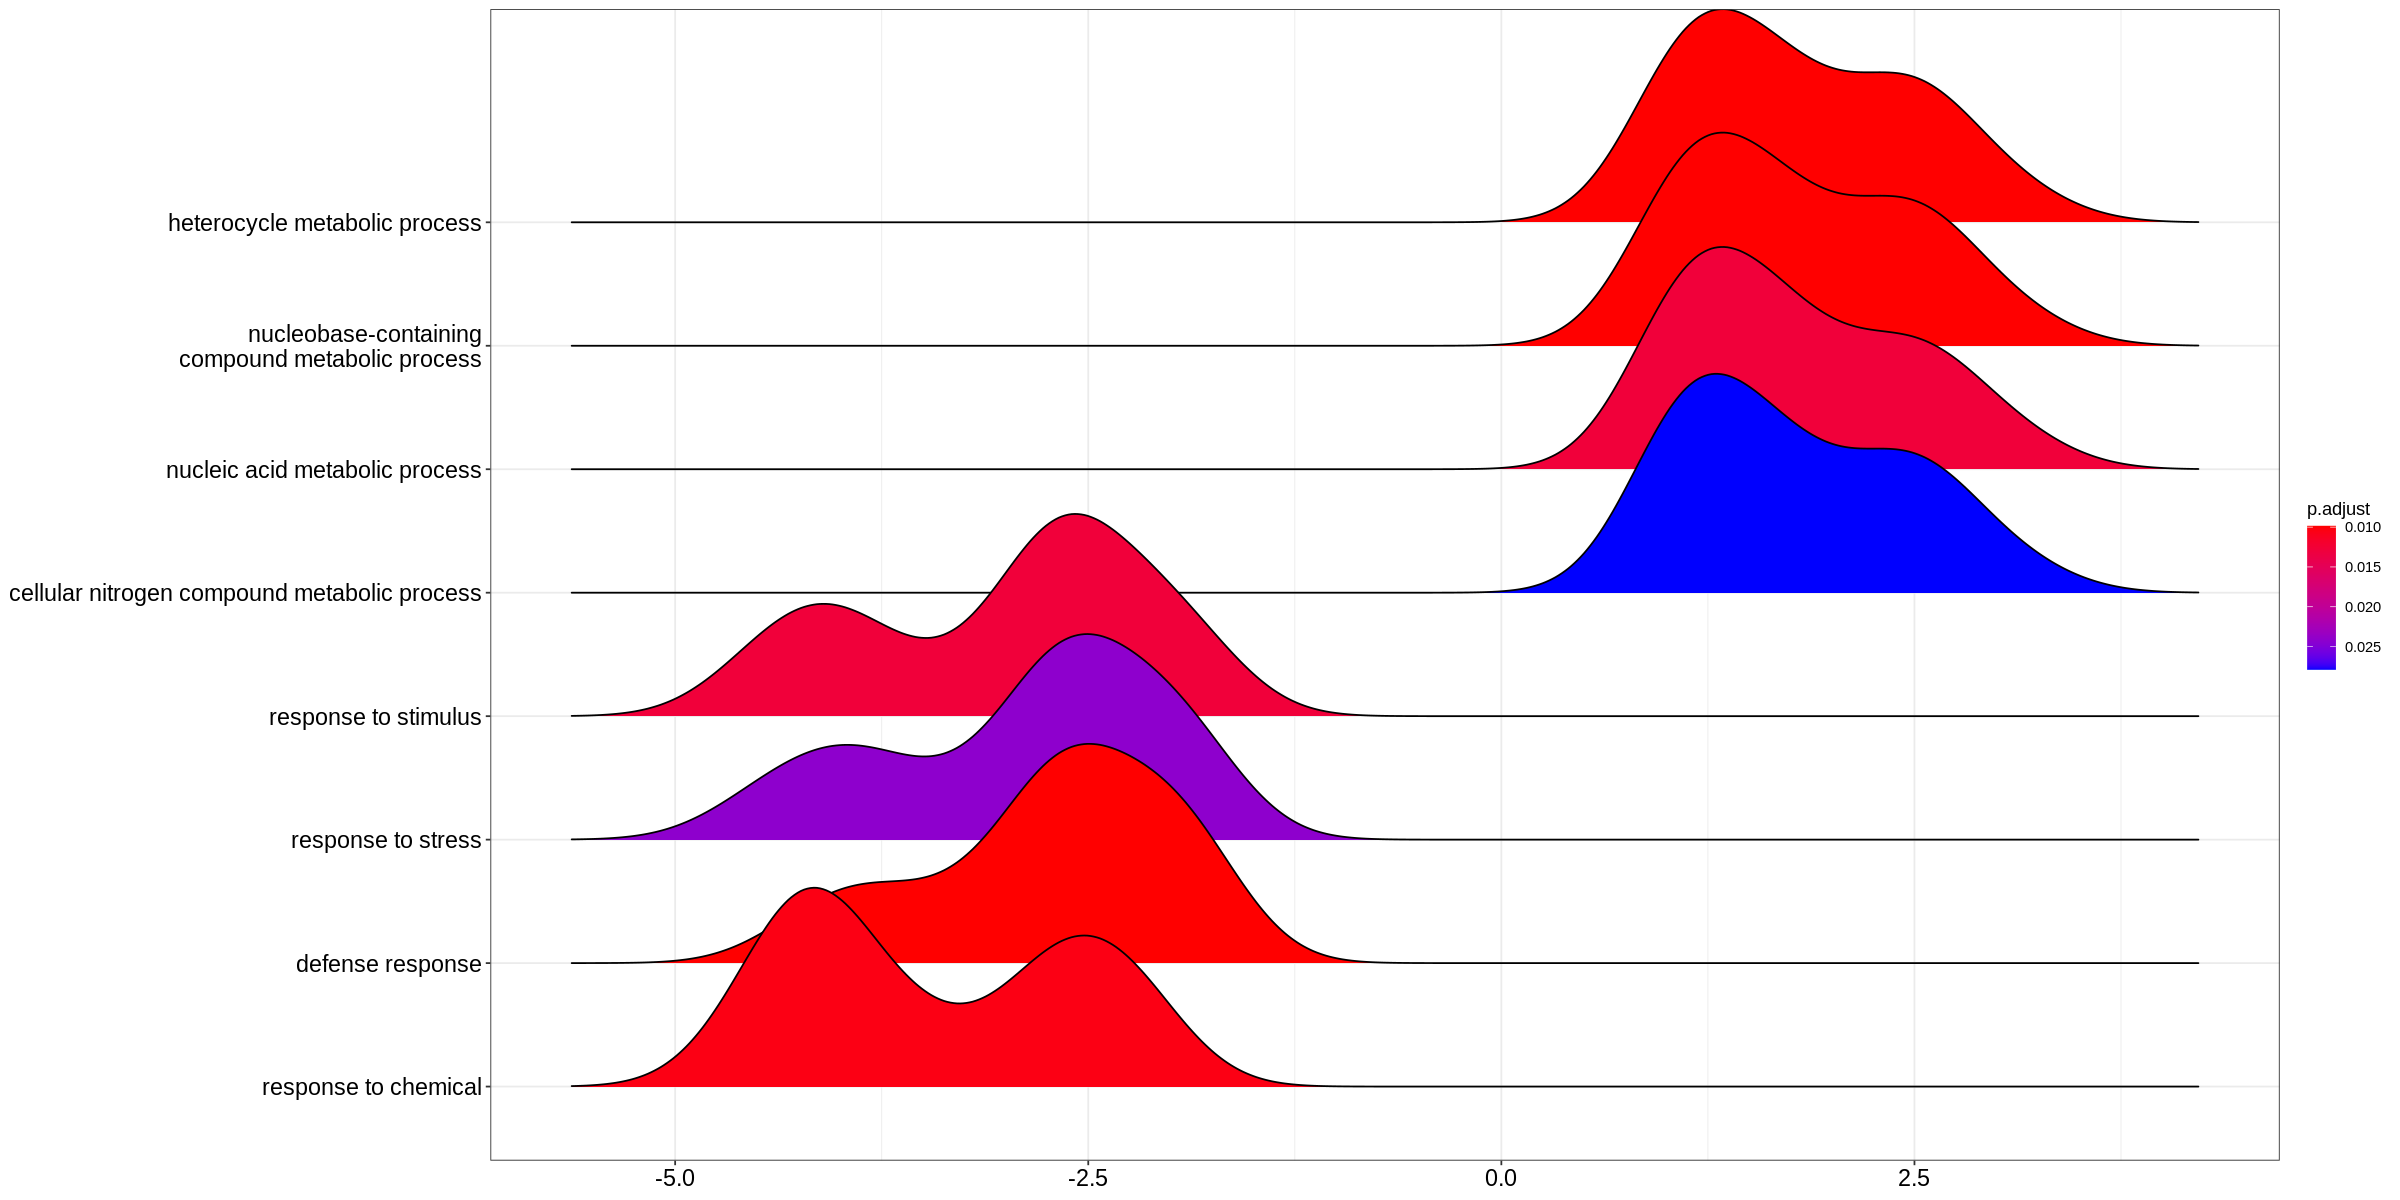

In [176]:
ridgeplot(resGO)

#### Running score and preranked list of GSEA result
Running score and preranked list are traditional methods for visualizing GSEA result. The enrichplot package supports both of them to visualize the distribution of the gene set and the enrichment score.

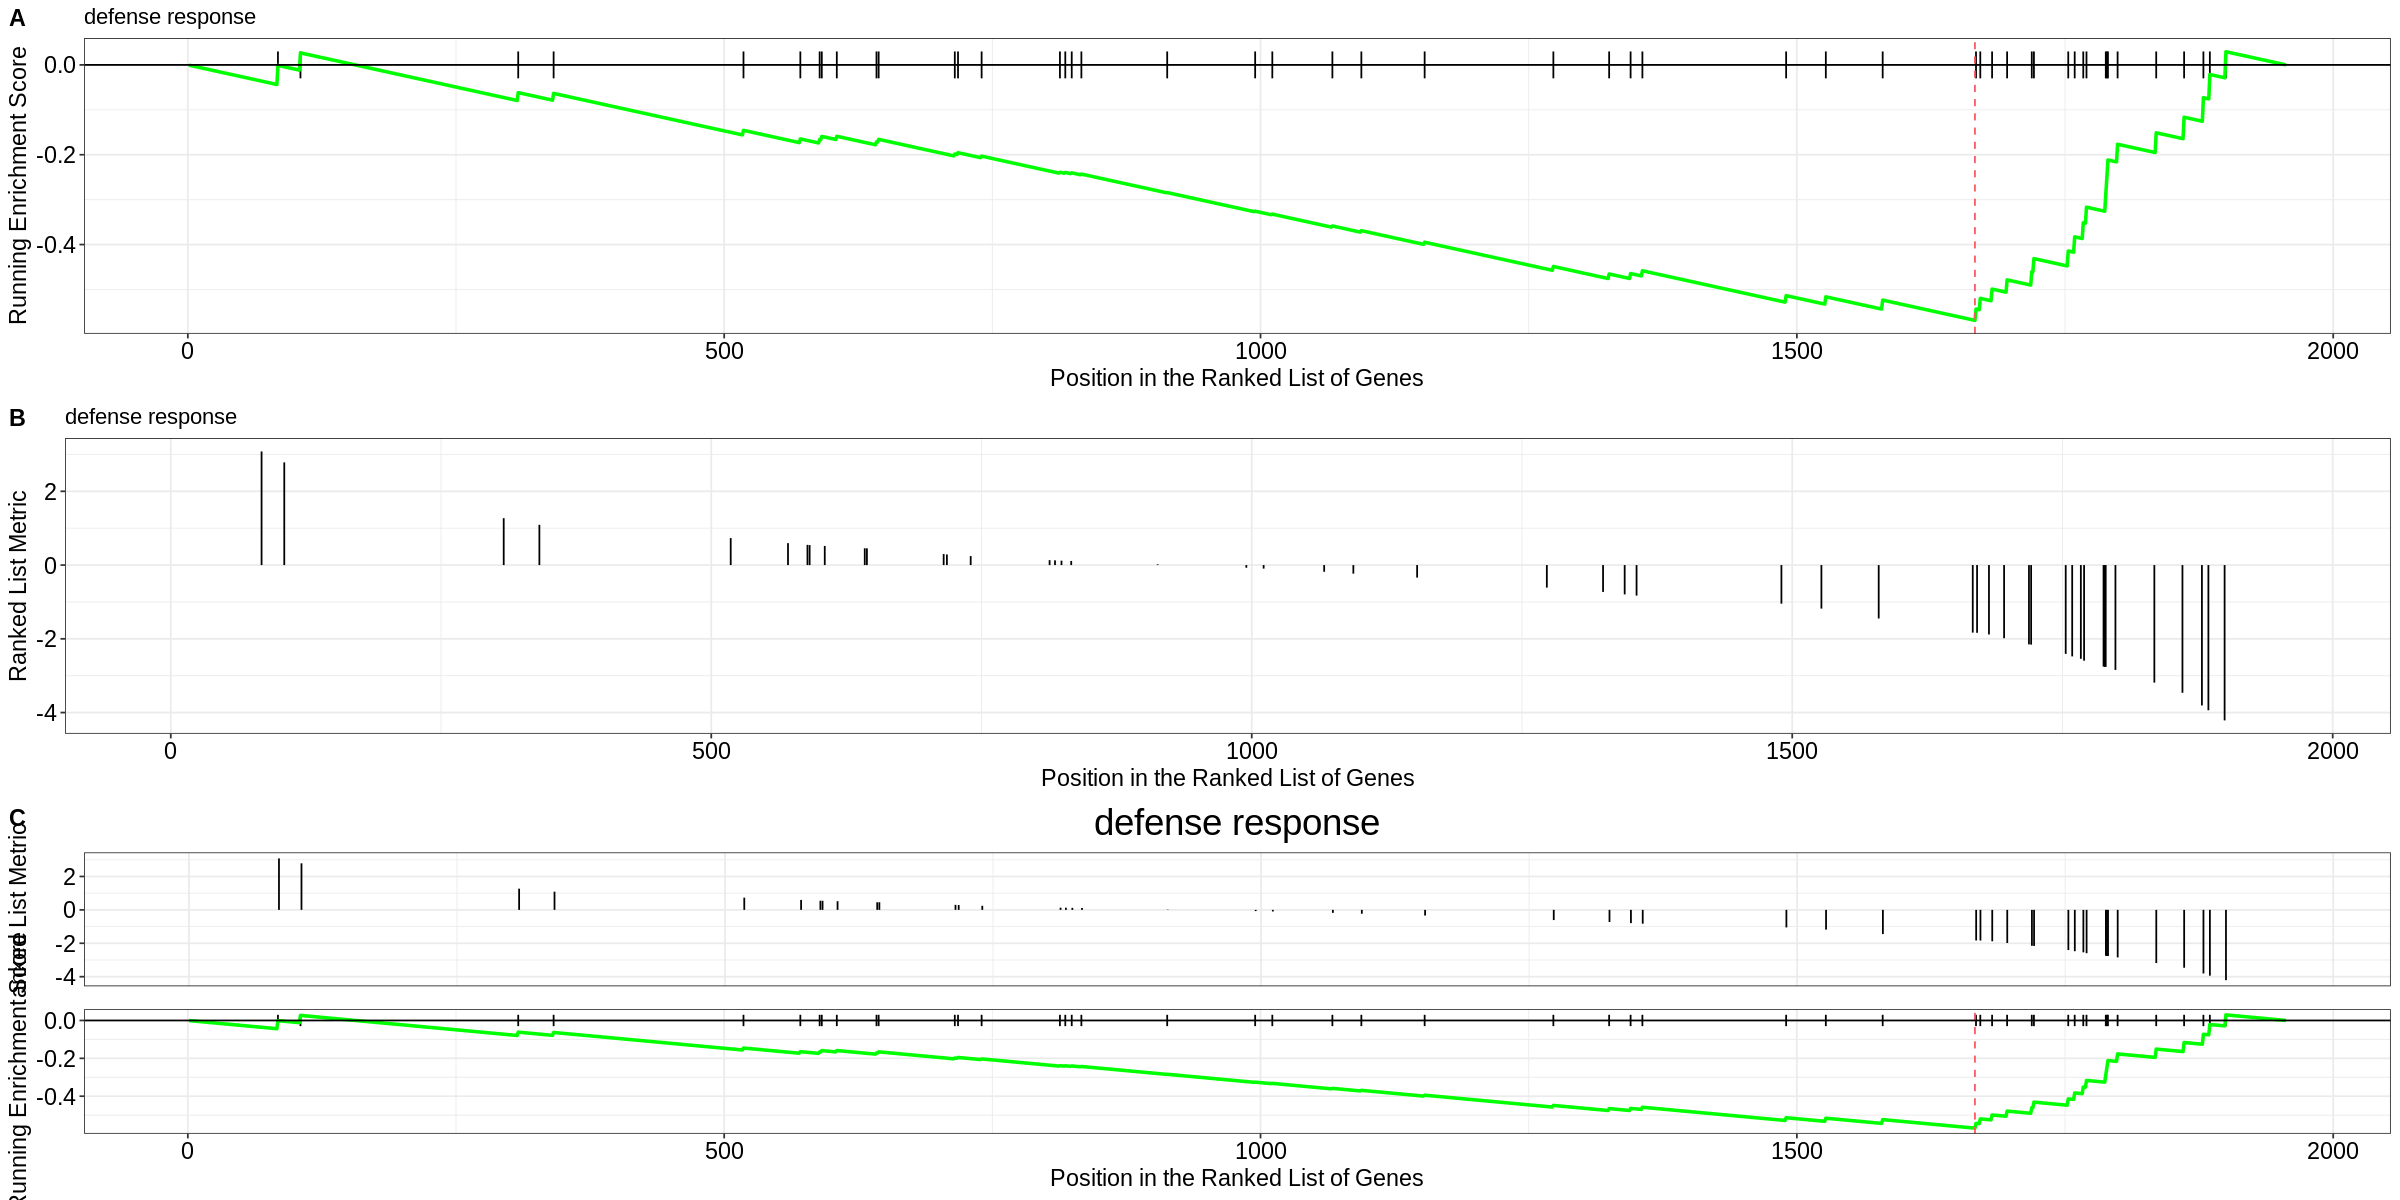

In [177]:
p1 <- gseaplot(resGO, geneSetID = 1, by = "runningScore", title = resGO$Description[1])
p2 <- gseaplot(resGO, geneSetID = 1, by = "preranked", title = resGO$Description[1])
p3 <- gseaplot(resGO, geneSetID = 1, title = resGO$Description[1])
cowplot::plot_grid(p1, p2, p3, ncol=1, labels=LETTERS[1:3])

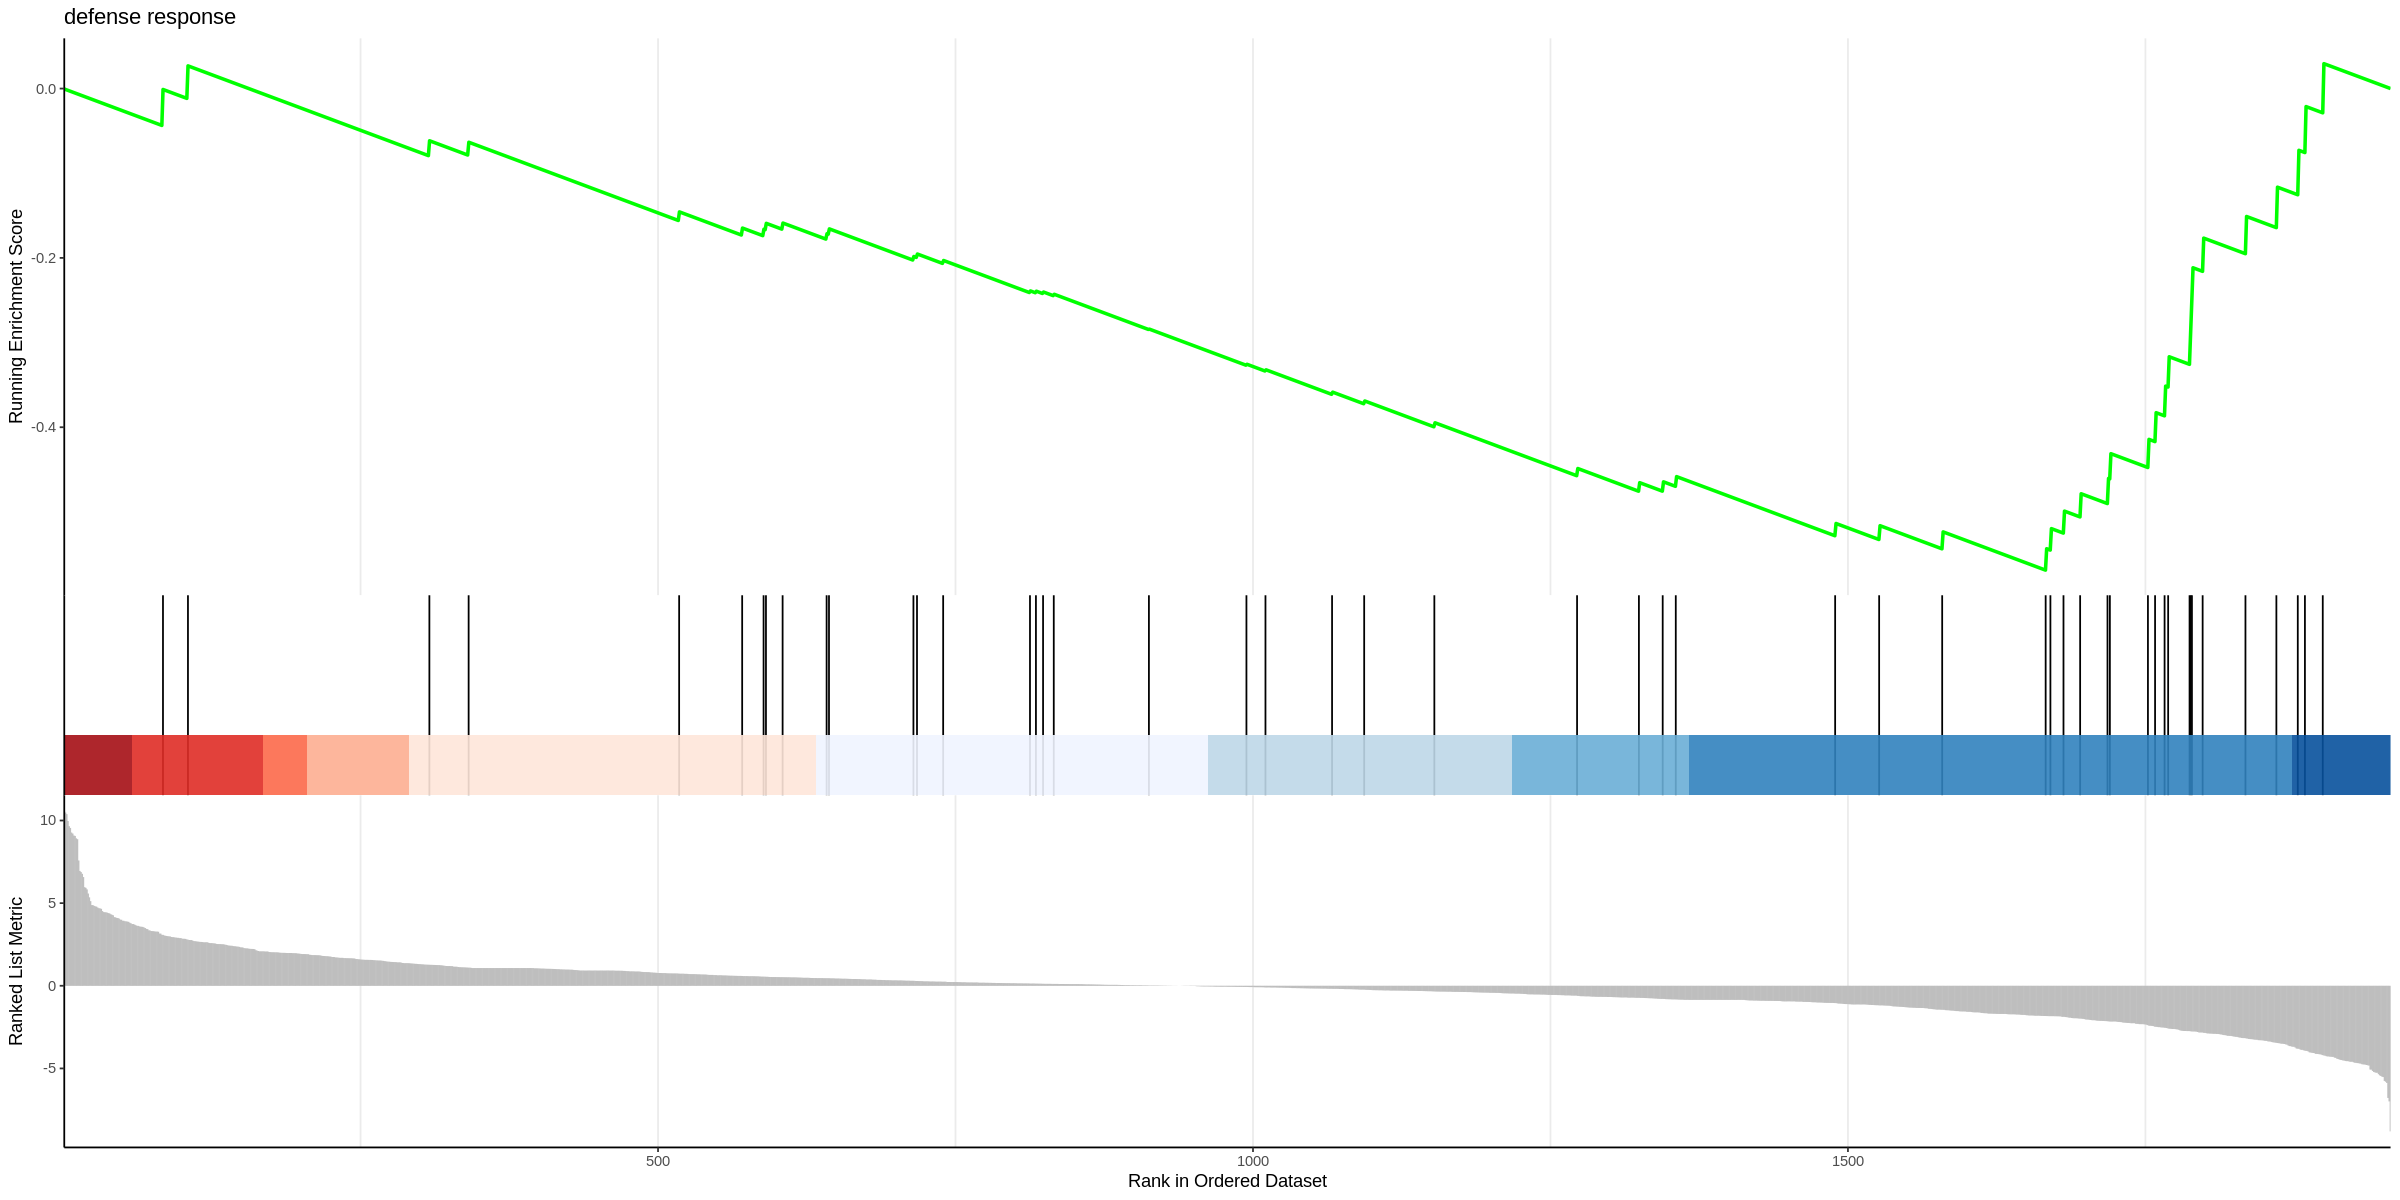

In [181]:
#Another method to plot GSEA result is the gseaplot2 function:
gseaplot2(resGO, geneSetID = 1, title = resGO$Description[1])

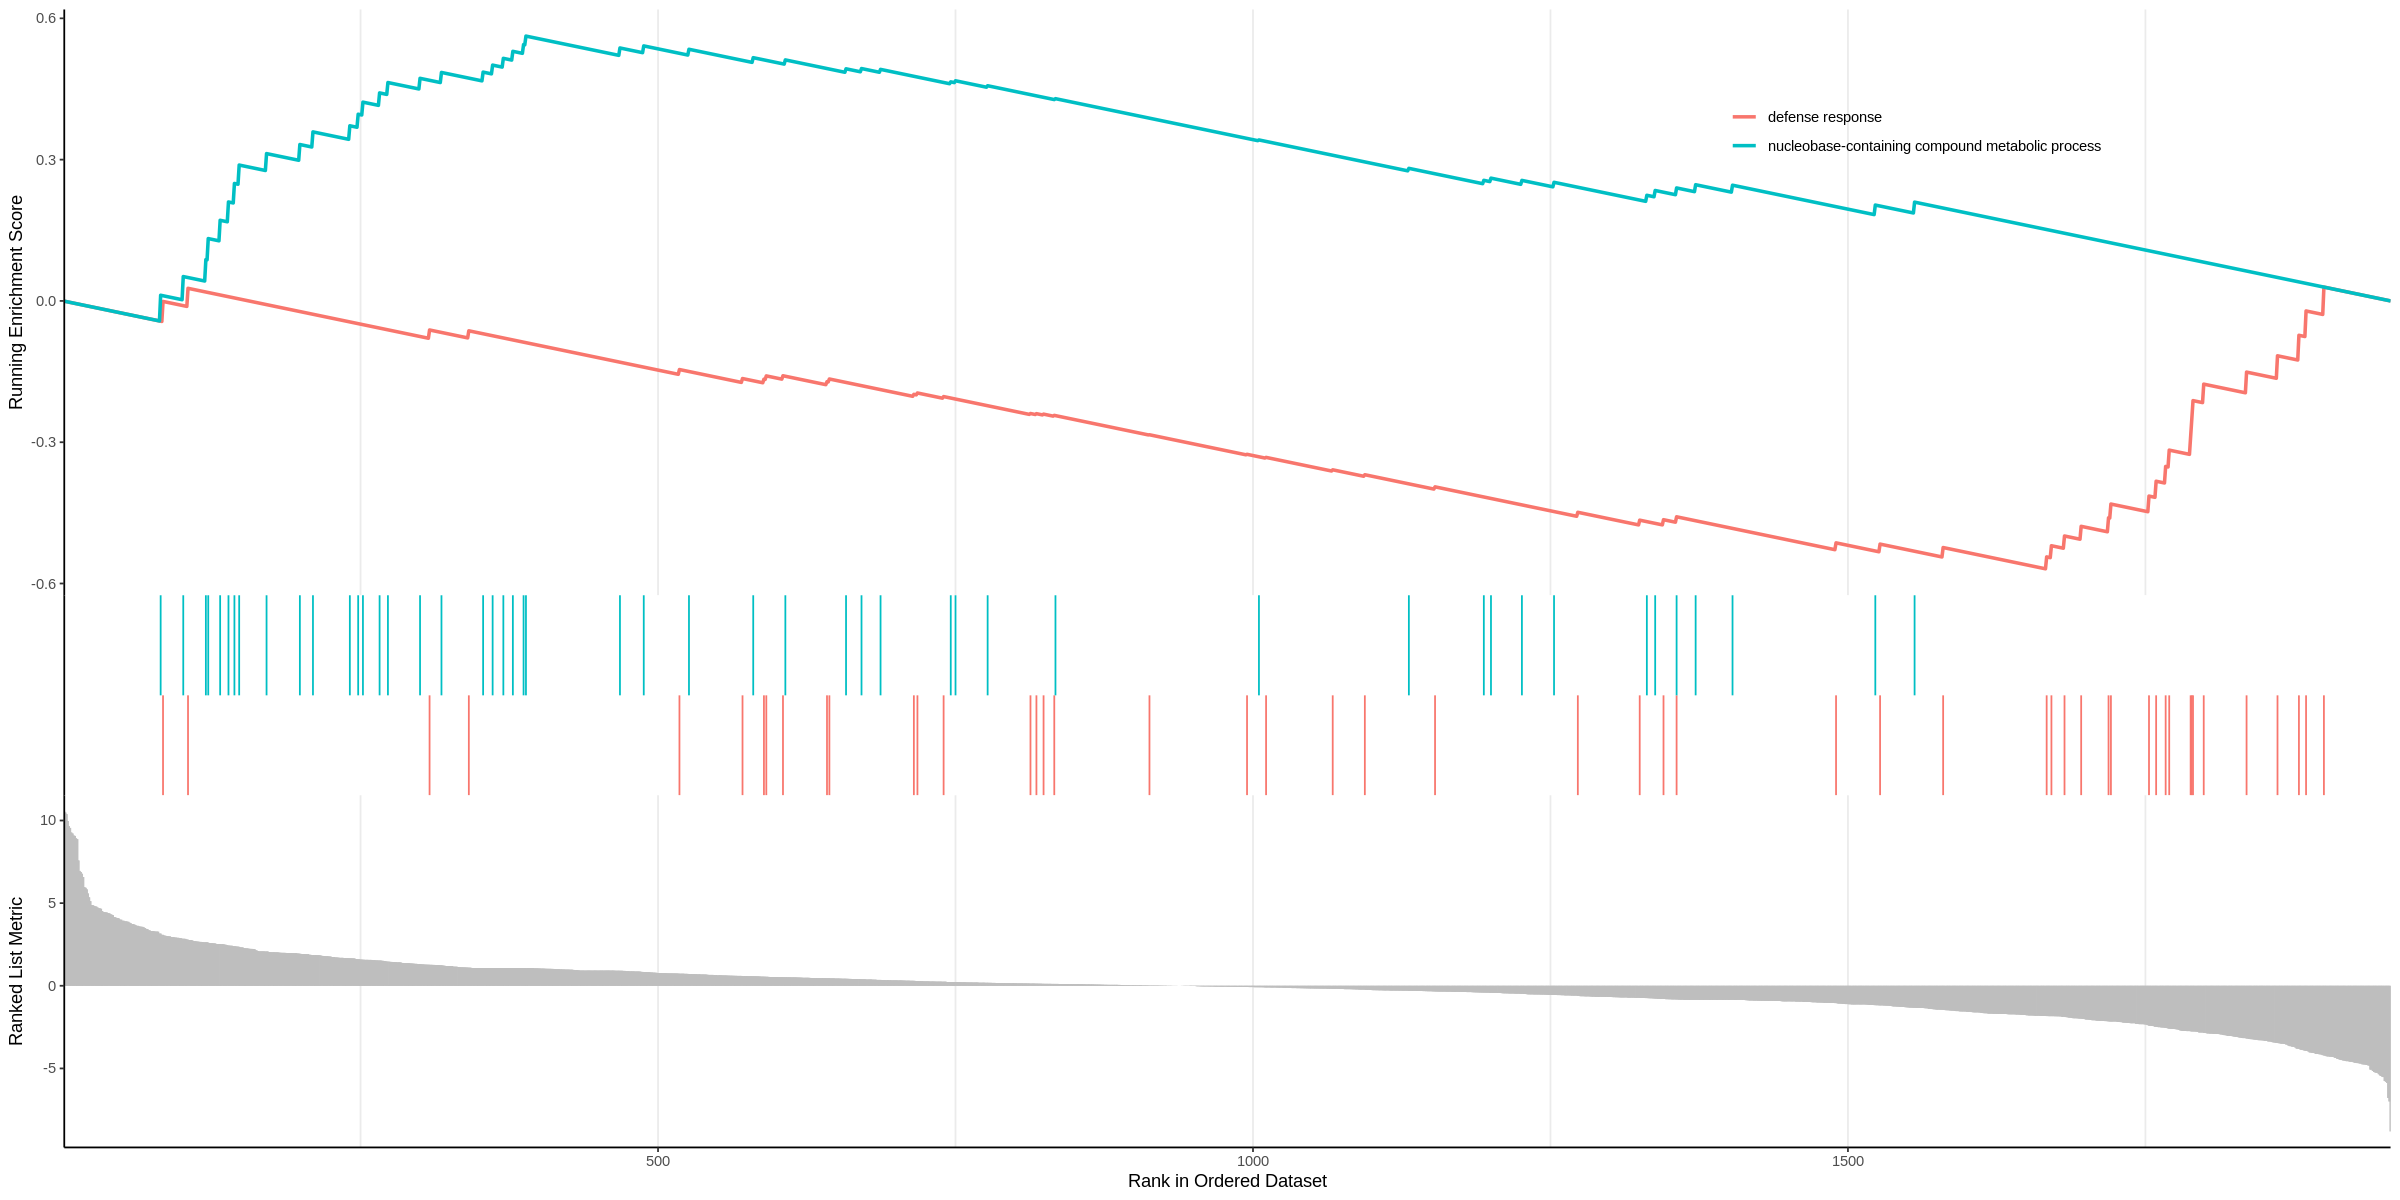

In [180]:
#The gseaplot2 also supports multile gene sets to be displayed on the same figure:
gseaplot2(resGO, geneSetID = 1:2)

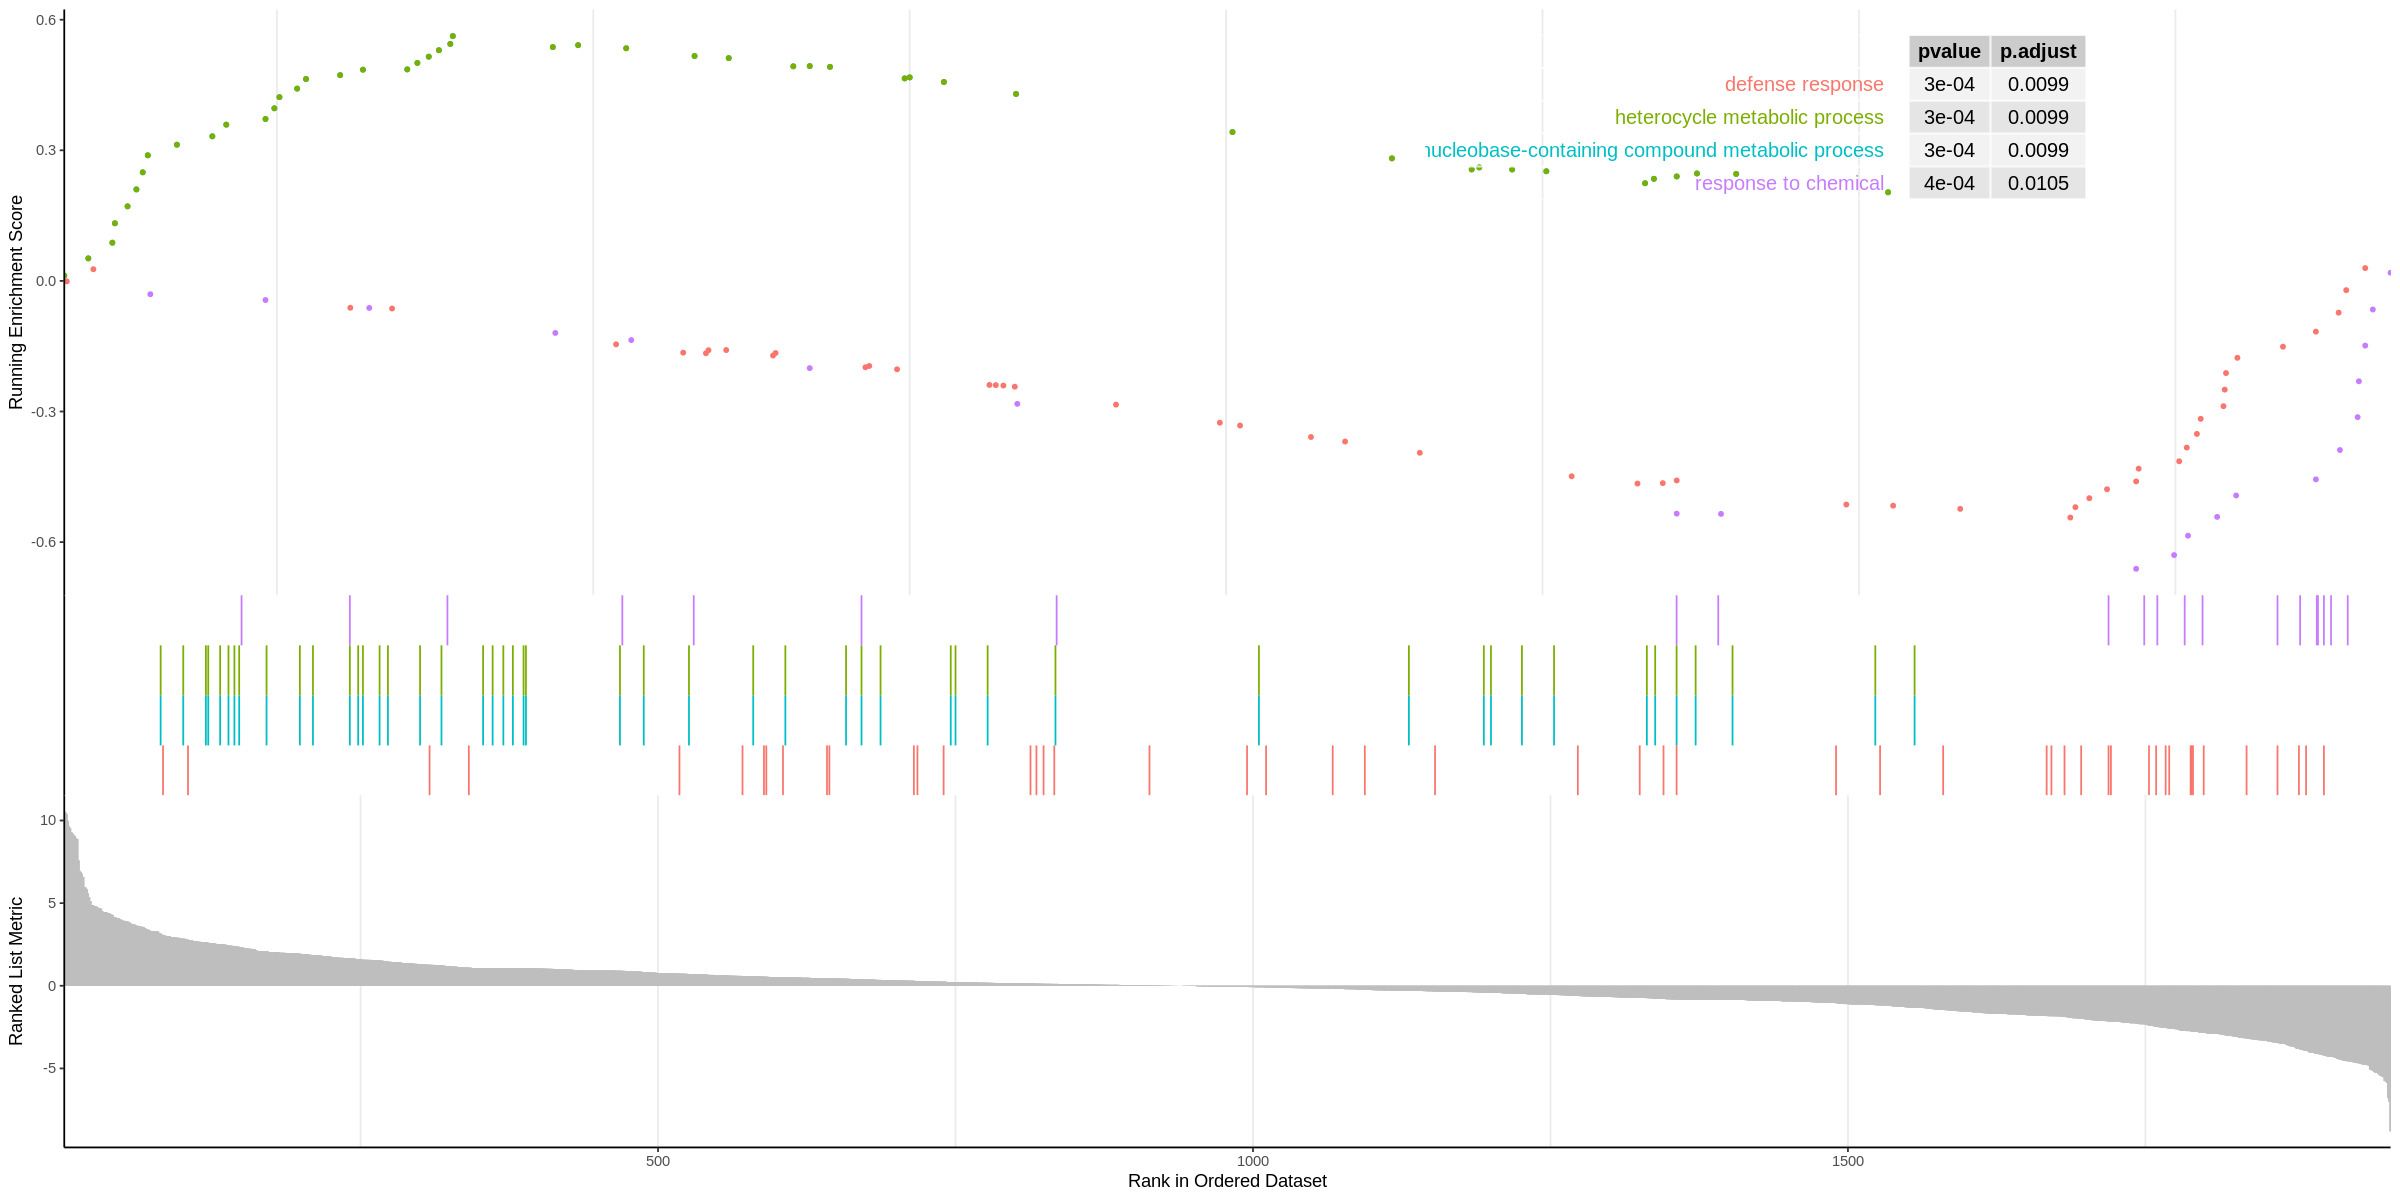

In [186]:
#Users can also displaying the pvalue table on the plot via pvalue_table parameter:
gseaplot2(resGO, geneSetID = 1:4, pvalue_table = TRUE,
          color = c("#E495A5", "#86B875", "#7DB0DD"), ES_geom = "dot")

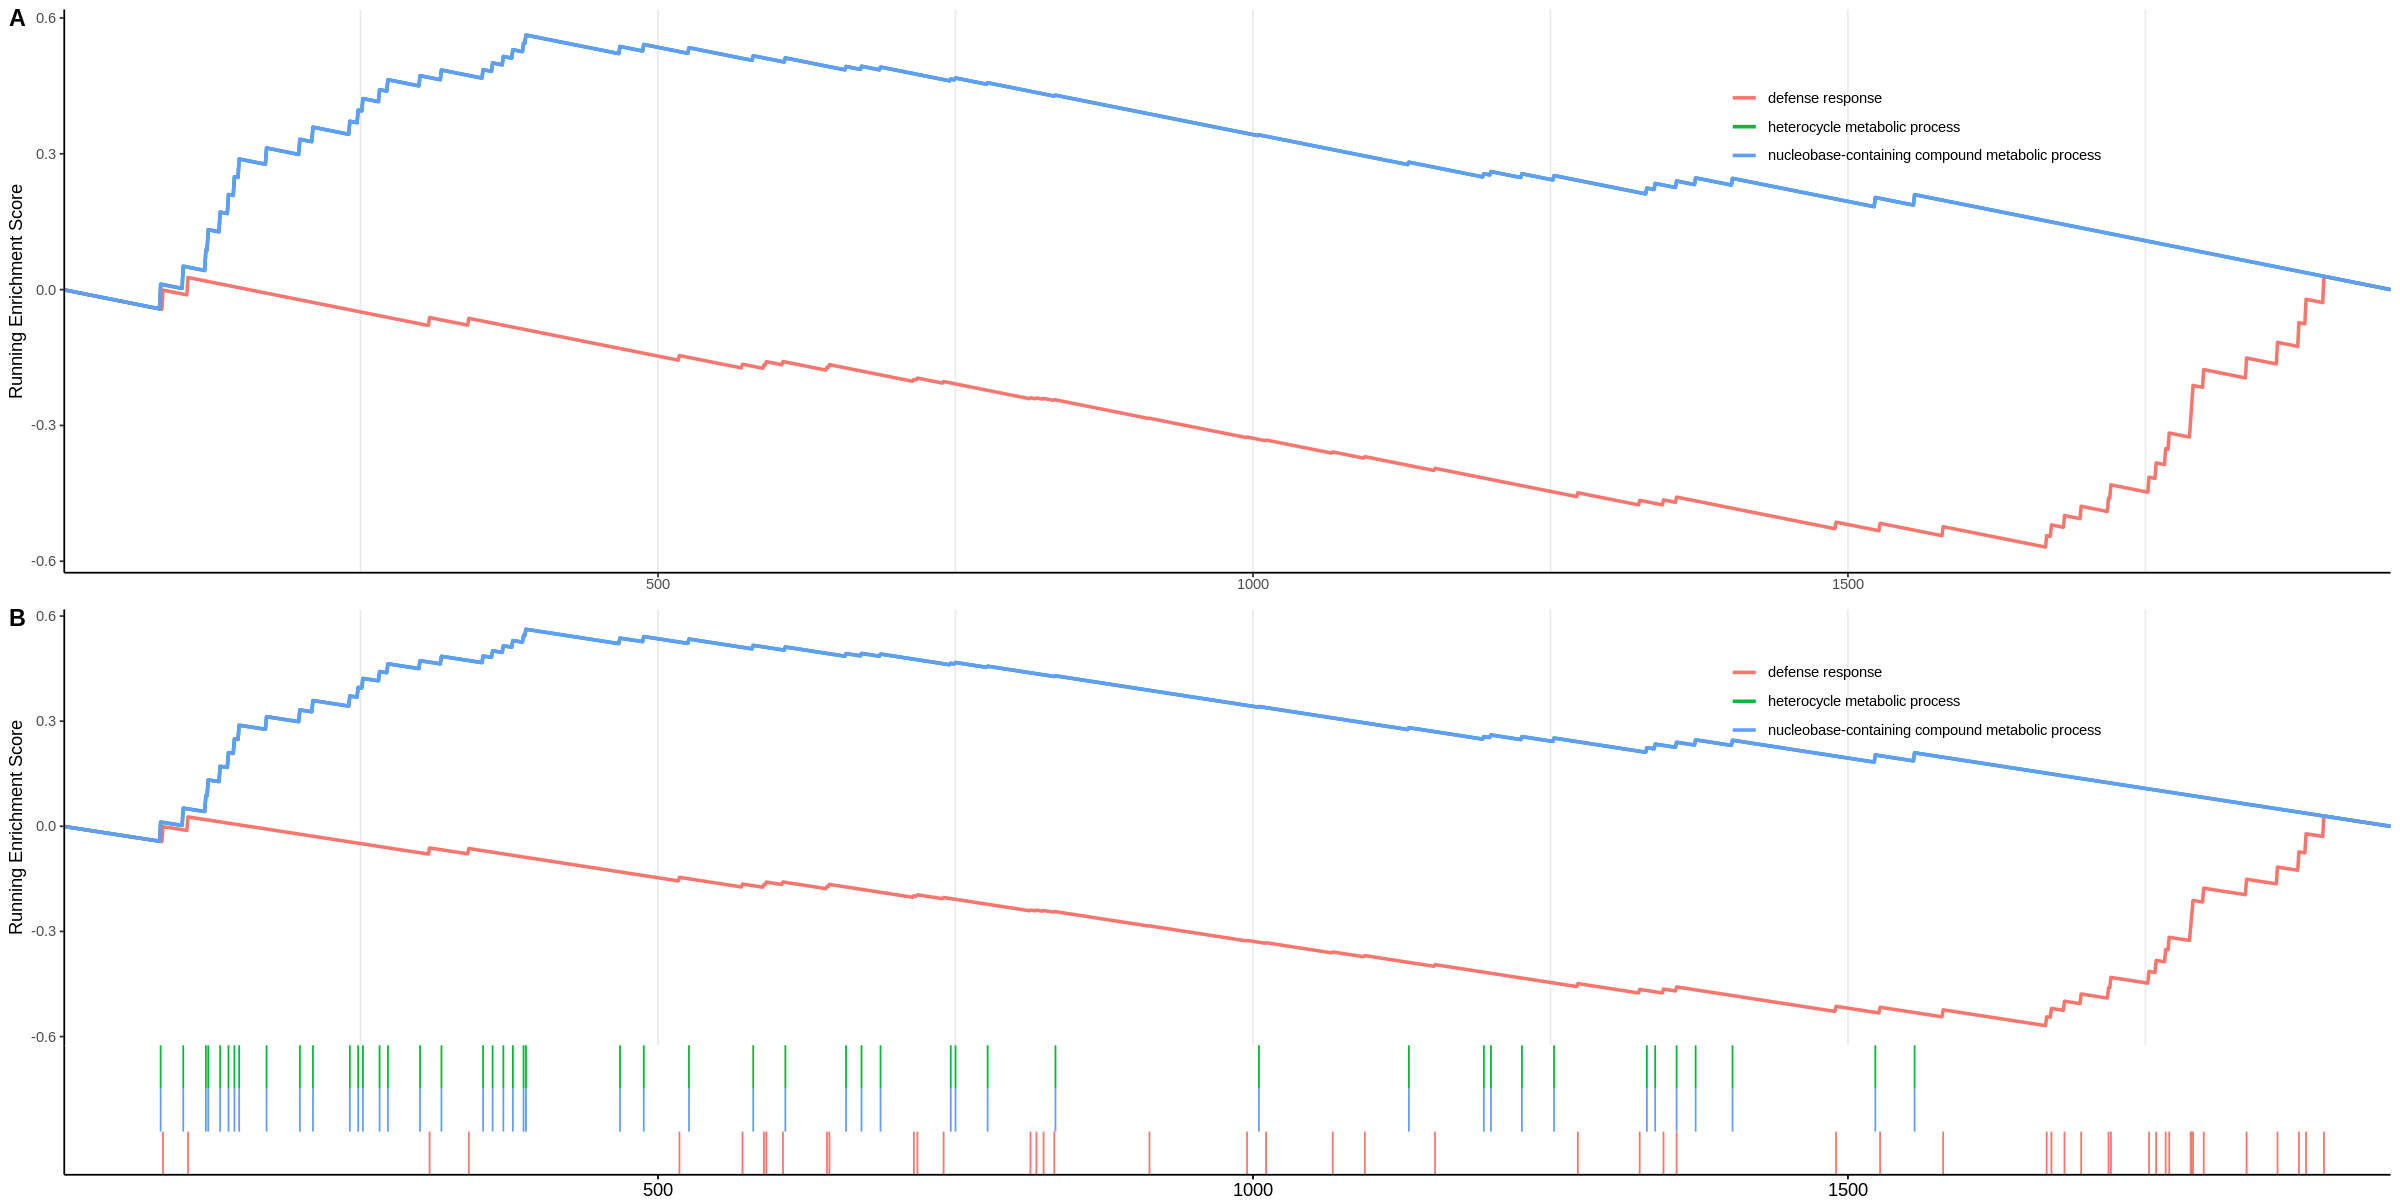

In [187]:
#User can specify subplots to only display a subset of plots:
p1 <- gseaplot2(resGO, geneSetID = 1:3, subplots = 1)
p2 <- gseaplot2(resGO, geneSetID = 1:3, subplots = 1:2)
cowplot::plot_grid(p1, p2, ncol=1, labels=LETTERS[1:2])

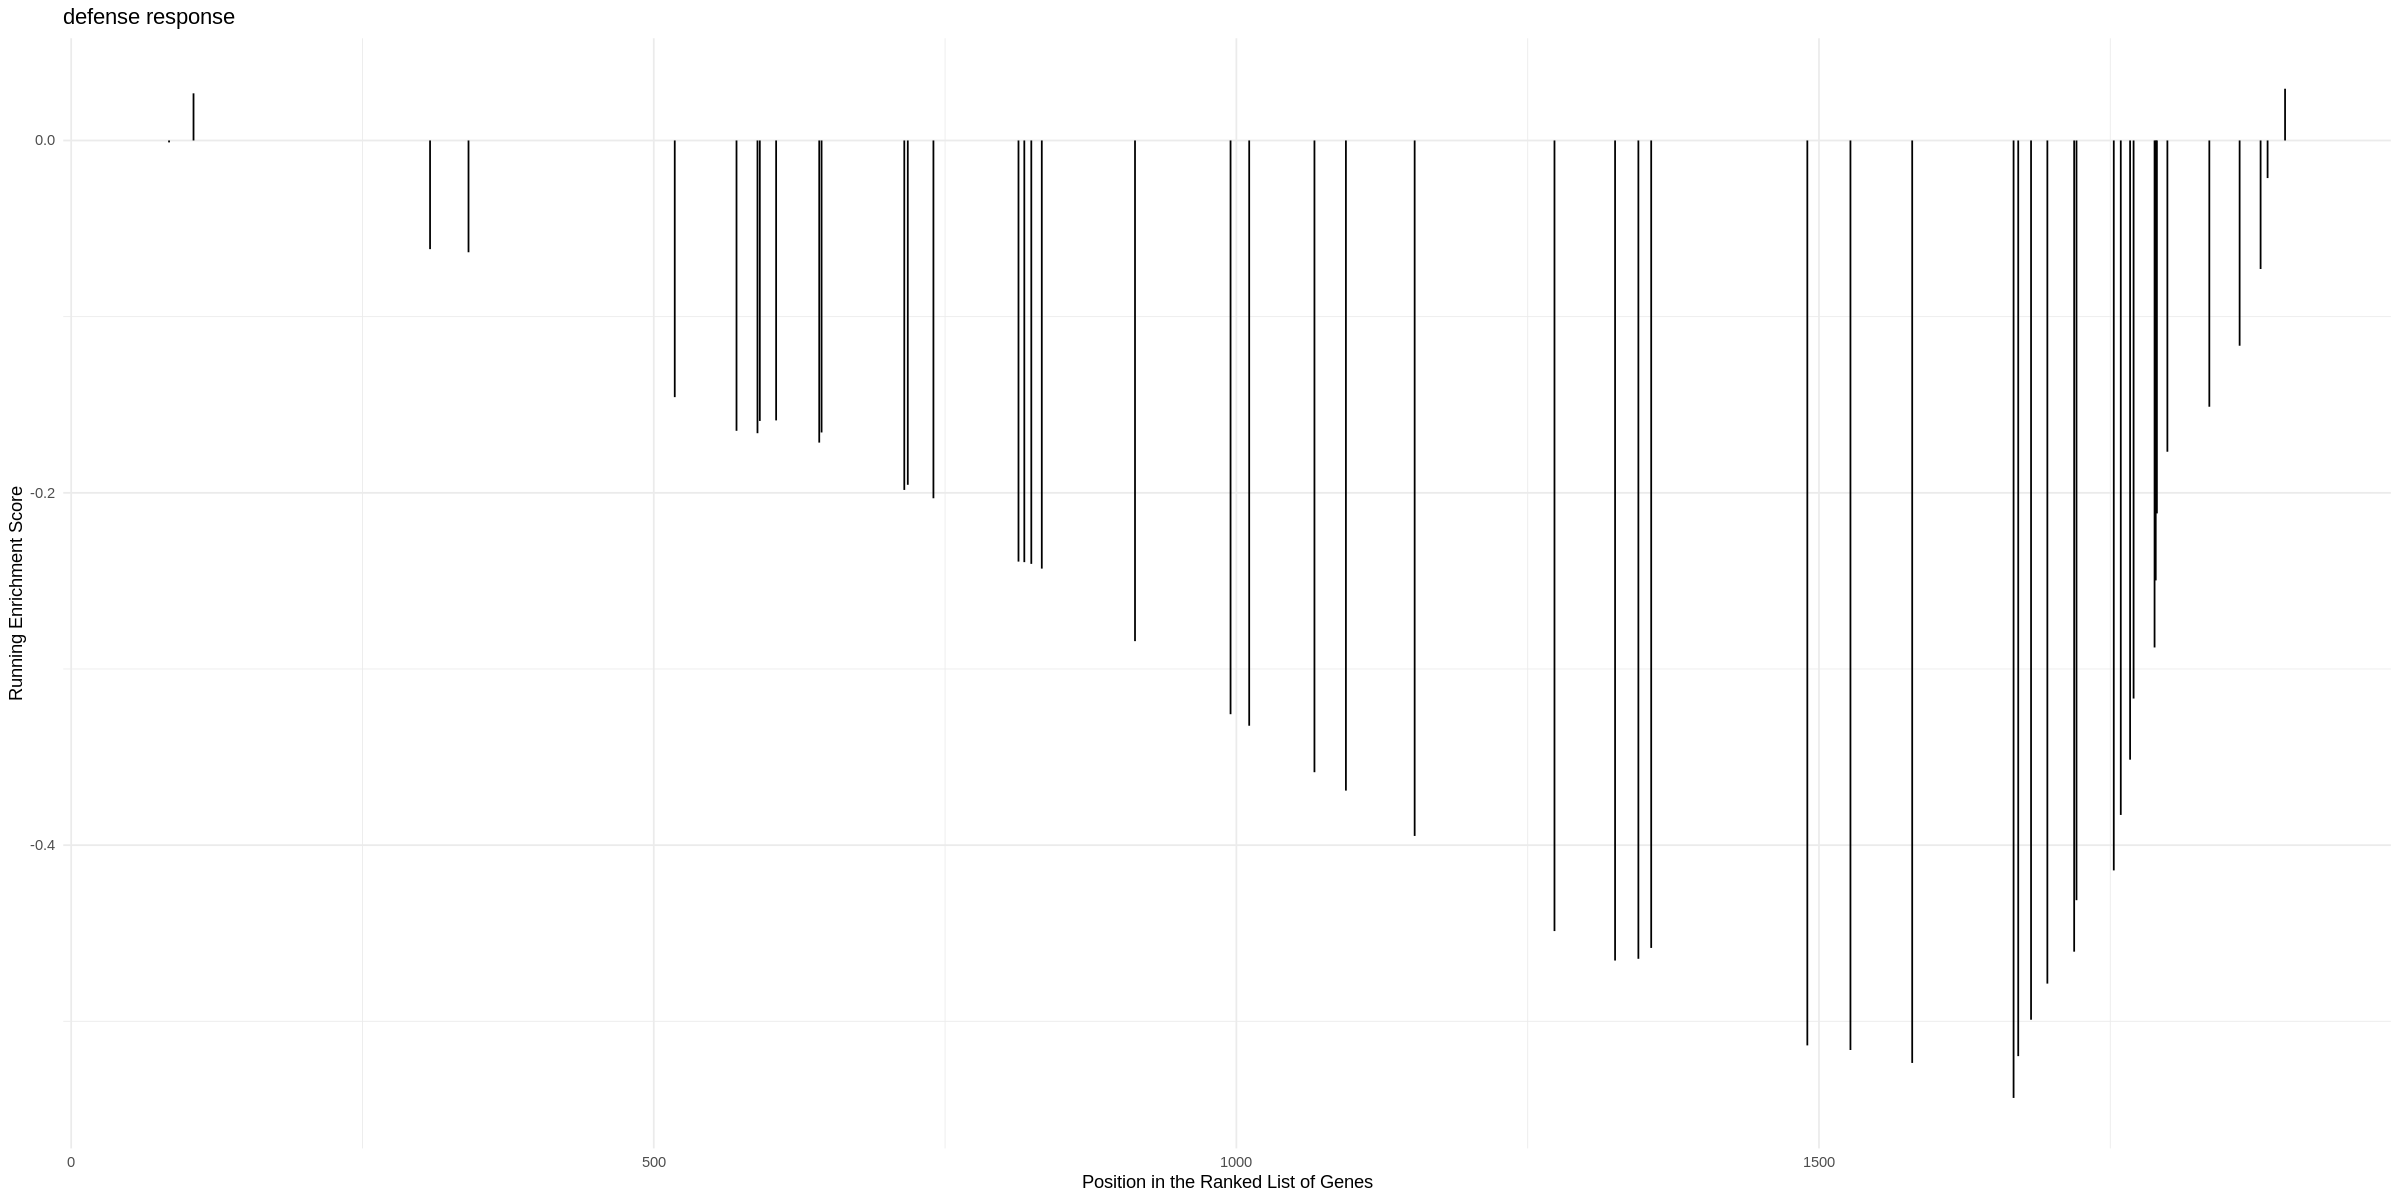

In [188]:
#The gsearank function plot the ranked list of genes belong to the specific gene set.
gsearank(resGO, 1, title = resGO[1, "Description"])

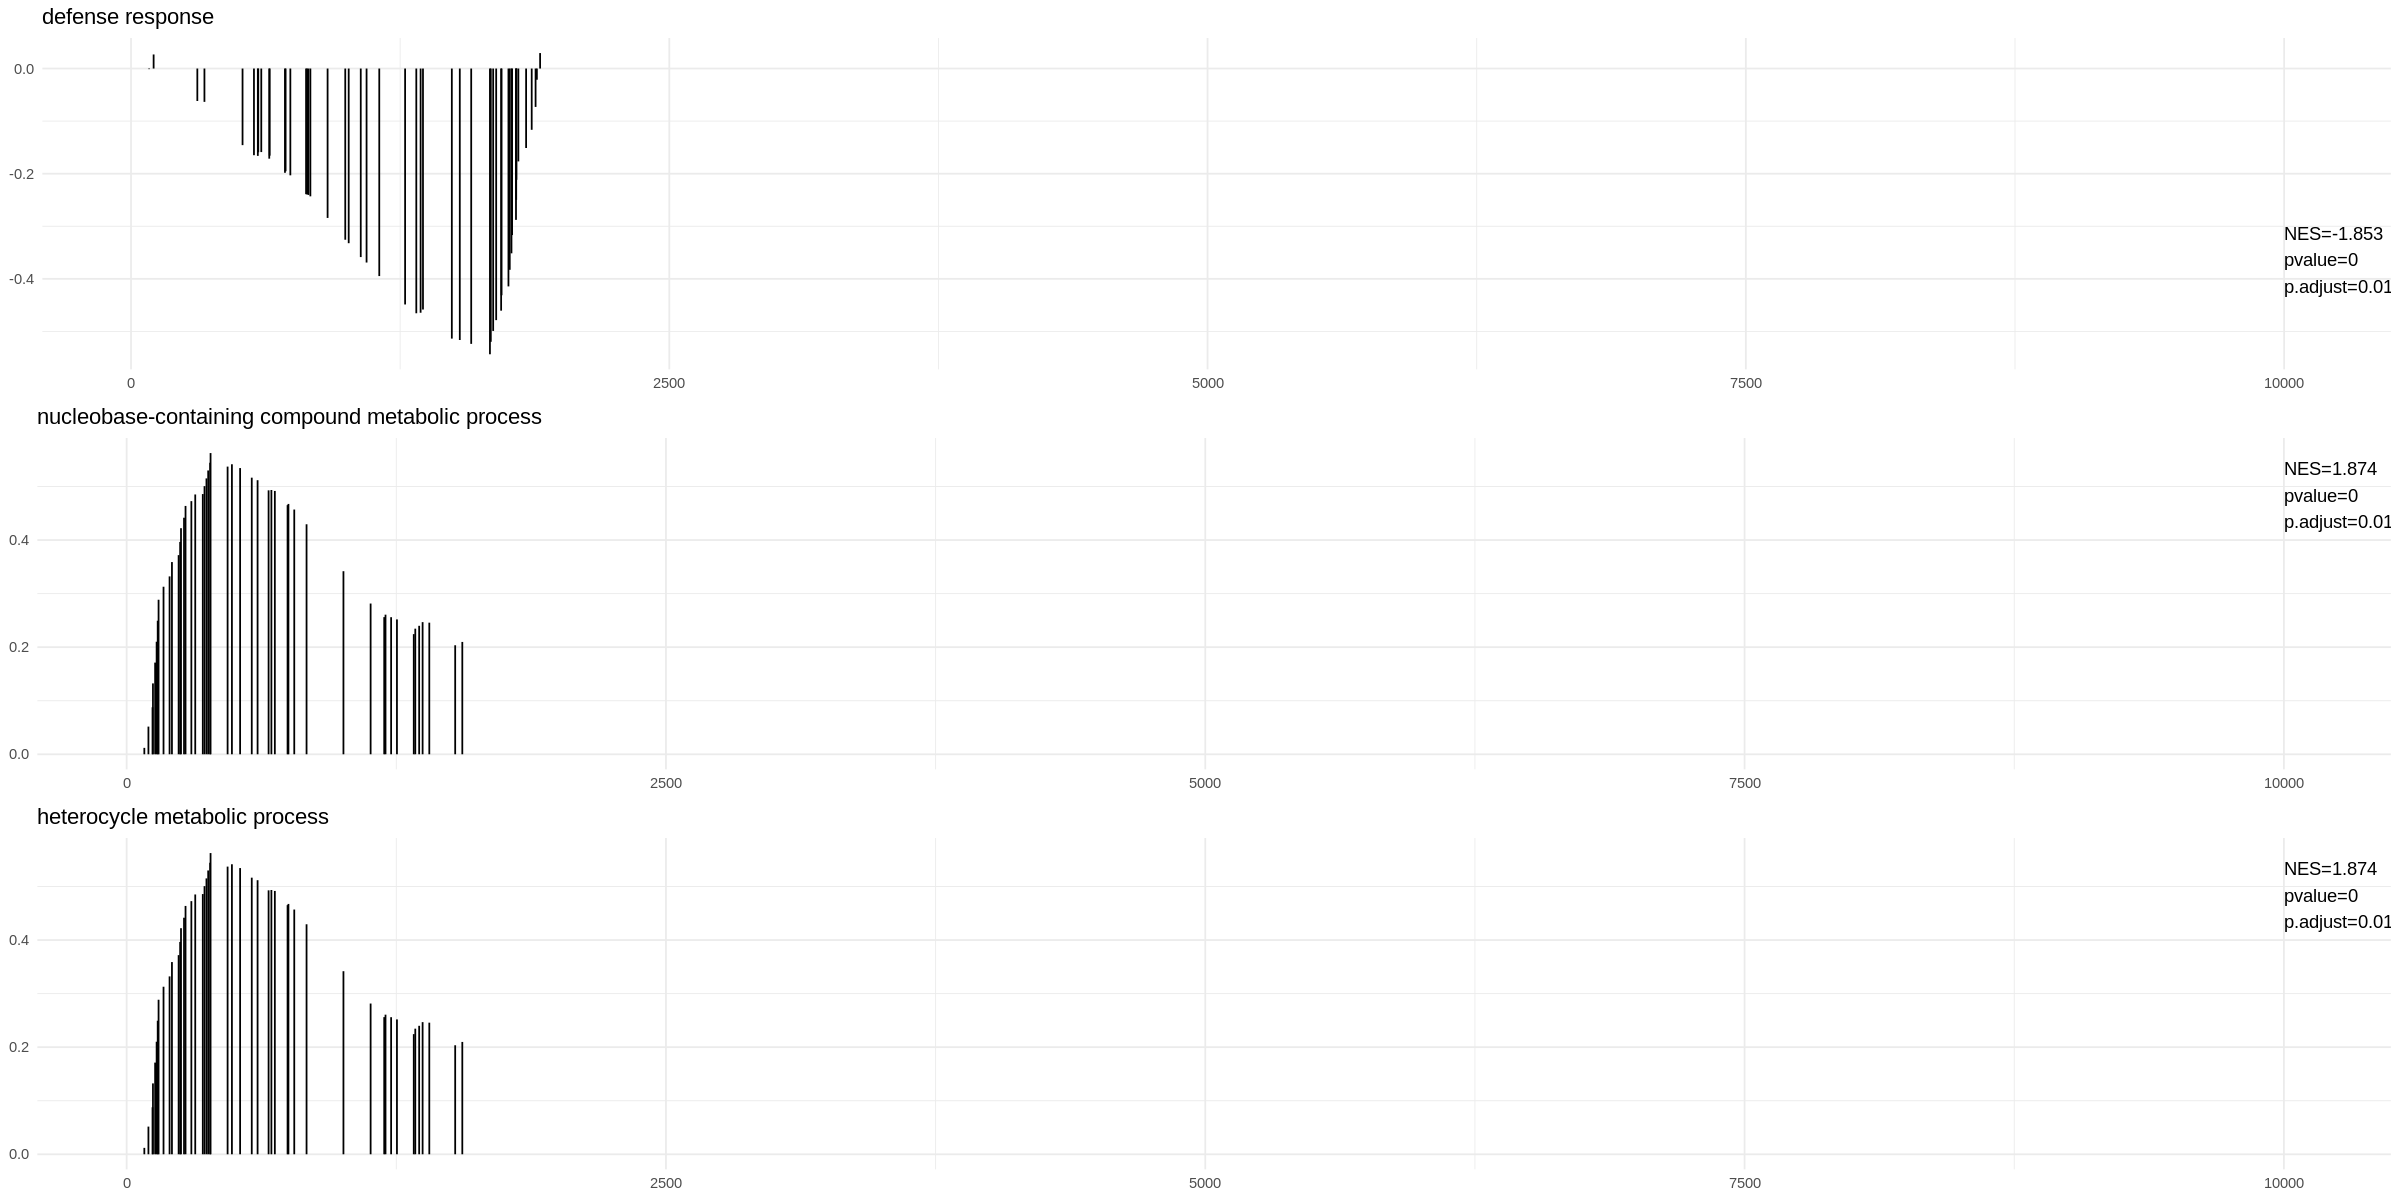

In [189]:
#Multiple gene sets can be aligned using cowplot:
pp <- lapply(1:3, function(i) {
    anno <- resGO[i, c("NES", "pvalue", "p.adjust")]
    lab <- paste0(names(anno), "=",  round(anno, 3), collapse="\n")

    gsearank(resGO, i, resGO[i, 2]) + xlab(NULL) +ylab(NULL) +
        annotate("text", 10000, resGO[i, "enrichmentScore"] * .75, label = lab, hjust=0, vjust=0)
})
plot_grid(plotlist=pp, ncol=1)

### Biological theme analysis - original clusterProfiler
#### -> I could use this to compare our expanded+expressed set with the pure expressed set..

In [205]:
# I first need a list with seperate character vectors for each cluster/set;
UPregulated <- names(qlfc_vec[qlfc_vec > 0])
DOWNregulated <- names(qlfc_vec[qlfc_vec < 0])

ck_test <- list(UPregulated, DOWNregulated)
names(ck_test) <- c("UPregulated", "DOWNregulated")
str(ck_test)

List of 2
 $ UPregulated  : chr [1:936] "HORVU3Hr1G089300" "HORVU5Hr1G103460" "HORVU6Hr1G084070" "HORVU3Hr1G004300" ...
 $ DOWNregulated: chr [1:1020] "Zm00001d006496" "HORVU5Hr1G076280" "HORVU6Hr1G031910" "Zm00001d046521" ...


In [199]:
?compareCluster

Warning message in seq_len(head.end.idx):
“first element used of 'length.out' argument”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): argument must be coercible to non-negative integer

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_conte

In [229]:
resGO

#
# Gene Set Enrichment Analysis
#
#...@organism 	 UNKNOWN 
#...@setType 	 UNKNOWN 
#...@geneList 	 Named num [1:1956] 10.56 10.48 10.38 9.97 9.66 ...
 - attr(*, "names")= chr [1:1956] "HORVU3Hr1G089300" "HORVU5Hr1G103460" "HORVU6Hr1G084070" "HORVU3Hr1G004300" ...
#...nPerm 	 
#...pvalues adjusted by 'BH' with cutoff <0.05 
#...8 enriched terms found
'data.frame':	8 obs. of  11 variables:
 $ ID             : chr  "GO:0006952" "GO:0006139" "GO:0046483" "GO:0042221" ...
 $ Description    : chr  "defense response" "nucleobase-containing compound metabolic process" "heterocycle metabolic process" "response to chemical" ...
 $ setSize        : int  50 49 49 21 48 90 66 52
 $ enrichmentScore: num  -0.569 0.562 0.562 -0.704 0.551 ...
 $ NES            : num  -1.85 1.87 1.87 -1.91 1.84 ...
 $ pvalue         : num  0.000256 0.000269 0.000269 0.000381 0.000604 ...
 $ p.adjust       : num  0.00986 0.00986 0.00986 0.01048 0.01272 ...
 $ qvalues        : num  0.00698 0.00698 0.00698 0.00742 0.00901

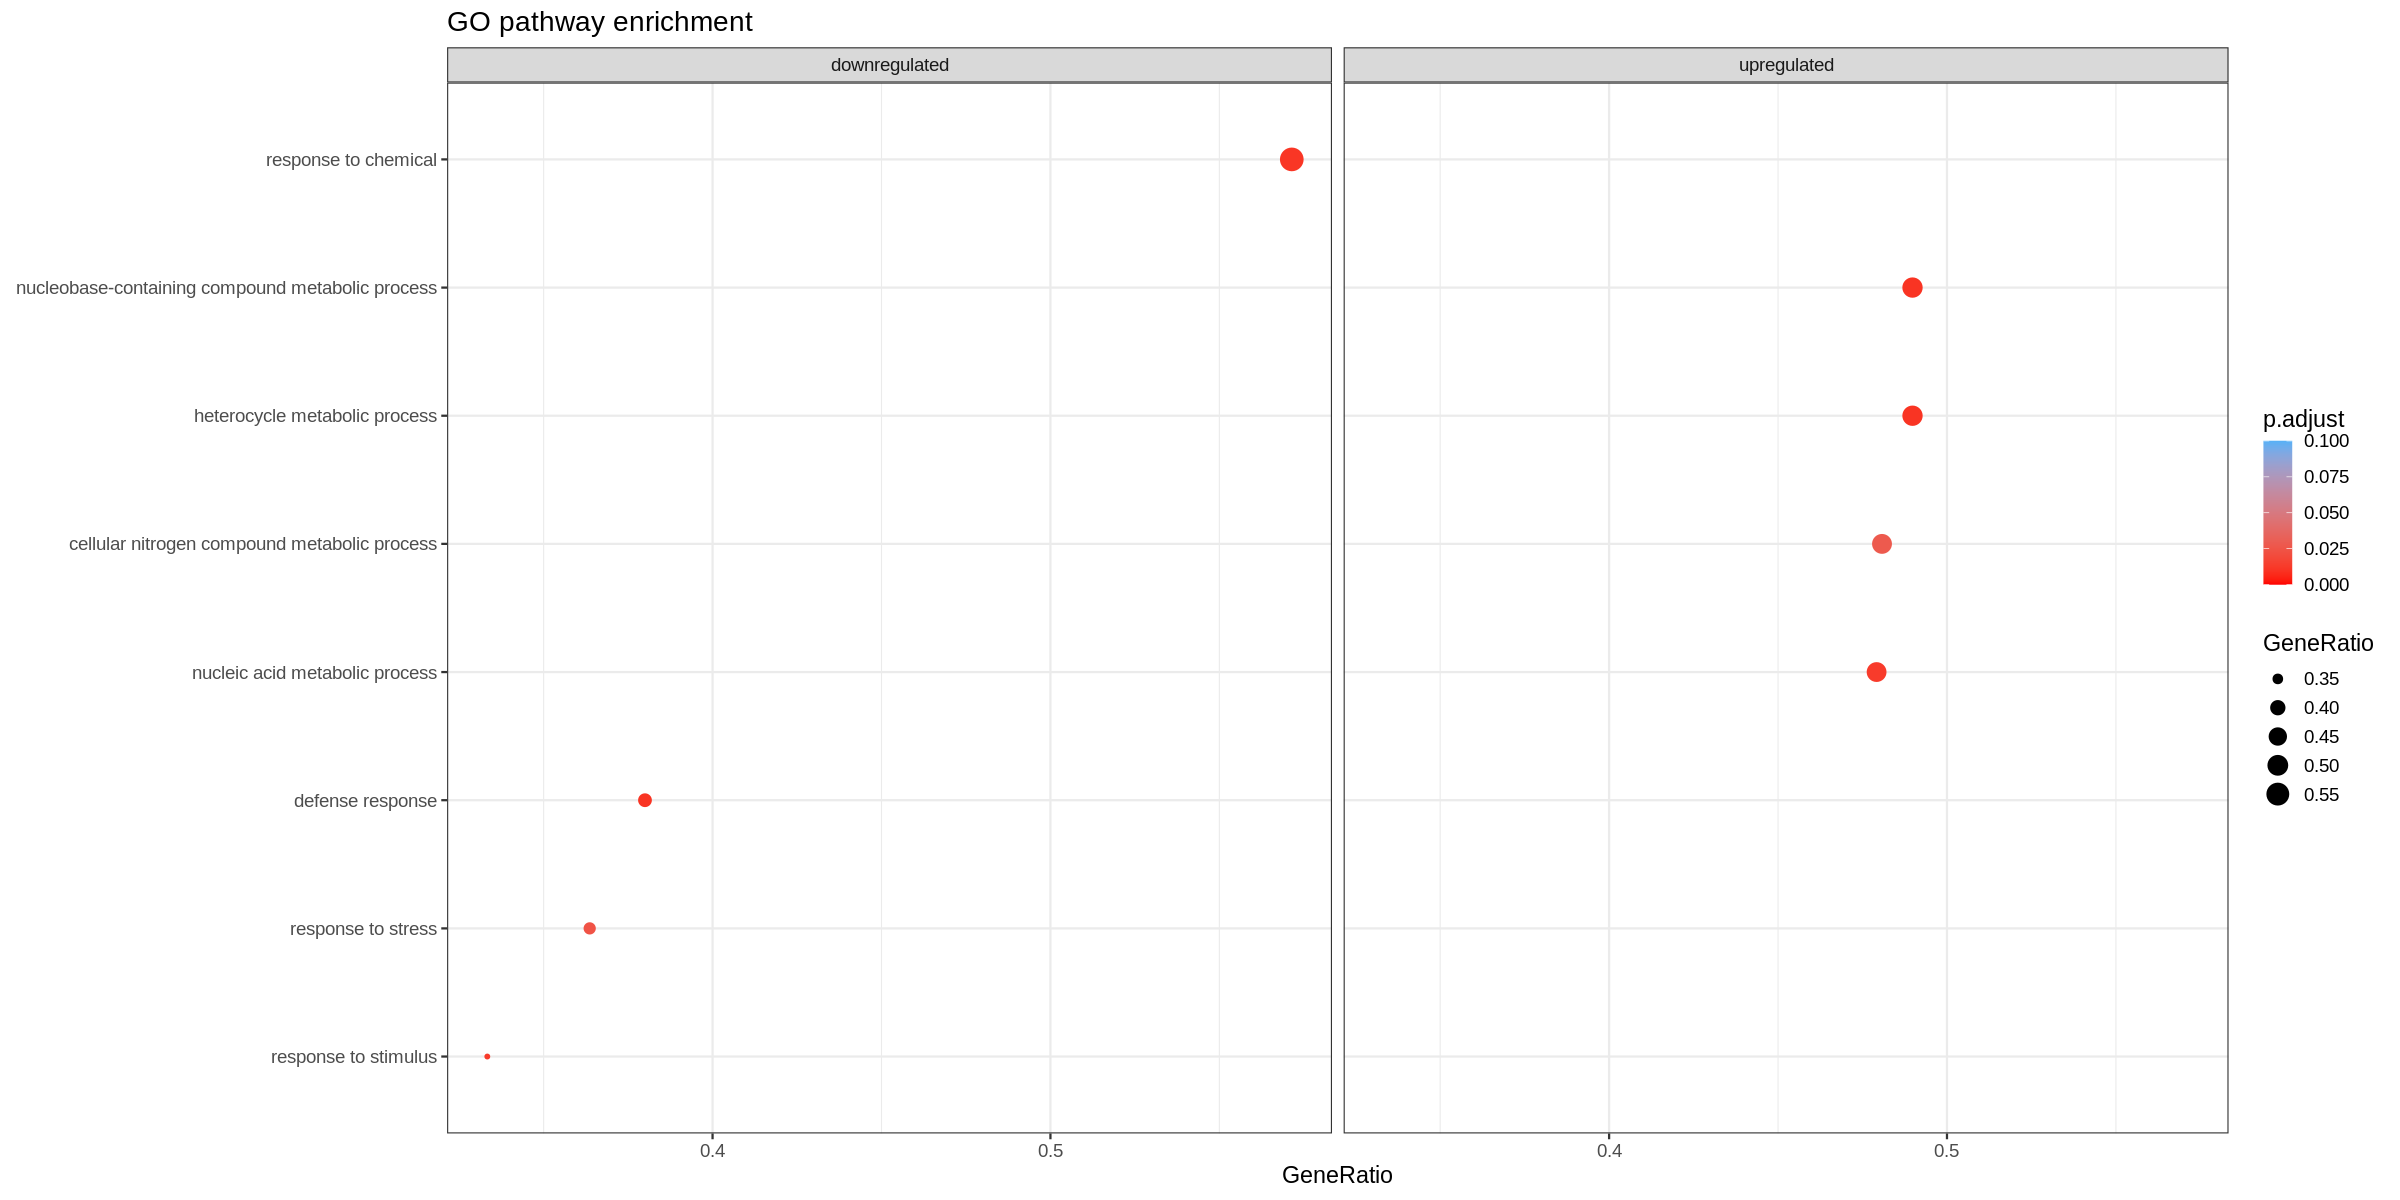

In [240]:
#GSEA() solution 
#https://github.com/YuLab-SMU/DOSE/issues/20

## count the gene number
gene_count <- resGO@result %>% group_by(ID) %>% summarise(count = sum(str_count(core_enrichment, "/")) + 1)
#gene_count

## merge with the original dataframe
dot_df<- left_join(resGO@result, gene_count, by = "ID") %>% mutate(GeneRatio = count/setSize)
#dot_df

## plot
library(forcats) ## for reordering the factor

#dot_df = dot_df[1:50,] ## small dataset
dot_df$type = "upregulated"
dot_df$type[dot_df$NES < 0] = "downregulated"

#head(dot_df)

## from Tommy's code
p <- ggplot(dot_df, aes(x = GeneRatio, y = fct_reorder(Description, GeneRatio))) + 
               geom_point(aes(size = GeneRatio, color = p.adjust)) +
               theme_bw(base_size = 14) +
        scale_colour_gradient(limits=c(0, 0.10), low="red") +
        ylab(NULL) +
        ggtitle("GO pathway enrichment")

p + facet_grid(.~type)

In [259]:
?merge_result

Warning message in seq_len(head.end.idx):
“first element used of 'length.out' argument”
ERROR while rich displaying an object: Error in seq_len(head.end.idx): argument must be coercible to non-negative integer

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_conte

Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


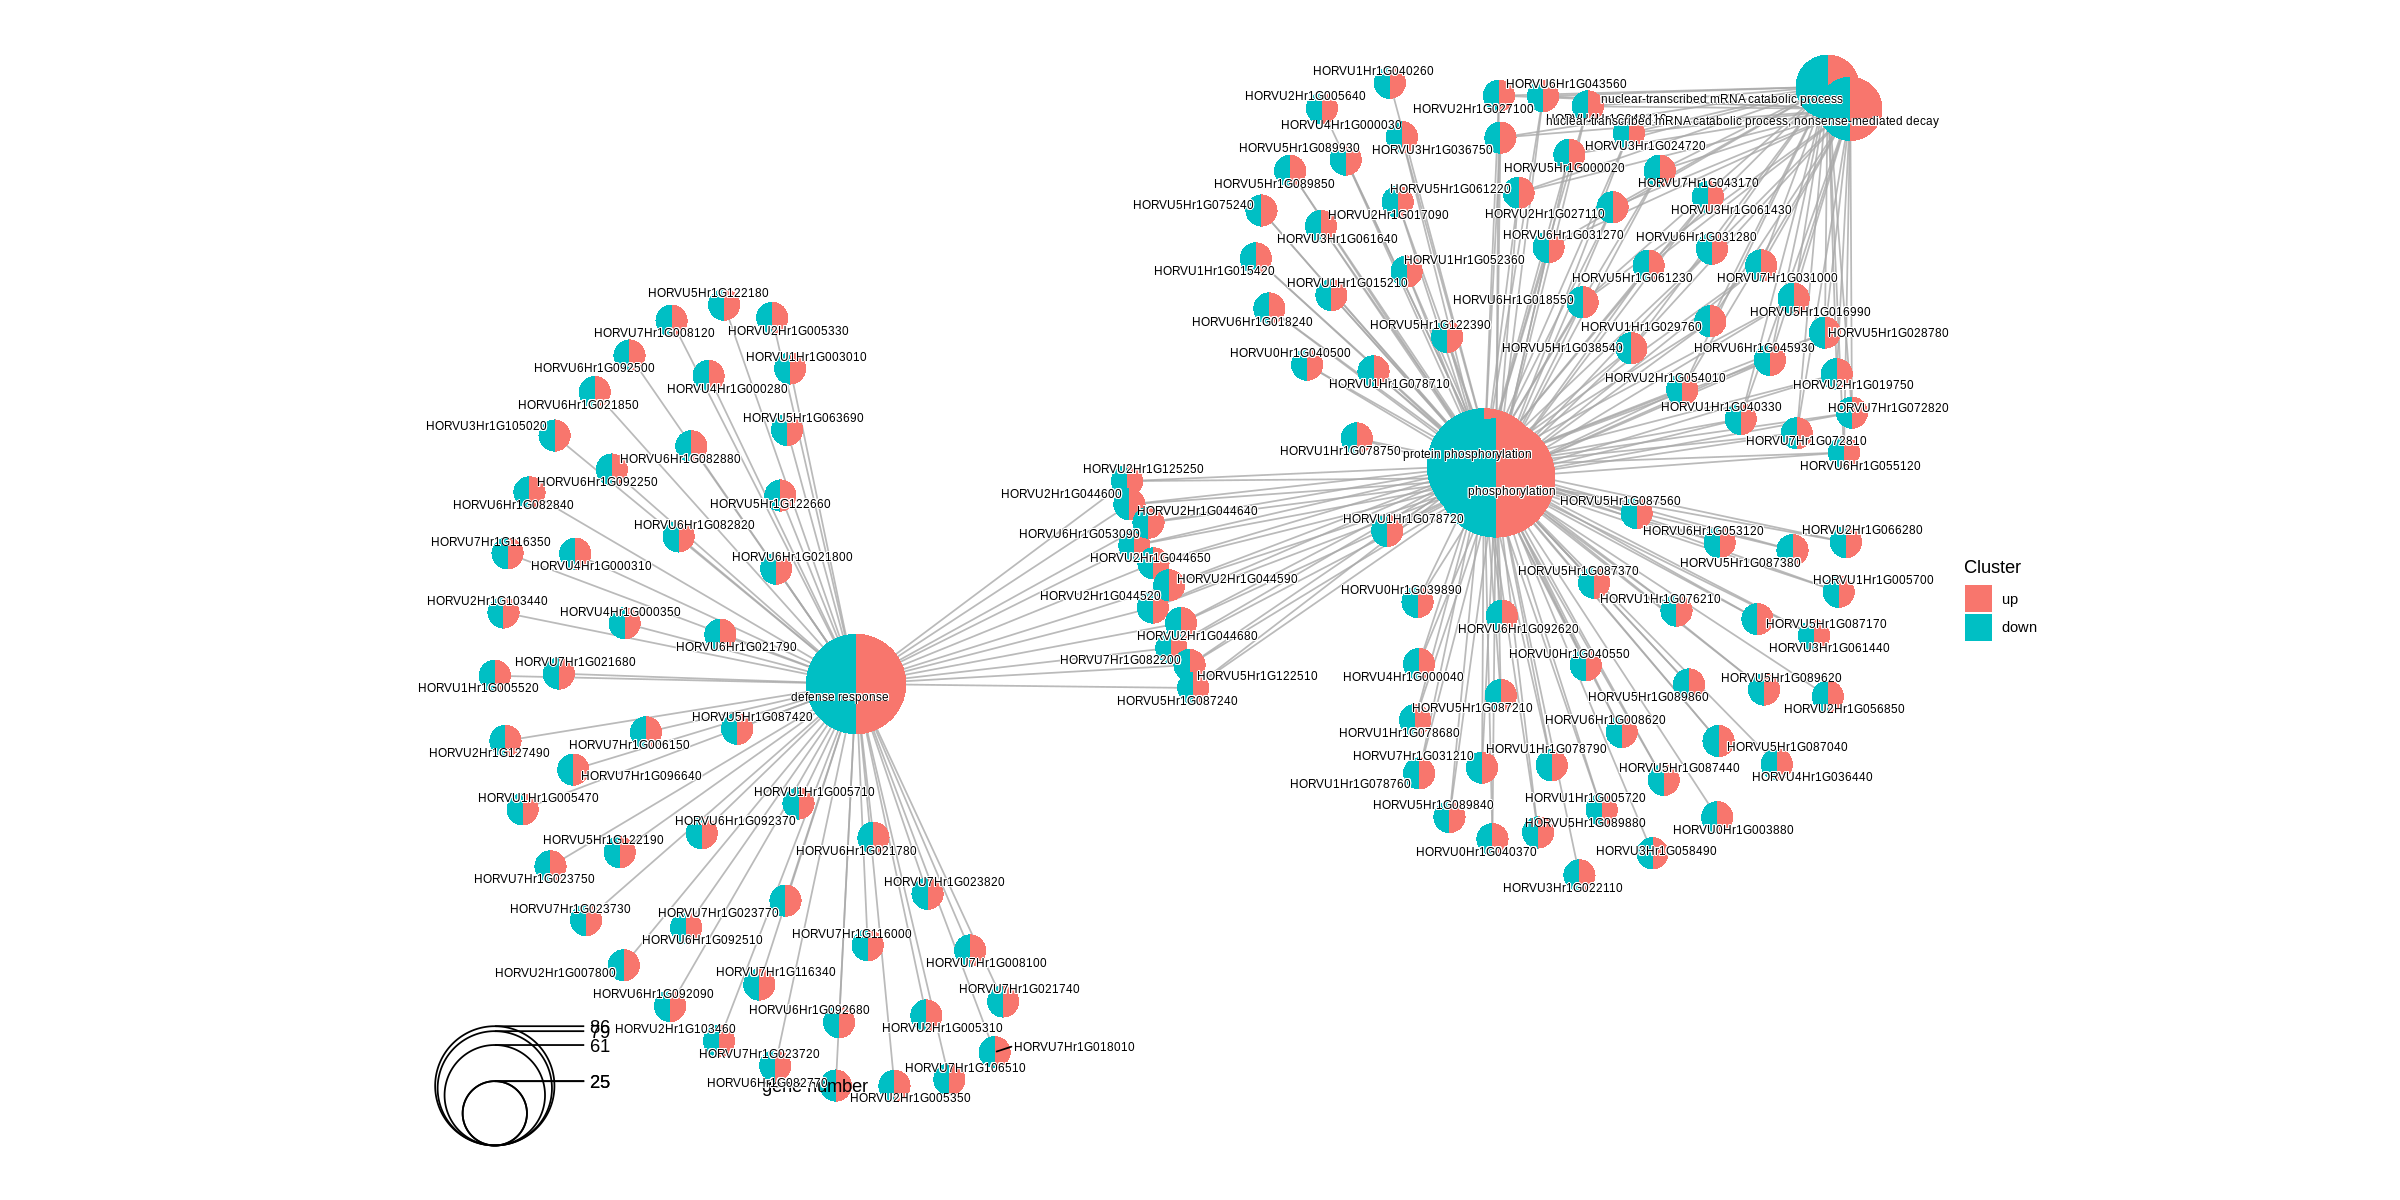

In [306]:
#I guess theis might only work with enrichr results..
#up <- dot_df %>% filter(type=="upregulated")
#down <- dot_df %>% filter(type=="downregulated")

#resGO2 <- resGO

#a <- merge_result(list(up=resGO, down=resGO2))

#str(a)
#a@compareClusterResult$Cluster <- as.factor(a@compareClusterResult$Cluster)
#str(a)
#dotplot(a)
cnetplot(a)

In [305]:
str(a@)

Formal class 'compareClusterResult' [package "DOSE"] with 9 slots
  ..@ compareClusterResult:'data.frame':	54 obs. of  10 variables:
  .. ..$ Cluster    : Factor w/ 2 levels "up","down": 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ ID         : chr [1:54] "GO:0006468" "GO:0016310" "GO:0000184" "GO:0006952" ...
  .. ..$ Description: chr [1:54] "protein phosphorylation" "phosphorylation" "nuclear-transcribed mRNA catabolic process, nonsense-mediated decay" "defense response" ...
  .. ..$ GeneRatio  : chr [1:54] "79/242" "86/242" "25/242" "61/242" ...
  .. ..$ BgRatio    : chr [1:54] "371/3478" "464/3478" "60/3478" "326/3478" ...
  .. ..$ pvalue     : num [1:54] 2.56e-22 4.00e-20 2.03e-14 4.20e-14 1.95e-12 ...
  .. ..$ p.adjust   : num [1:54] 9.76e-20 7.64e-18 2.58e-12 4.01e-12 1.49e-10 ...
  .. ..$ qvalue     : num [1:54] 8.93e-20 6.99e-18 2.36e-12 3.67e-12 1.36e-10 ...
  .. ..$ geneID     : chr [1:54] "HORVU0Hr1G039890/HORVU0Hr1G040370/HORVU0Hr1G040500/HORVU0Hr1G040550/HORVU1Hr1G005700/HORVU1Hr1G00

Warning message:
“Removed 384 rows containing missing values (geom_point).”


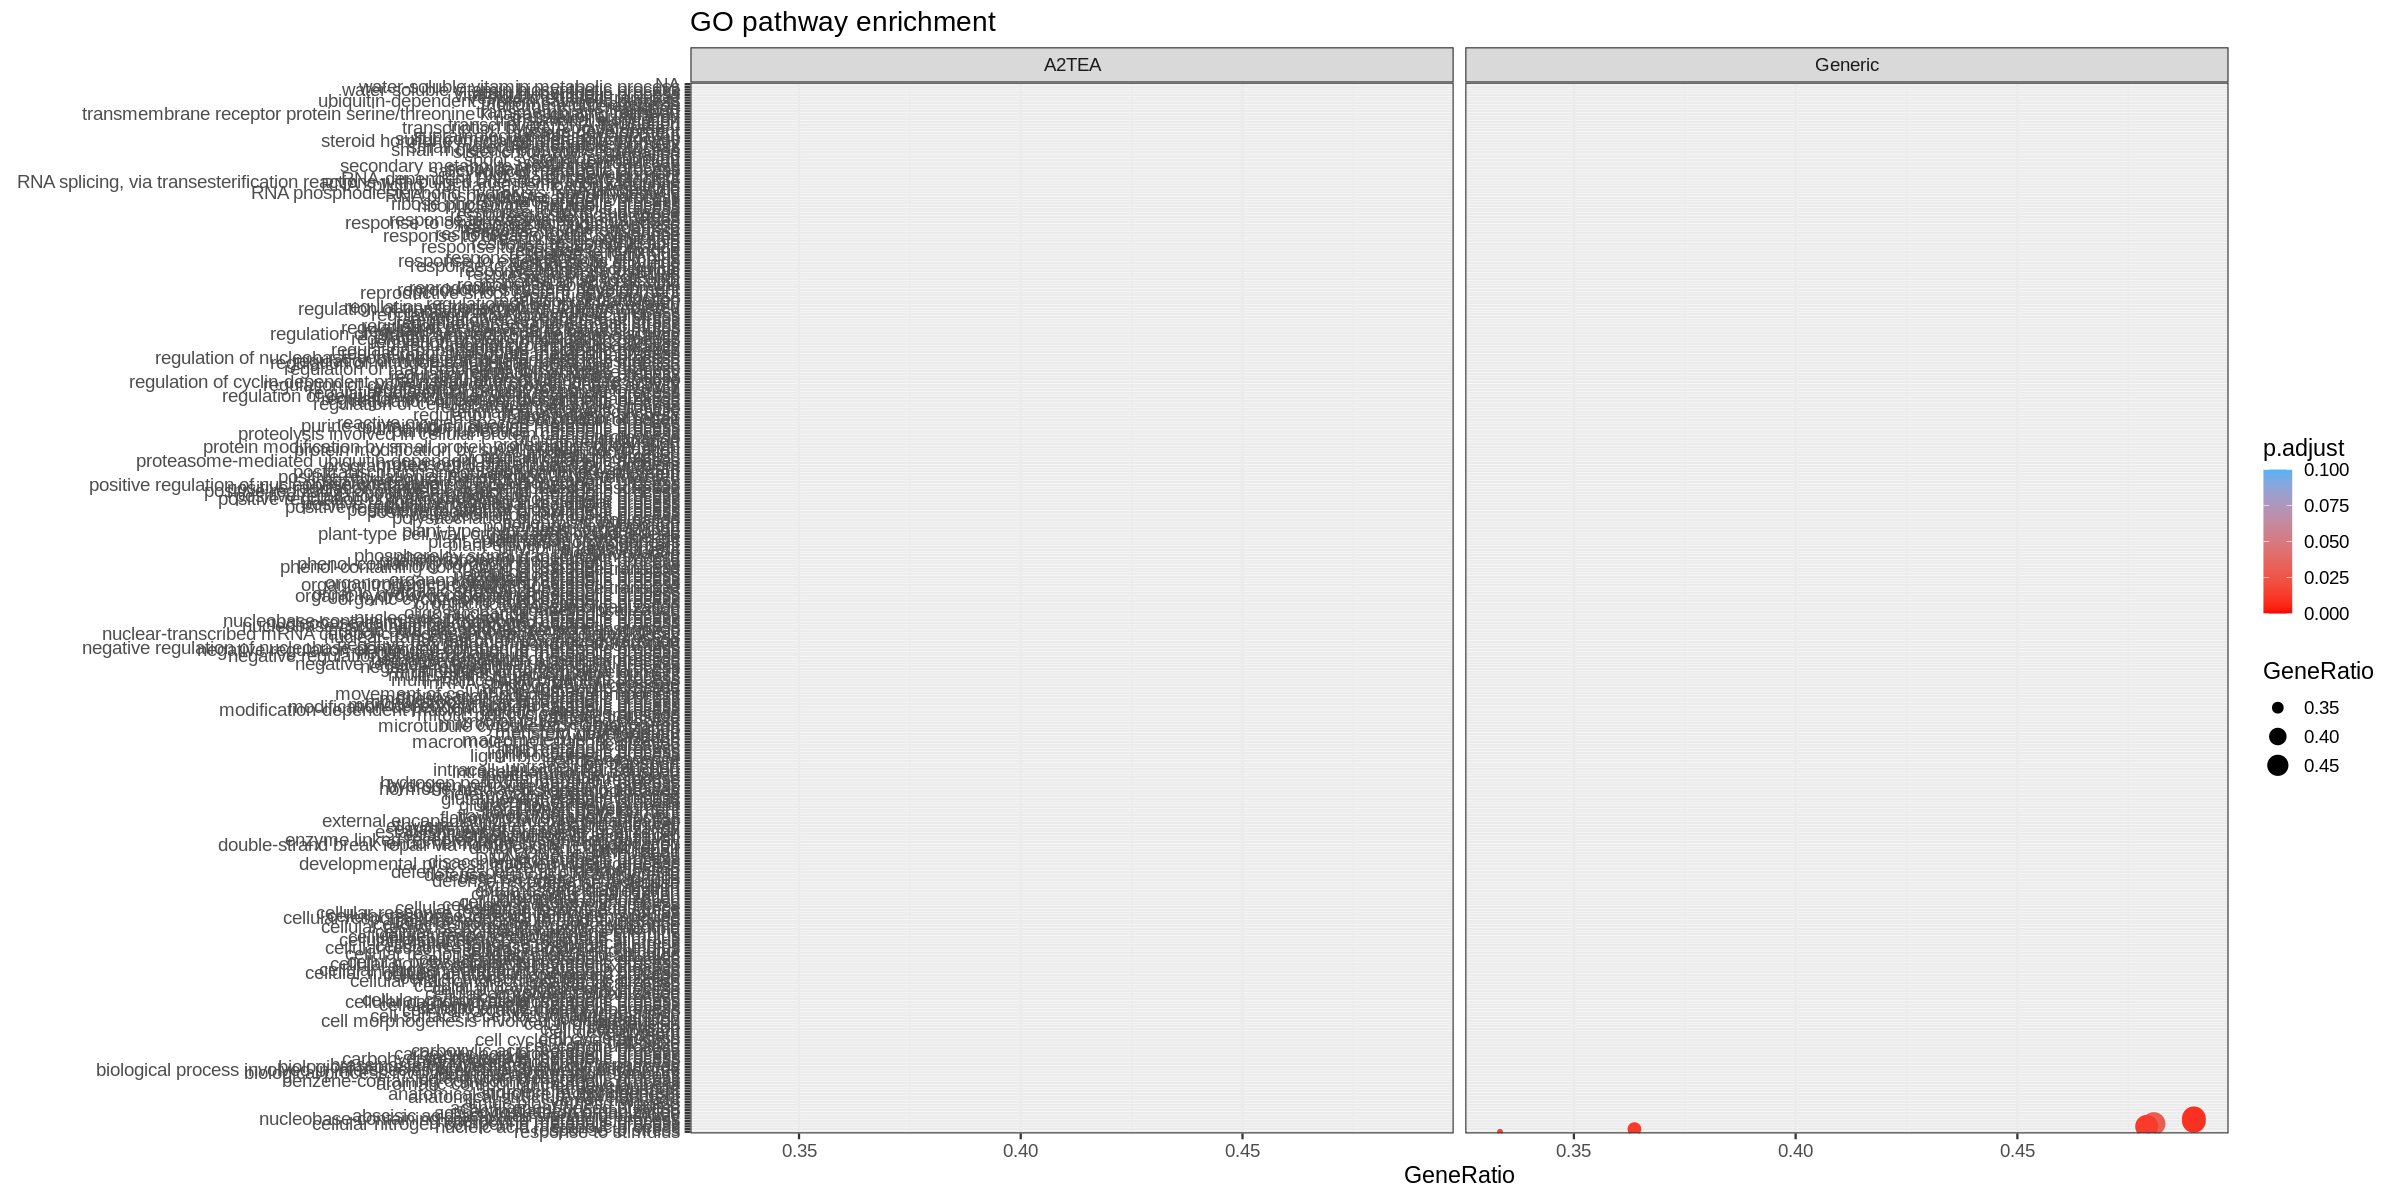

In [301]:
#Solution that works for GSEA data
#https://www.biostars.org/p/363491/
A <- resGO@result
B <- resGO2@result

A$Set <- "A2TEA"
B$Set <- "Generic"


b <- merge(A, B, all = TRUE)
#str(b)

## count the gene number
gene_count <- b %>% group_by(ID) %>% summarise(count = sum(str_count(core_enrichment, "/")) + 1)
#gene_count

## merge with the original dataframe
dot_df <- left_join(b, gene_count, by = "ID") %>% mutate(GeneRatio = count/setSize)


p <- ggplot(dot_df, aes(x = GeneRatio, y = fct_reorder(Description, GeneRatio))) + 
               geom_point(aes(size = GeneRatio, color = p.adjust)) +
               theme_bw(base_size = 14) +
        scale_colour_gradient(limits=c(0, 0.10), low="red") +
        ylab(NULL) +
        ggtitle("GO pathway enrichment")

p + facet_grid(.~Set)

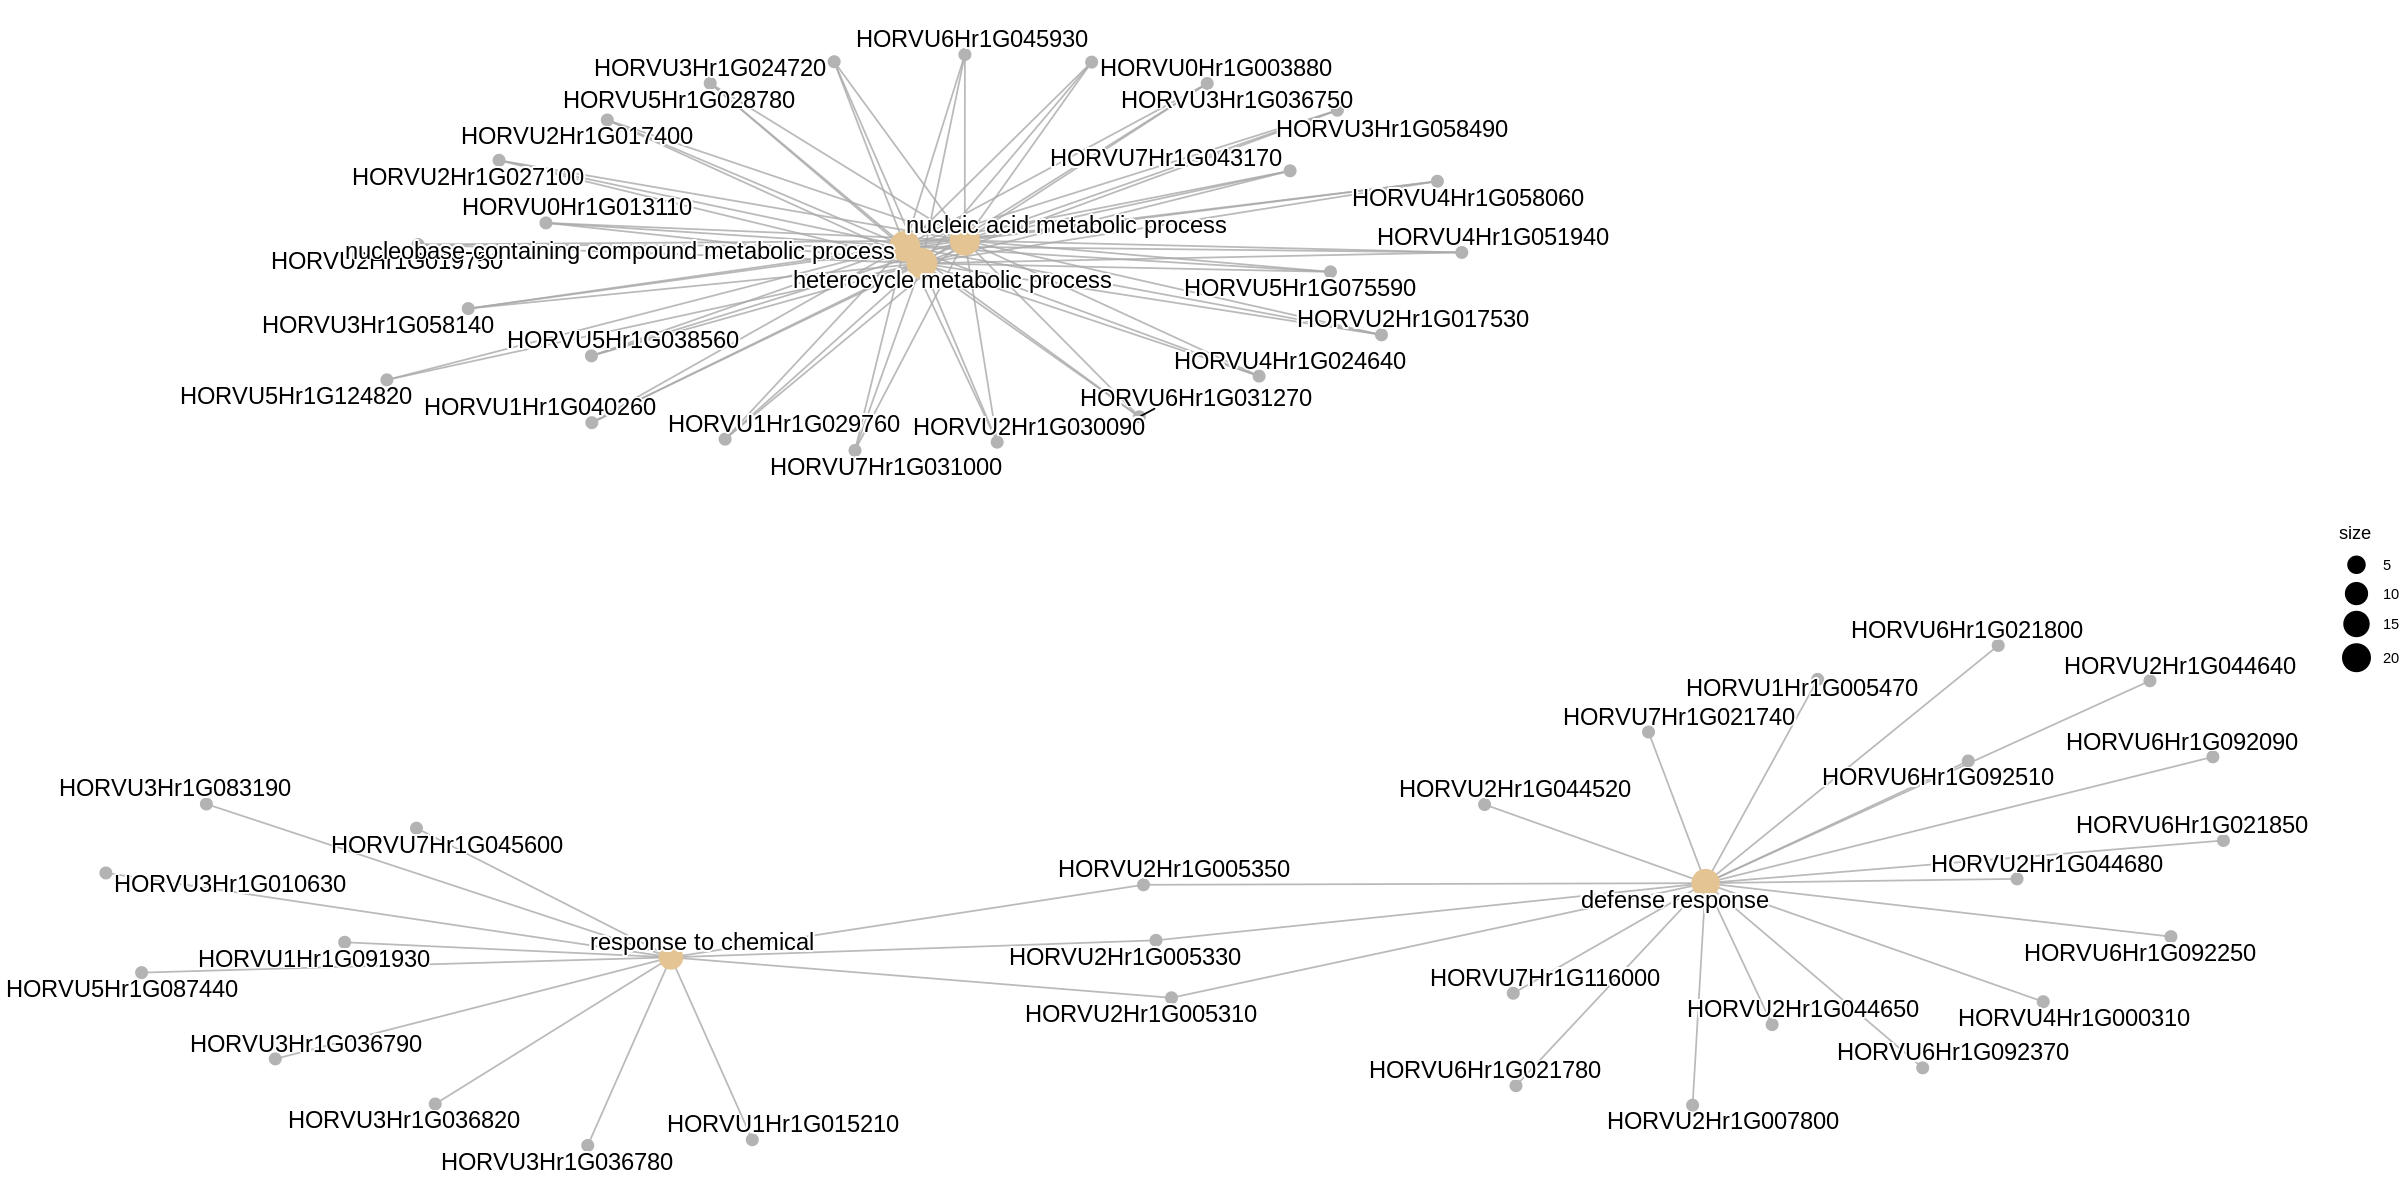

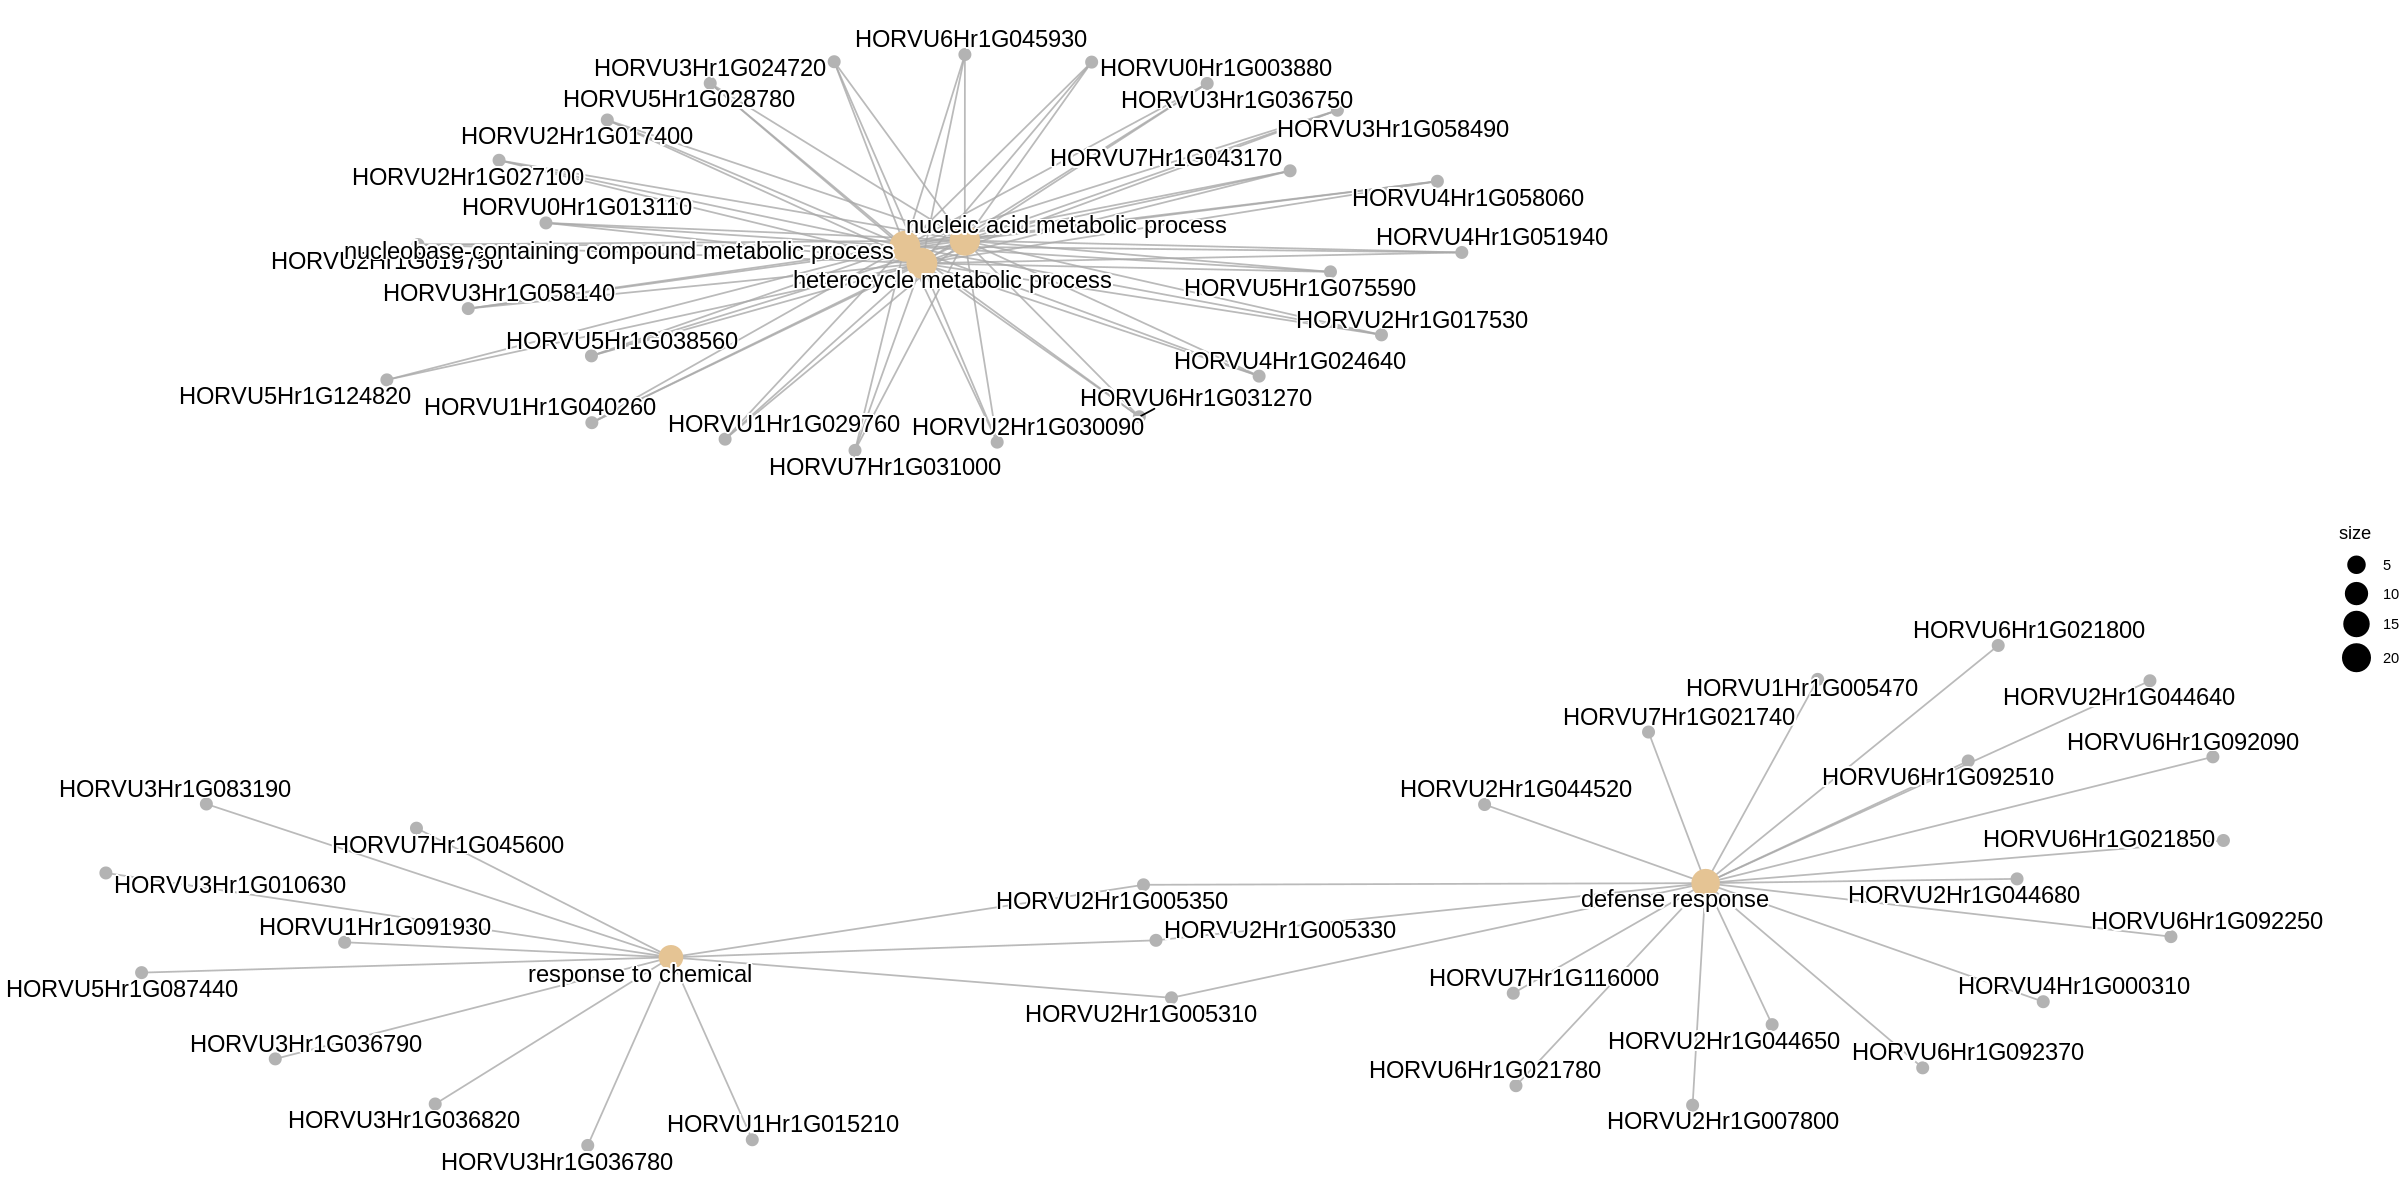

In [299]:
cnetplot(resGO)
cnetplot(resGO2)